# CODIGO GENERAL

## 1.1 - LIBRERIAS

In [95]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

In [96]:
# Configurar la visualización de gráficos inline
%matplotlib inline

# 2.O - CSV DENUNCIAS


### 2.1 - IMPORTACION DE CSV

In [97]:
denuncias_path = ('../datos/csv procesados/limpios_denuncias.csv')
df_denuncias = pd.read_csv(denuncias_path)

In [98]:
df_denuncias.sample(3, random_state=4)

fecha_ingreso hora_ingreso  nro_registro_interno   situacion     origen  \
478     2020-04-17          NaN             505455505    Urgencia  Ciudadano   
5620    2023-05-31        14:28            2545751535  Emergencia  Ciudadano   
1959    2021-04-16          NaN            9494751515    Urgencia  Ciudadano   

     es_anonima   tema                                         subtema  \
478          No  Trata                                        Grooming   
5620         Sí  Trata  Explotación sexual niñas, niños y adolescentes   
1959         Sí  Trata                              Explotación sexual   

         provincia         localidad  ... derivacion3_fecha  \
478   Buenos Aires  Florencio Varela  ...               NaN   
5620      Santa Fe           Rosario  ...               NaN   
1959  Buenos Aires         Ituzaingó  ...               NaN   

     derivacion3_judicializa denunciante_nacionalidad denunciante_provincia  \
478                      NaN                      NaN                   NaN   
5620                     NaN                      NaN              Santa Fe   
1959                     NaN                      NaN                   NaN   

     denunciante_localidad         denunciante_tipo  \
478                    NaN                      NaN   
5620                   NaN  Denunciante - ciudadano   
1959                   NaN  Denunciante - ciudadano   

     denunciante_como_conocio_la_linea denunciante_genero  \
478                                NaN                NaN   
5620                               NaN              Mujer   
1959                               NaN             Hombre   

     denunciante_edad_aparente provincia_indec_id  
478                        NaN                6.0  
5620                       0.0               82.0  
1959                      35.0                6.0  

[3 rows x 29 columns]

### 2.2 - COLUMNAS

#### 2.2.1 - TIPOS DE DATOS

In [99]:
# Convertir hora_ingreso a hora del día
df_denuncias['hora_ingreso'] = pd.to_datetime(df_denuncias['hora_ingreso']).dt.hour

# Convertir fecha_ingreso a datetime
df_denuncias['fecha_ingreso'] = pd.to_datetime(df_denuncias['fecha_ingreso'])

# Lista de columnas para convertir a categorías
categorias_cols = ['situacion', 'origen', 'tema', 'provincia', 'dependencia_alta', 
                   'via_ingreso', 'derivacion_institucion', 'derivacion_judicializa', 
                   'denunciante_provincia', 'es_anonima', 'subtema', 'localidad',
                    'denunciante_como_conocio_la_linea']

# Convertir columnas a categorías en una sola línea
df_denuncias[categorias_cols] = df_denuncias[categorias_cols].astype('category')

/var/folders/sf/zv8w99hn1570688_wf9y1h280000gn/T/ipykernel_2119/4206414756.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_denuncias['hora_ingreso'] = pd.to_datetime(df_denuncias['hora_ingreso']).dt.hour


In [100]:
# Convertir derivacion_fecha_hora a hora del día
df_denuncias['derivacion_fecha'] = pd.to_datetime(df_denuncias['derivacion_fecha'])
df_denuncias['derivacion_hora'] = df_denuncias['derivacion_fecha'].dt.hour

# Obtener año, mes y día de derivacion_fecha en una sola línea
df_denuncias['derivacion_anio'] = df_denuncias['derivacion_fecha'].dt.year
df_denuncias['derivacion_mes'] = df_denuncias['derivacion_fecha'].dt.month
df_denuncias['derivacion_dia'] = df_denuncias['derivacion_fecha'].dt.day

df_denuncias  = df_denuncias.drop('derivacion_fecha', axis=1)

In [101]:
# Convierto valores float a int
# Itera a través de las columnas del DataFrame
for column in df_denuncias.columns:
    # Verifica si el tipo de la columna es float o float64
    if df_denuncias[column].dtype in ['float', 'float64']:
        # Encuentra los índices donde los valores no son nulos
        not_null_indices = pd.notna(df_denuncias[column])
        
        # Convierte los valores no nulos a tipo int y reemplaza los valores en el DataFrame original
        df_denuncias.loc[not_null_indices, column] = df_denuncias.loc[not_null_indices, column].astype(int)

In [102]:
# Convertir derivacion_fecha_hora a hora del día
df_denuncias['fecha_ingreso'] = pd.to_datetime(df_denuncias['fecha_ingreso'])
df_denuncias['ingreso_hora'] = df_denuncias['fecha_ingreso'].dt.hour

# Obtener año, mes y día de derivacion_fecha en una sola línea
df_denuncias['ingreso_anio'] = df_denuncias['fecha_ingreso'].dt.year
df_denuncias['ingreso_mes'] = df_denuncias['fecha_ingreso'].dt.month
df_denuncias['ingreso_dia'] = df_denuncias['fecha_ingreso'].dt.day

df_denuncias  = df_denuncias.drop('fecha_ingreso', axis=1)

#### 2.2.2 - VALORES

In [103]:
df_denuncias.isnull().sum()

hora_ingreso                         3168
nro_registro_interno                    0
situacion                              20
origen                                  0
es_anonima                              0
tema                                    0
subtema                                 0
provincia                             471
localidad                             873
dependencia_alta                        0
via_ingreso                             1
derivacion_institucion                409
derivacion_judicializa                409
derivacion2_institucion              4754
derivacion2_fecha                    4754
derivacion2_judicializa              4754
derivacion3_institucion              5892
derivacion3_fecha                    5892
derivacion3_judicializa              5892
denunciante_nacionalidad             4837
denunciante_provincia                2887
denunciante_localidad                5137
denunciante_tipo                      335
denunciante_como_conocio_la_linea 

##### 2.2.2.0 - IMPUTACION GENERAL

In [104]:
#Interpolaciones realizadas por metodo interpolate 'hora_ingreso', 
moda_situacion = df_denuncias['situacion'].mode()[0]
denunciante_genero_moda = df_denuncias['denunciante_genero'].mode()[0]

df_denuncias.fillna(value = {'hora_ingreso':df_denuncias['hora_ingreso'],
                            'situacion': moda_situacion,
                            'provincia': df_denuncias.provincia.bfill(),
                            'localidad': df_denuncias.localidad.bfill(),
                            'denunciante_genero': denunciante_genero_moda},inplace=True)

In [105]:
df_denuncias.columns

Index(['hora_ingreso', 'nro_registro_interno', 'situacion', 'origen',
       'es_anonima', 'tema', 'subtema', 'provincia', 'localidad',
       'dependencia_alta', 'via_ingreso', 'derivacion_institucion',
       'derivacion_judicializa', 'derivacion2_institucion',
       'derivacion2_fecha', 'derivacion2_judicializa',
       'derivacion3_institucion', 'derivacion3_fecha',
       'derivacion3_judicializa', 'denunciante_nacionalidad',
       'denunciante_provincia', 'denunciante_localidad', 'denunciante_tipo',
       'denunciante_como_conocio_la_linea', 'denunciante_genero',
       'denunciante_edad_aparente', 'provincia_indec_id', 'derivacion_hora',
       'derivacion_anio', 'derivacion_mes', 'derivacion_dia', 'ingreso_hora',
       'ingreso_anio', 'ingreso_mes', 'ingreso_dia'],
      dtype='object')

In [106]:
cols_ordenadas = [
    'ingreso_anio', 'hora_ingreso', 'ingreso_mes', 'ingreso_dia', 'via_ingreso', 
    'nro_registro_interno', 'es_anonima', 'situacion', 'origen', 'provincia', 
    'localidad', 'tema', 'subtema', 'dependencia_alta', 'derivacion_institucion', 
    'denunciante_nacionalidad', 'denunciante_provincia', 'denunciante_localidad', 
    'denunciante_tipo', 'denunciante_como_conocio_la_linea', 'denunciante_genero', 
    'denunciante_edad_aparente', 'derivacion_anio', 'derivacion_mes', 'derivacion_dia', 
    'ingreso_hora', 'derivacion_judicializa', 'derivacion2_institucion', 
    'derivacion2_fecha', 'derivacion2_judicializa', 'derivacion3_institucion', 
    'derivacion3_fecha', 'derivacion3_judicializa', 'provincia_indec_id', 
    'derivacion_hora'
]

df_denuncias = df_denuncias[cols_ordenadas]


##### 2.2.2.1 - IMPUTACION AVANZADA

In [107]:
#df_denuncias['hora_ingreso'].interpolate(method='linear', inplace=True)

#### 2.2.3 - CODIFICACION

##### 2.2.3.0 - CATEGORICOS NOMINALES

In [108]:
columnas_categoricas = df_denuncias.select_dtypes(include=['category', 'object']).copy()
columnas_categoricas_nombres =  columnas_categoricas.columns

In [109]:
# Columnas categoricas nominales
df_denuncias_codificados = df_denuncias.copy()
for column in columnas_categoricas_nombres:
    encoder = LabelEncoder()
    df_denuncias_codificados[column] = encoder.fit_transform(df_denuncias_codificados[column].astype(str))

In [110]:
df_denuncias_codificados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5912 entries, 0 to 5911
Data columns (total 35 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   ingreso_anio                       5912 non-null   int32  
 1   hora_ingreso                       2744 non-null   float64
 2   ingreso_mes                        5912 non-null   int32  
 3   ingreso_dia                        5912 non-null   int32  
 4   via_ingreso                        5912 non-null   int64  
 5   nro_registro_interno               5912 non-null   int64  
 6   es_anonima                         5912 non-null   int64  
 7   situacion                          5912 non-null   int64  
 8   origen                             5912 non-null   int64  
 9   provincia                          5912 non-null   int64  
 10  localidad                          5912 non-null   int64  
 11  tema                               5912 non-null   int64

##### 2.2.3.1 - CATEGORICOS ORDINALES

In [111]:
#Columnas categoricas ordinales
# No hay

#### 2.2.4 - ESCALAMIENTO

In [112]:
scaler = MinMaxScaler()
df_denuncias_escalados = scaler.fit_transform(df_denuncias_codificados.copy())
df_denuncias_escalados = pd.DataFrame(df_denuncias_escalados, columns = df_denuncias.columns)

#### 2.2.5 - PORCENTAJE DE VALORES

In [113]:
df_denuncias_escalados.isnull().sum()

ingreso_anio                            0
hora_ingreso                         3168
ingreso_mes                             0
ingreso_dia                             0
via_ingreso                             0
nro_registro_interno                    0
es_anonima                              0
situacion                               0
origen                                  0
provincia                               0
localidad                               0
tema                                    0
subtema                                 0
dependencia_alta                        0
derivacion_institucion                  0
denunciante_nacionalidad                0
denunciante_provincia                   0
denunciante_localidad                   0
denunciante_tipo                        0
denunciante_como_conocio_la_linea       0
denunciante_genero                      0
denunciante_edad_aparente            1293
derivacion_anio                       409
derivacion_mes                    

#### 2.2.6 - MEDIDAS DE TENDENCIA CENTRAL

In [114]:
df_denuncias.describe(include='all')

ingreso_anio  hora_ingreso  ingreso_mes  ingreso_dia via_ingreso  \
count    5912.000000   2744.000000  5912.000000  5912.000000        5911   
unique           NaN           NaN          NaN          NaN          28   
top              NaN           NaN          NaN          NaN   Línea 145   
freq             NaN           NaN          NaN          NaN        5474   
mean     2021.413227     13.630466     6.042287    15.852673         NaN   
std         1.061745      5.271945     3.387694     8.861924         NaN   
min      2020.000000      0.000000     1.000000     1.000000         NaN   
25%      2021.000000     11.000000     3.000000     8.000000         NaN   
50%      2021.000000     14.000000     6.000000    16.000000         NaN   
75%      2022.000000     17.000000     9.000000    24.000000         NaN   
max      2023.000000     23.000000    12.000000    31.000000         NaN   

        nro_registro_interno es_anonima situacion     origen     provincia  \
count           5.912000e+03       5912      5912       5912          5912   
unique                   NaN          2         2        308            24   
top                      NaN         No  Urgencia  Ciudadano  Buenos Aires   
freq                     NaN       3195      4494       5208          2282   
mean            5.029537e+09        NaN       NaN        NaN           NaN   
std             2.828835e+09        NaN       NaN        NaN           NaN   
min             5.050515e+08        NaN       NaN        NaN           NaN   
25%             2.545841e+09        NaN       NaN        NaN           NaN   
50%             5.505305e+09        NaN       NaN        NaN           NaN   
75%             7.545455e+09        NaN       NaN        NaN           NaN   
max             9.494948e+09        NaN       NaN        NaN           NaN   

        ... ingreso_hora derivacion_judicializa derivacion2_institucion  \
count   ...       5912.0                   5503                    1158   
unique  ...          NaN                      2                      23   
top     ...          NaN                     Sí                  Protex   
freq    ...          NaN                   4983                    1053   
mean    ...          0.0                    NaN                     NaN   
std     ...          0.0                    NaN                     NaN   
min     ...          0.0                    NaN                     NaN   
25%     ...          0.0                    NaN                     NaN   
50%     ...          0.0                    NaN                     NaN   
75%     ...          0.0                    NaN                     NaN   
max     ...          0.0                    NaN                     NaN   

       derivacion2_fecha derivacion2_judicializa derivacion3_institucion  \
count               1158                    1158                      20   
unique              1155                       2                       9   
top     2021-07-16 22:15                      No                  Protex   
freq                   2                    1046                      10   
mean                 NaN                     NaN                     NaN   
std                  NaN                     NaN                     NaN   
min                  NaN                     NaN                     NaN   
25%                  NaN                     NaN                     NaN   
50%                  NaN                     NaN                     NaN   
75%                  NaN                     NaN                     NaN   
max                  NaN                     NaN                     NaN   

       derivacion3_fecha derivacion3_judicializa provincia_indec_id  \
count                 20                      20        5283.000000   
unique                20                       2                NaN   
top     2020-04-25 23:06                      No                NaN   
freq                   1                      19            

### 2.3.0 - RELACION ENTRE COLUMNAS

In [146]:
columnas_g_torta = ['derivacion2_fecha', 'derivacion3_fecha', 'denunciante_como_conocio_la_linea', 'denunciante_localidad', 'derivacion_institucion', 'subtema', 'localidad', 'origen']

/var/folders/sf/zv8w99hn1570688_wf9y1h280000gn/T/ipykernel_2119/1919428661.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(18, 12))


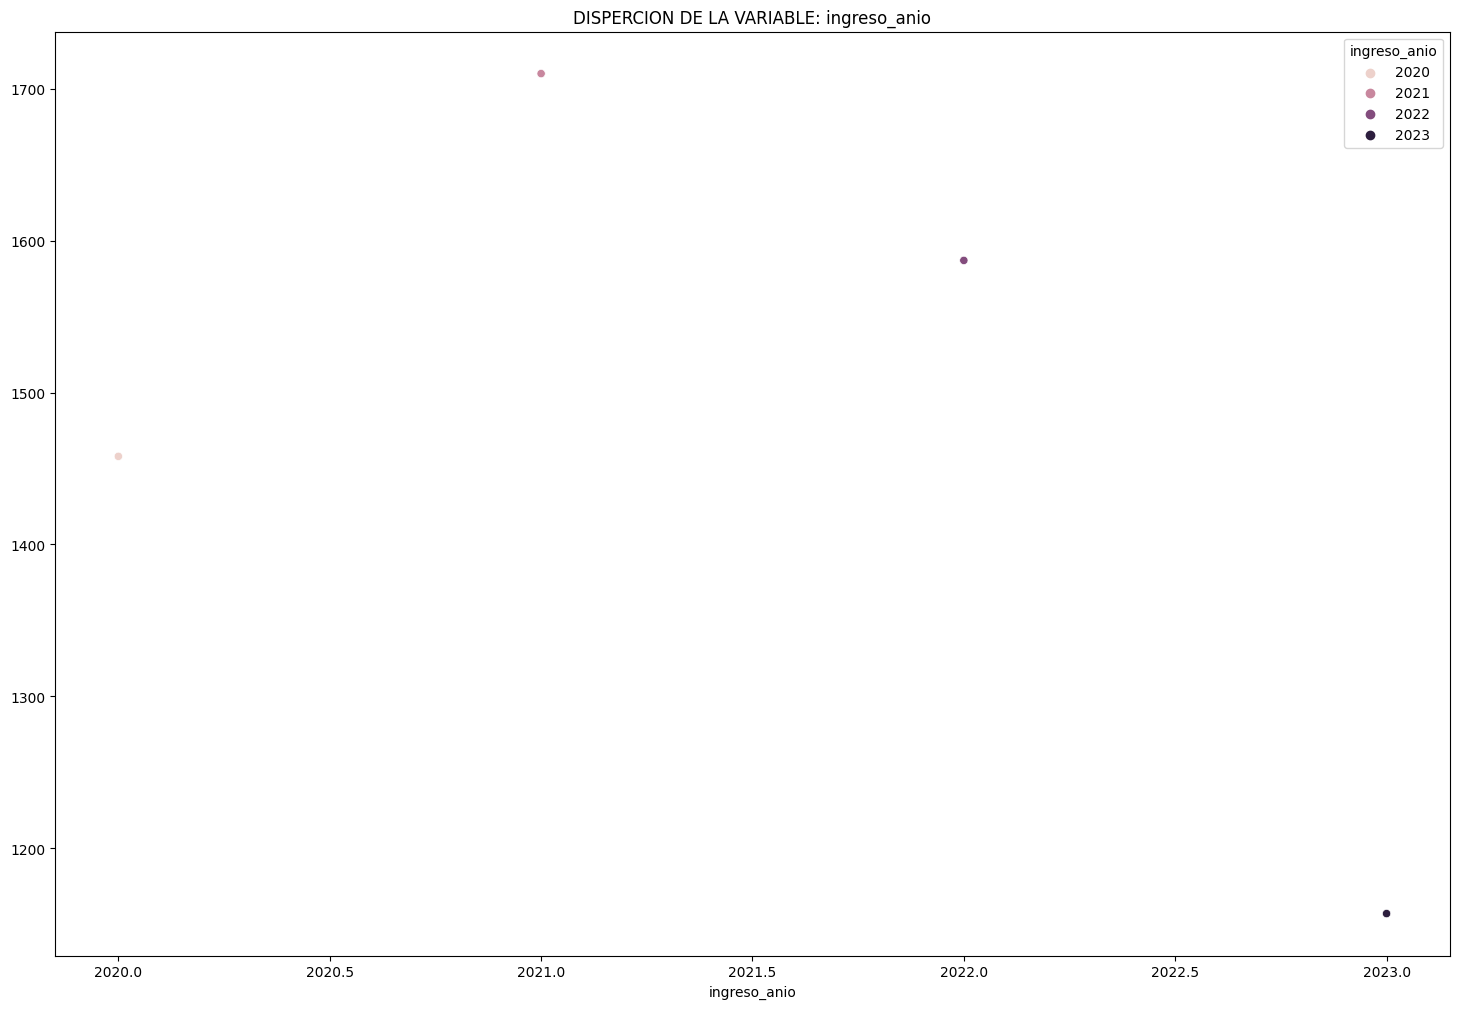

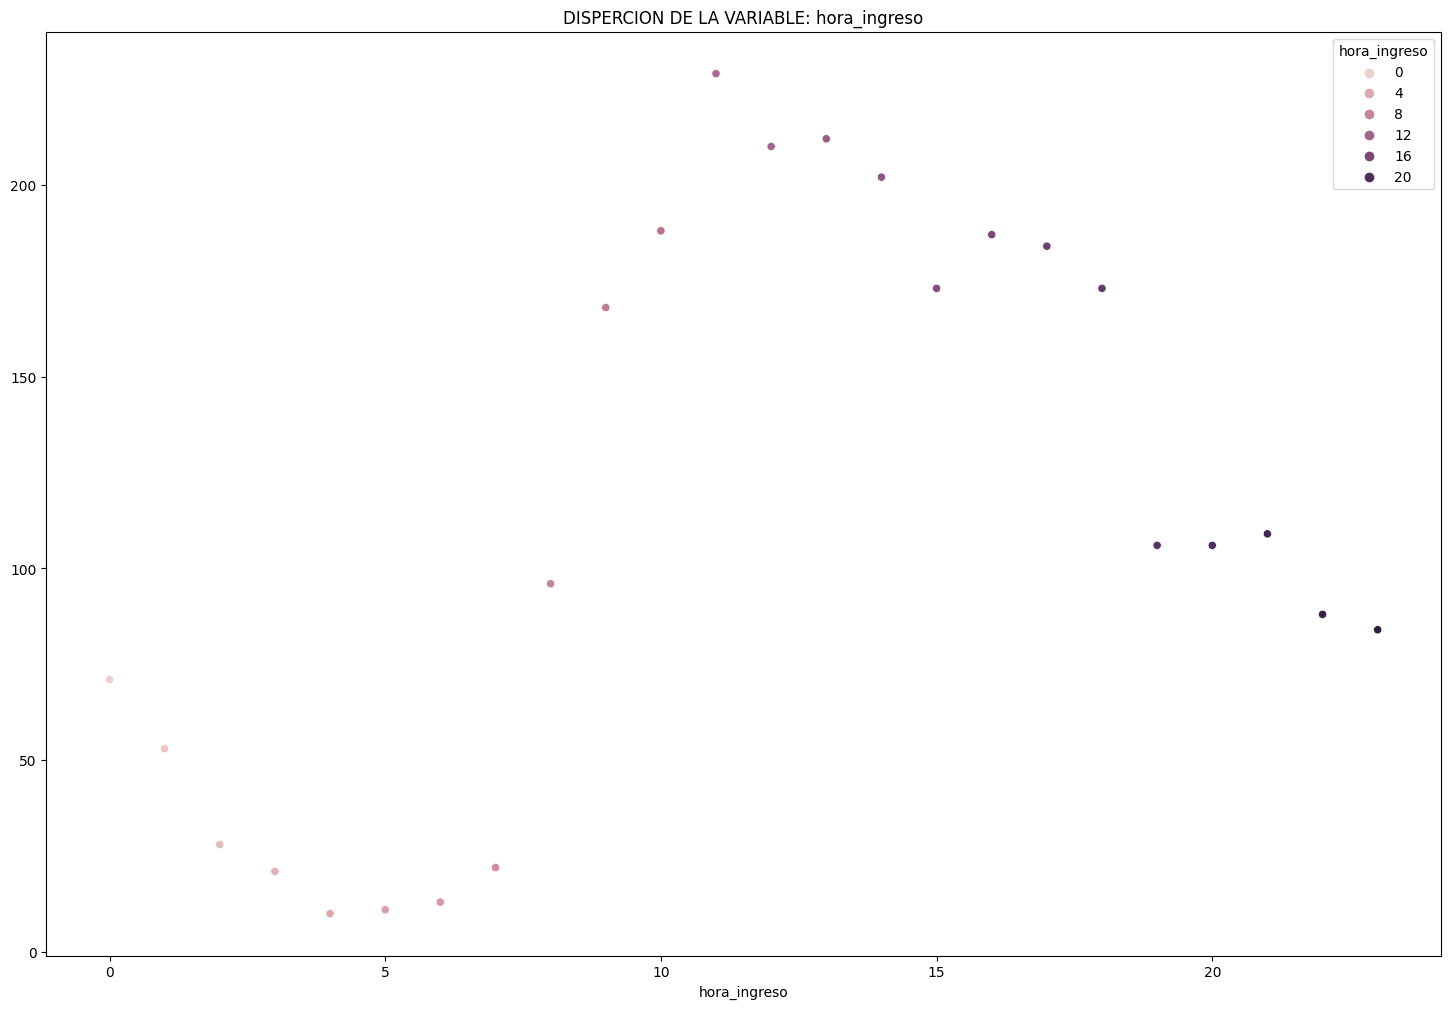

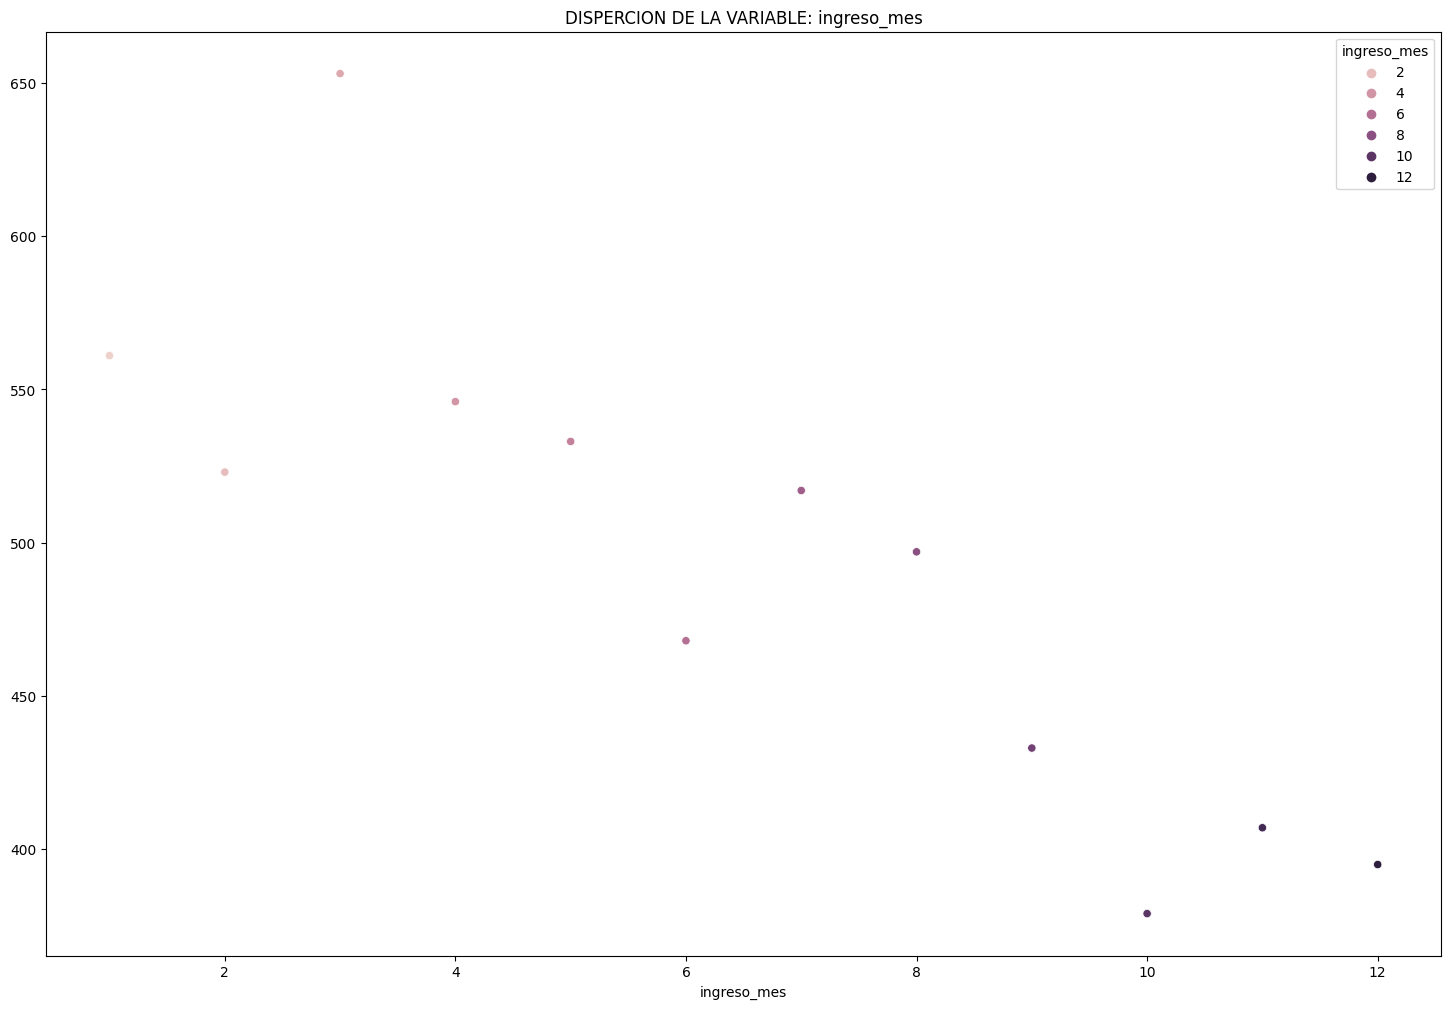

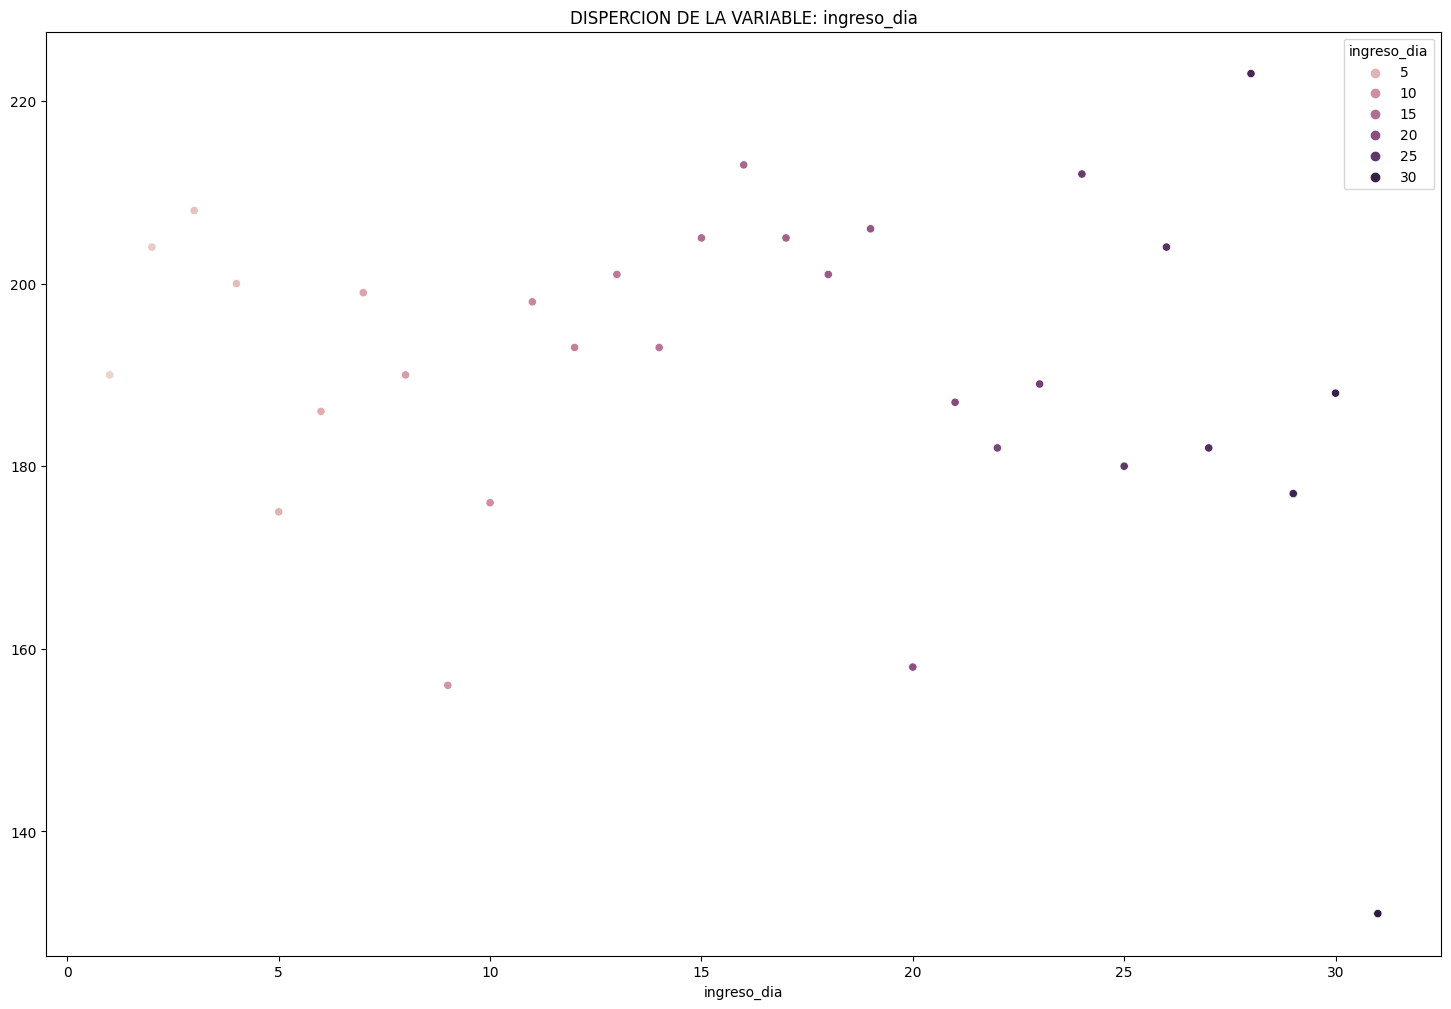

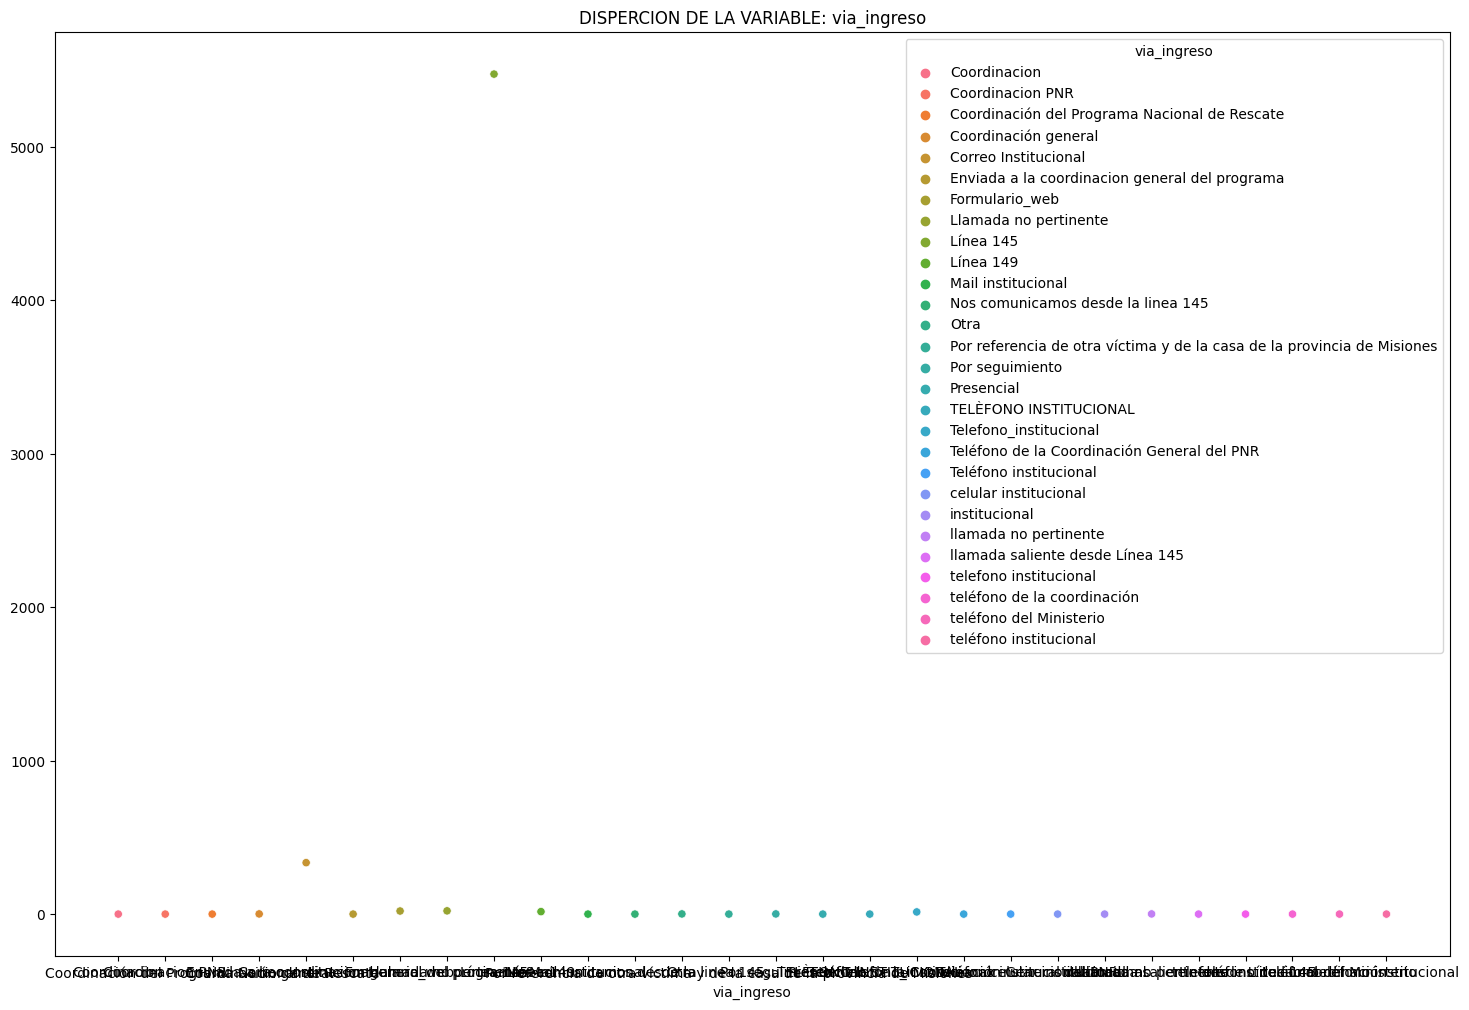

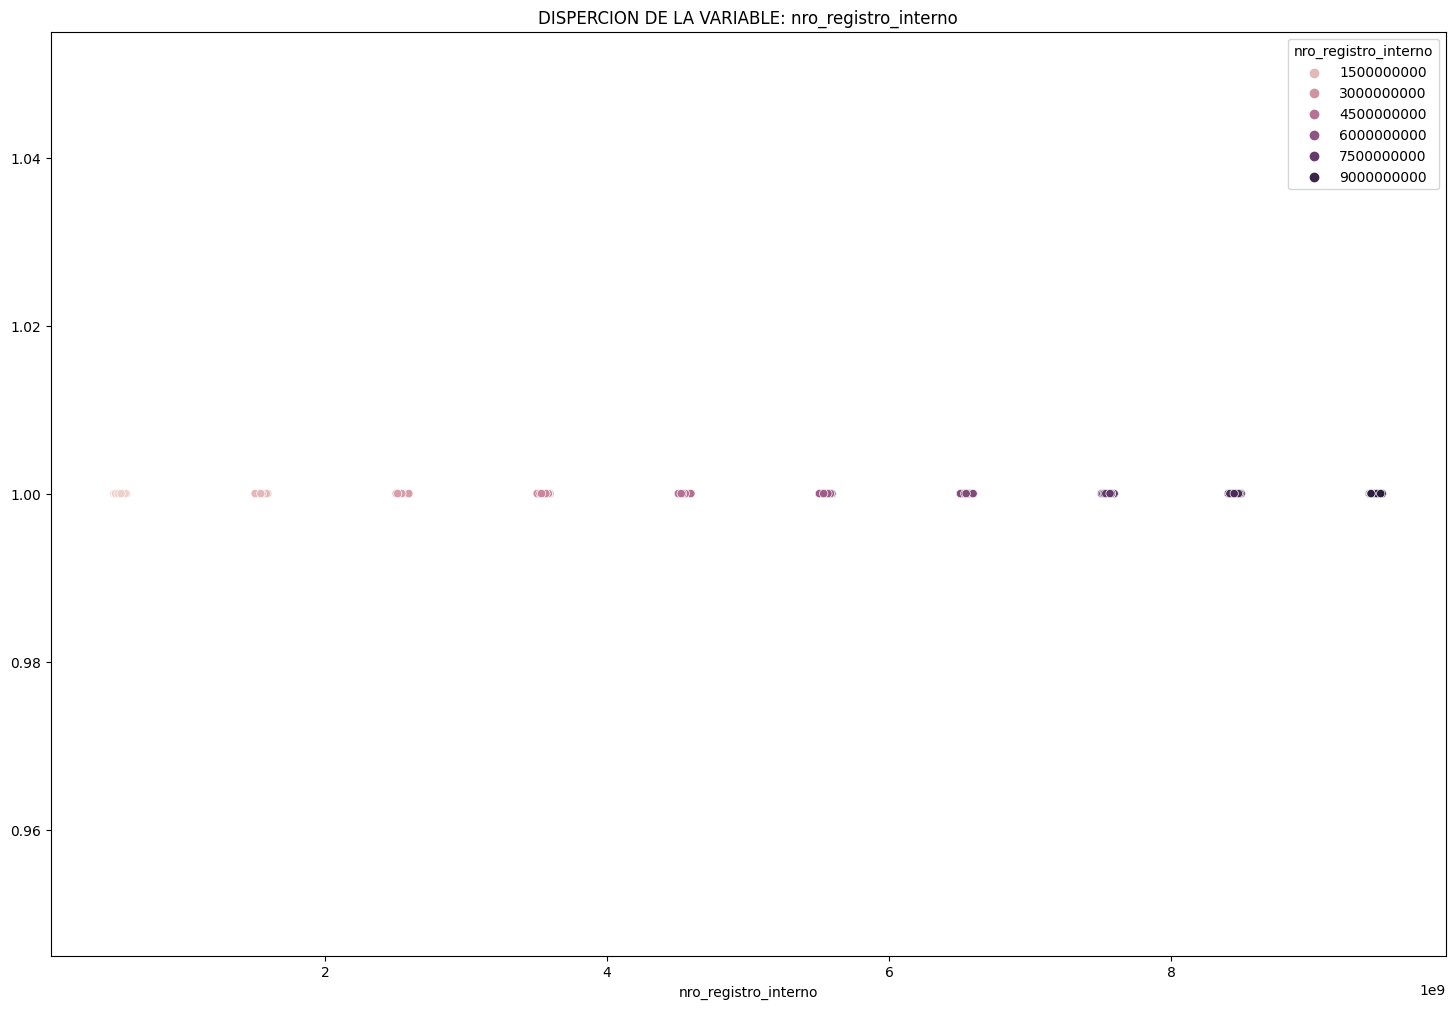

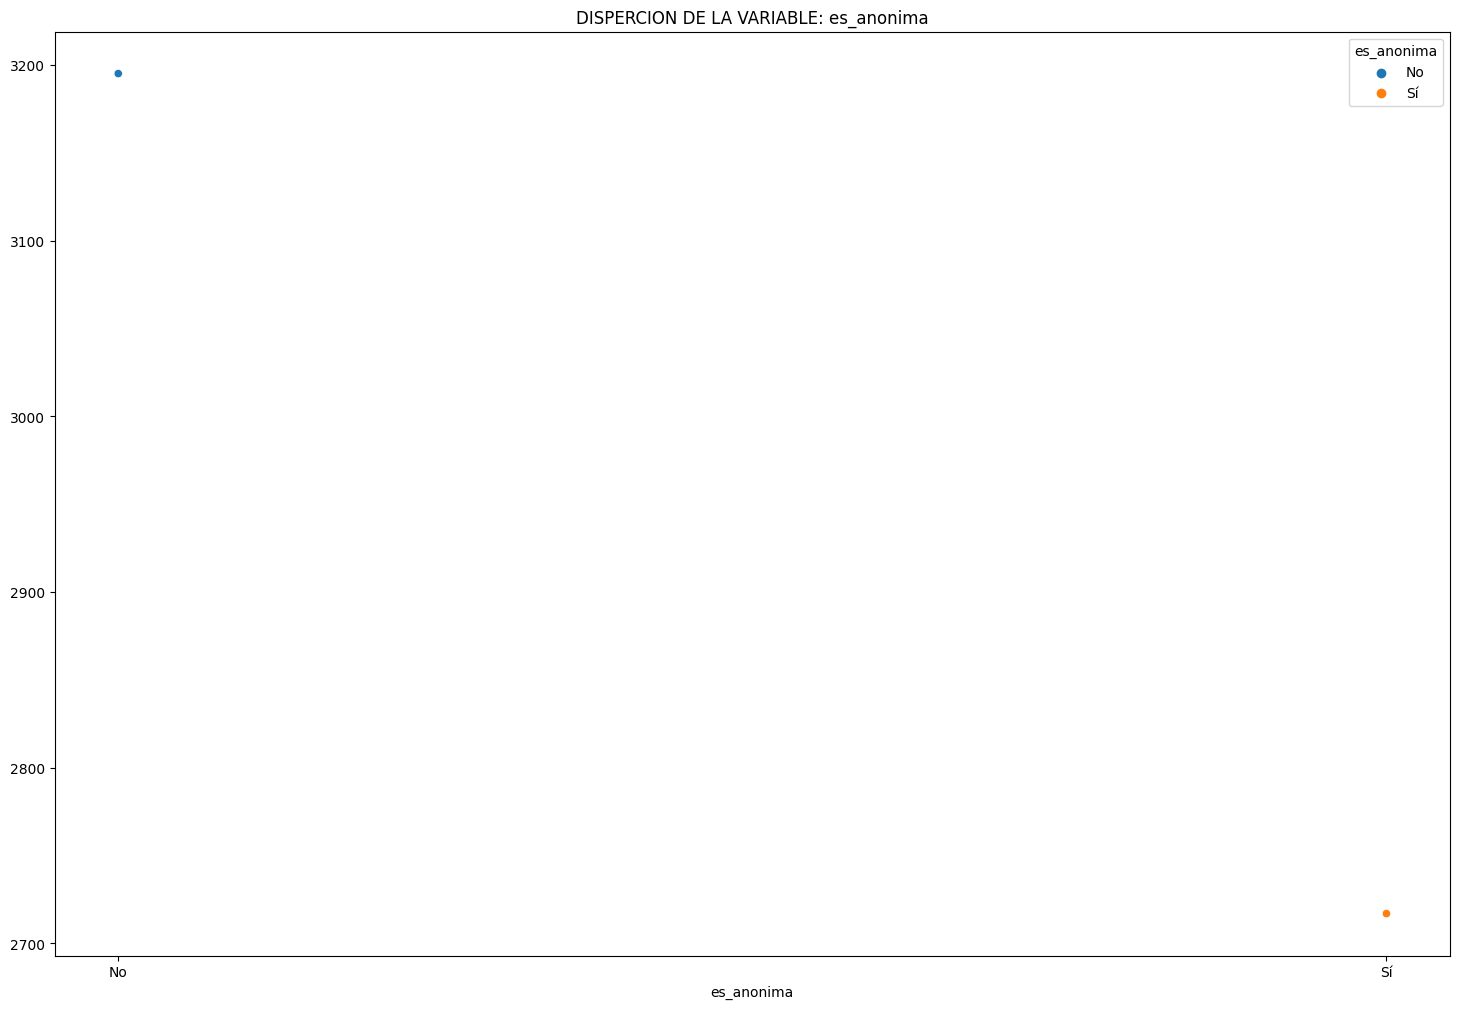

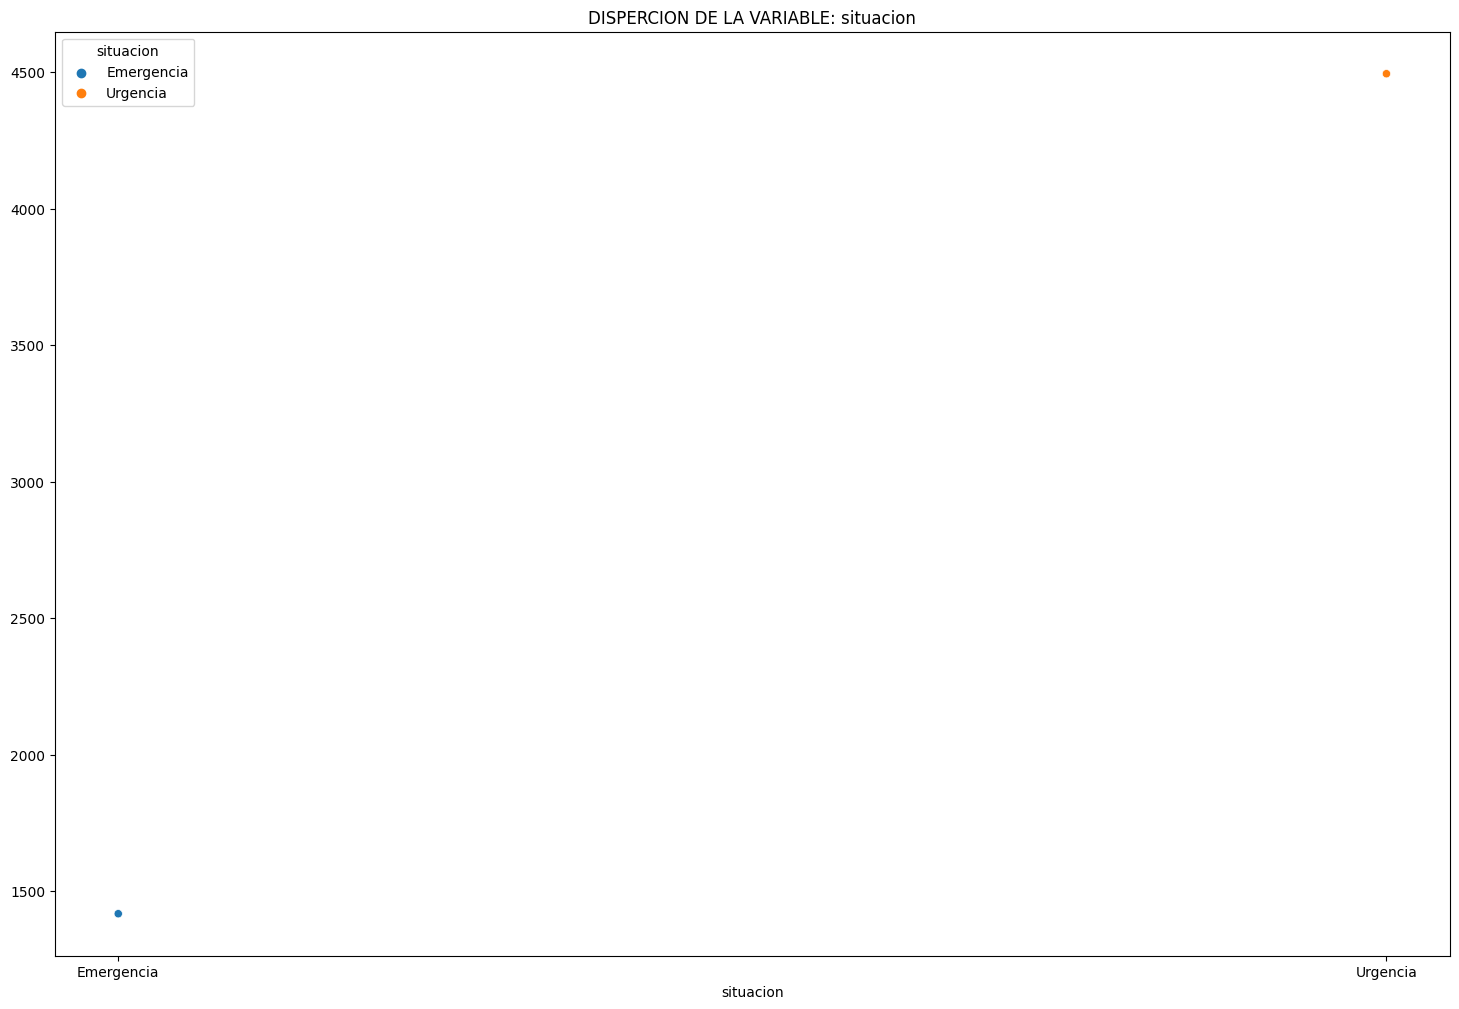

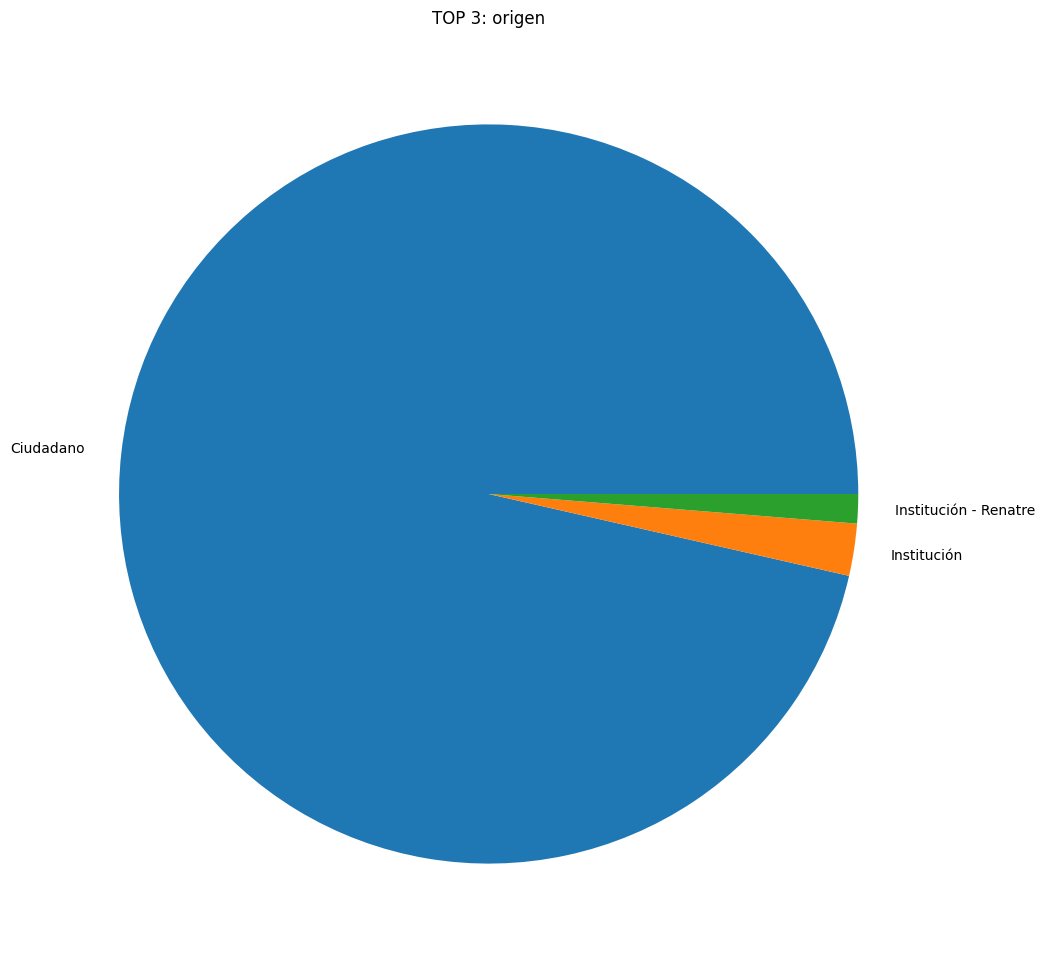

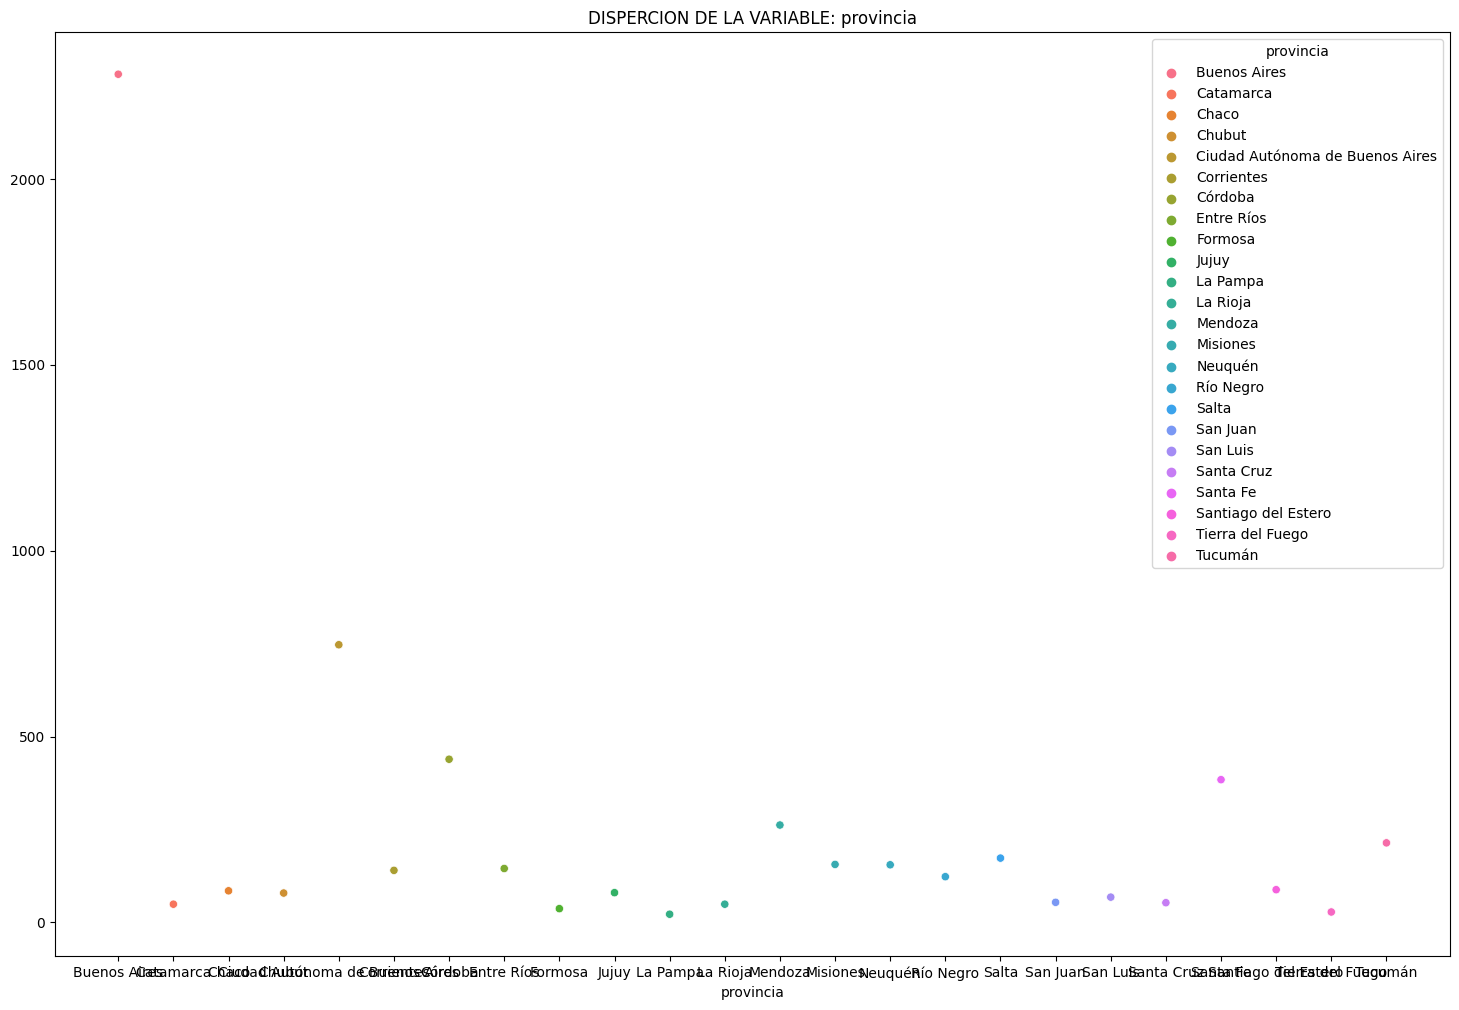

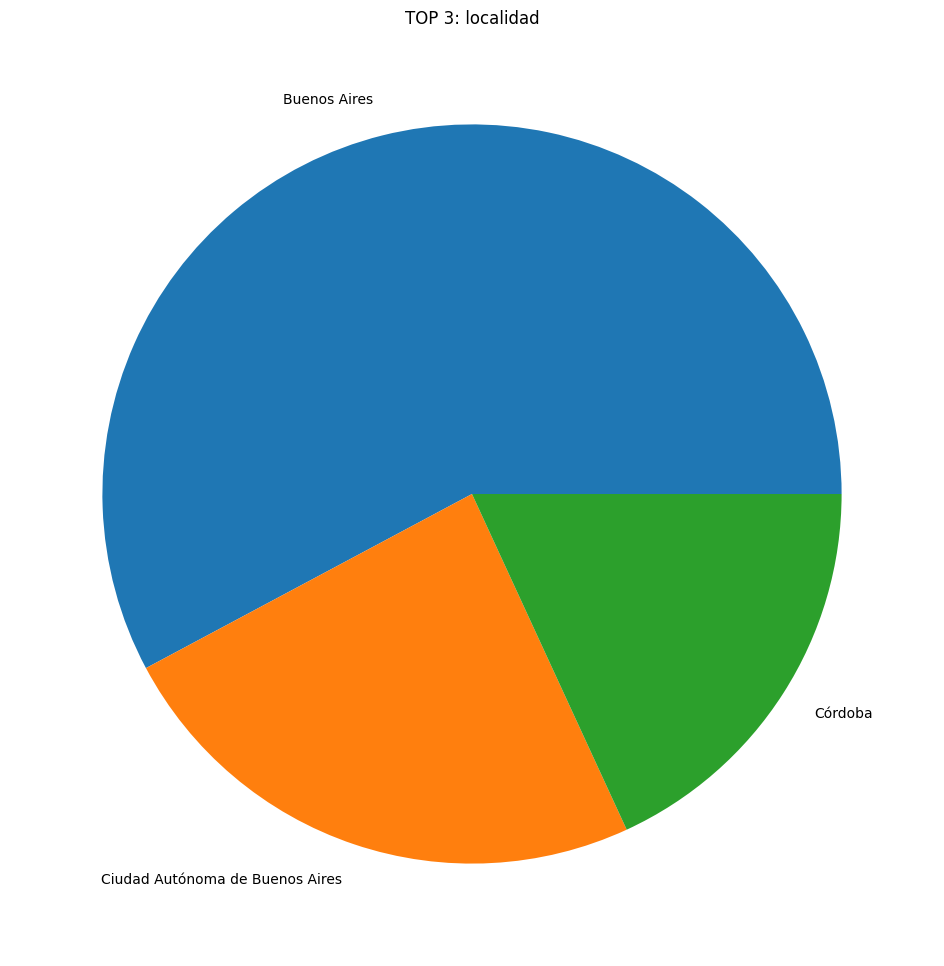

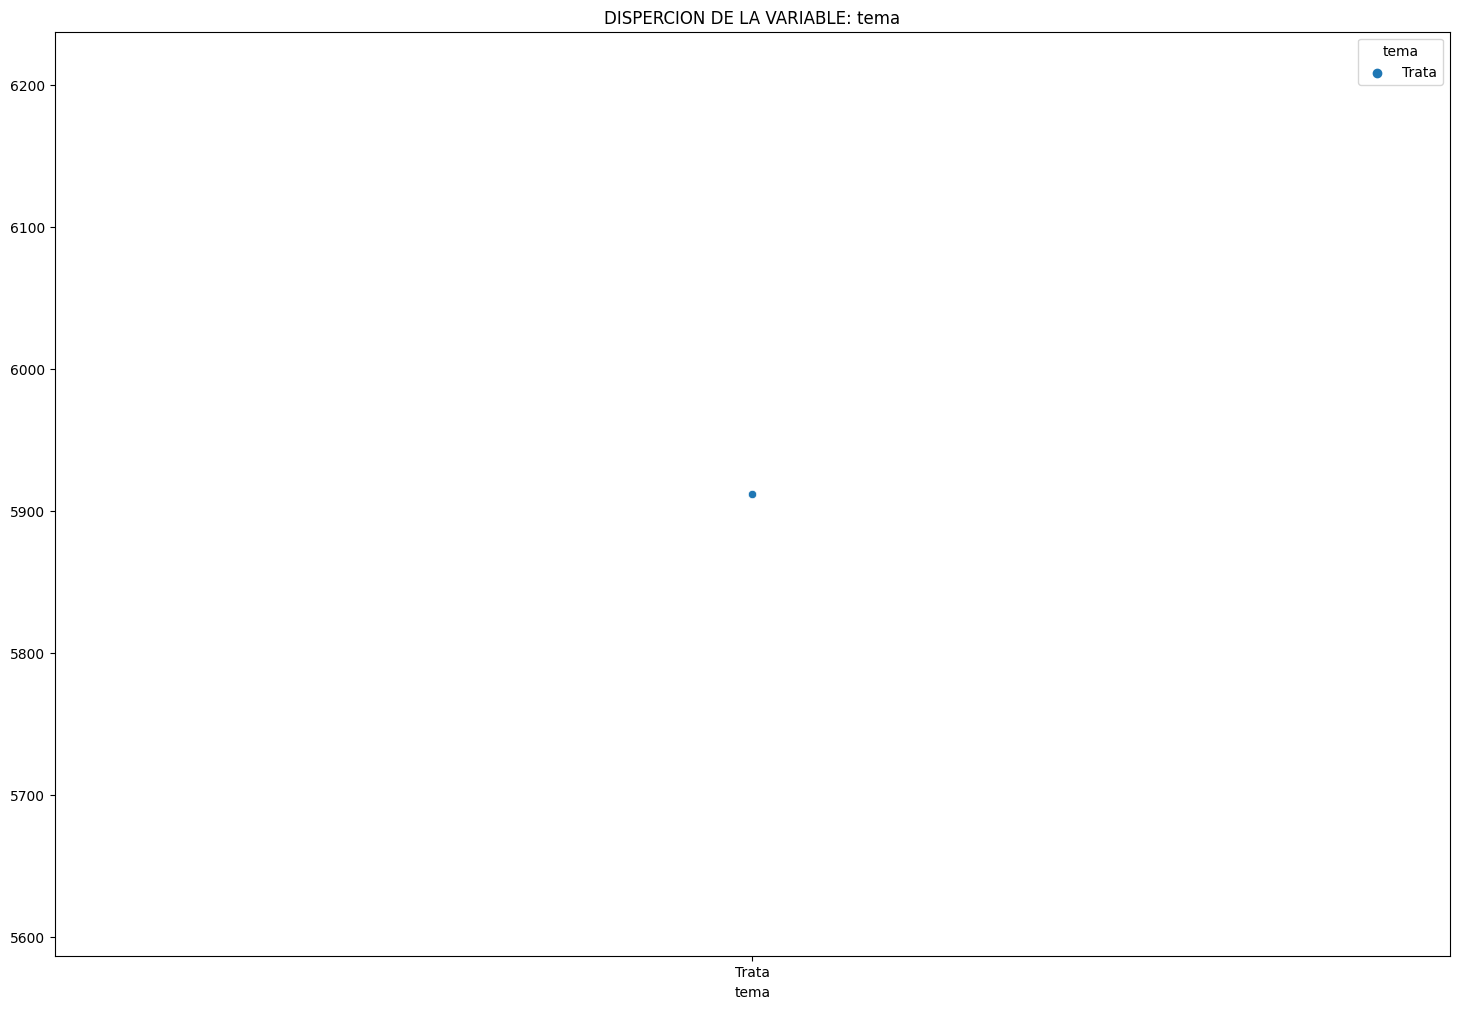

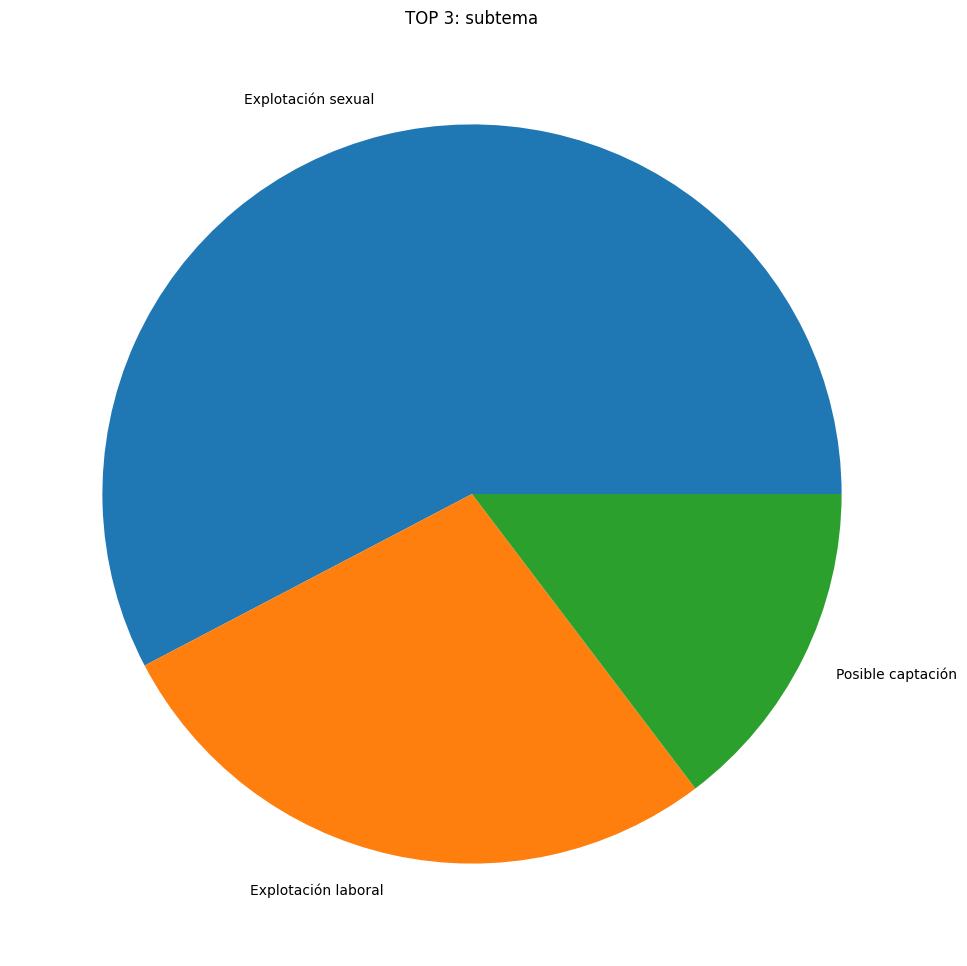

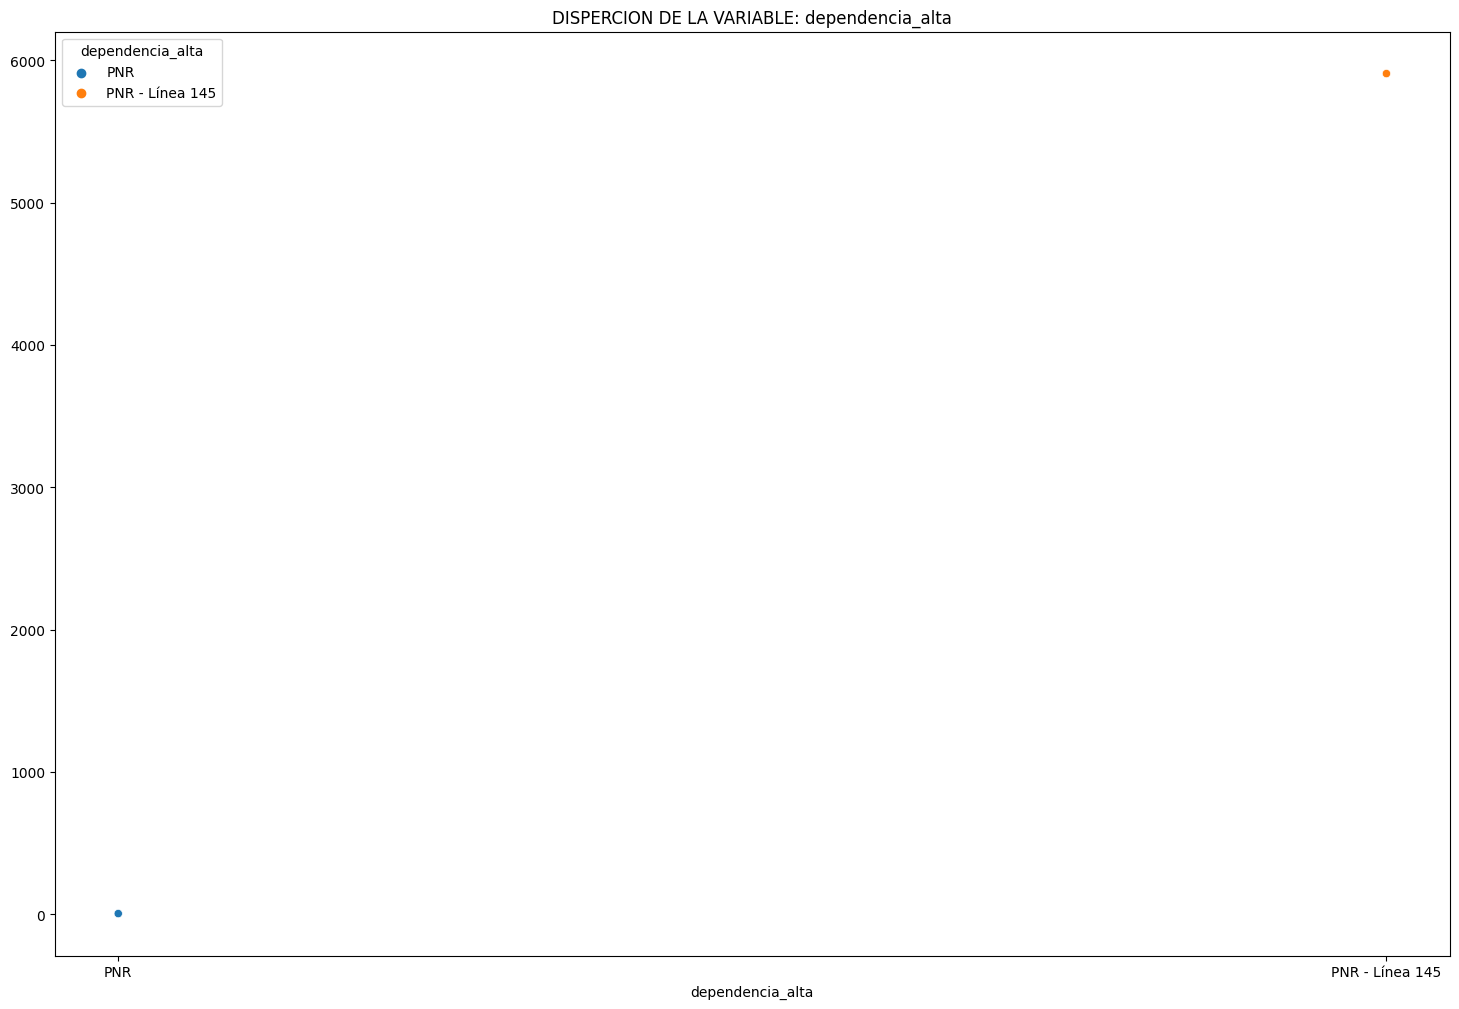

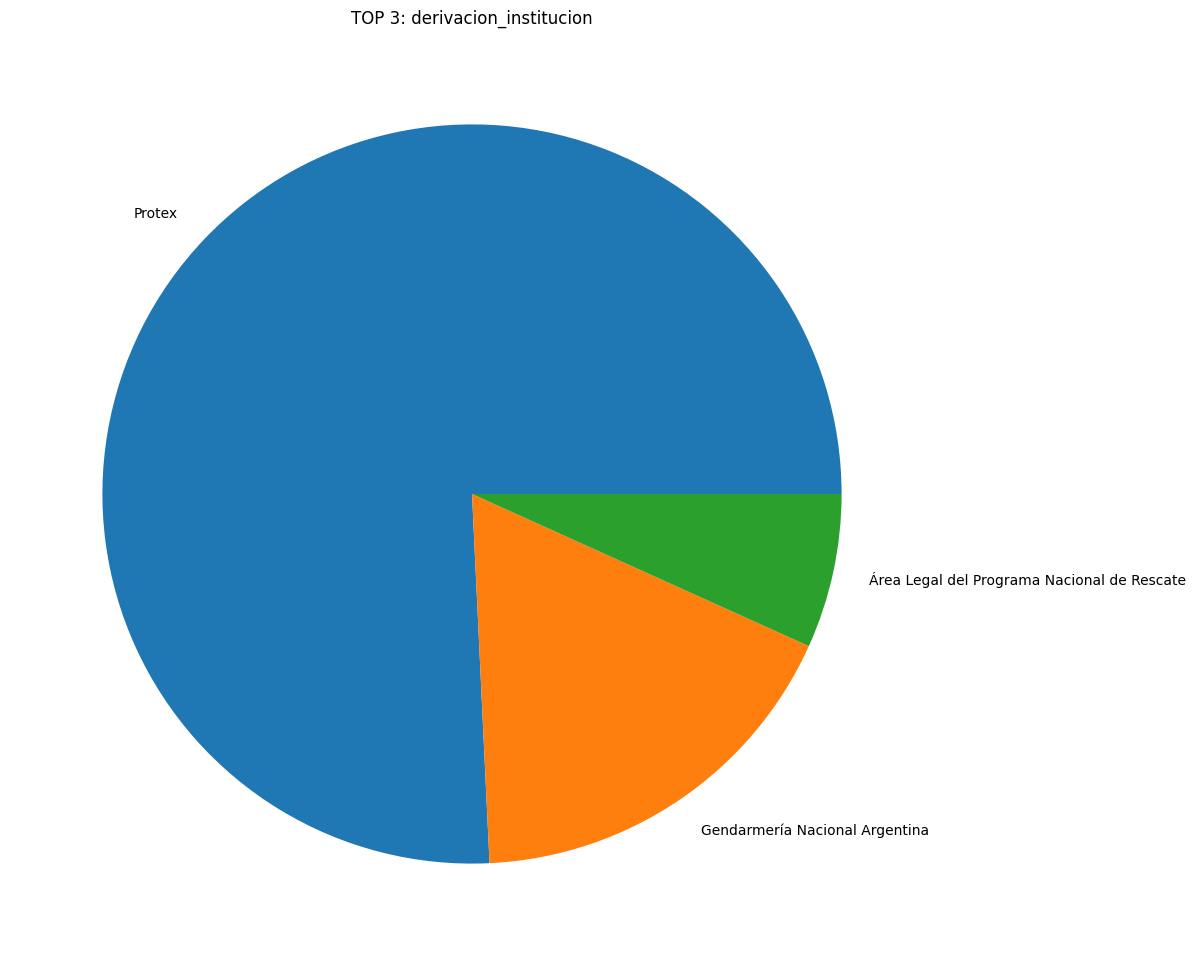

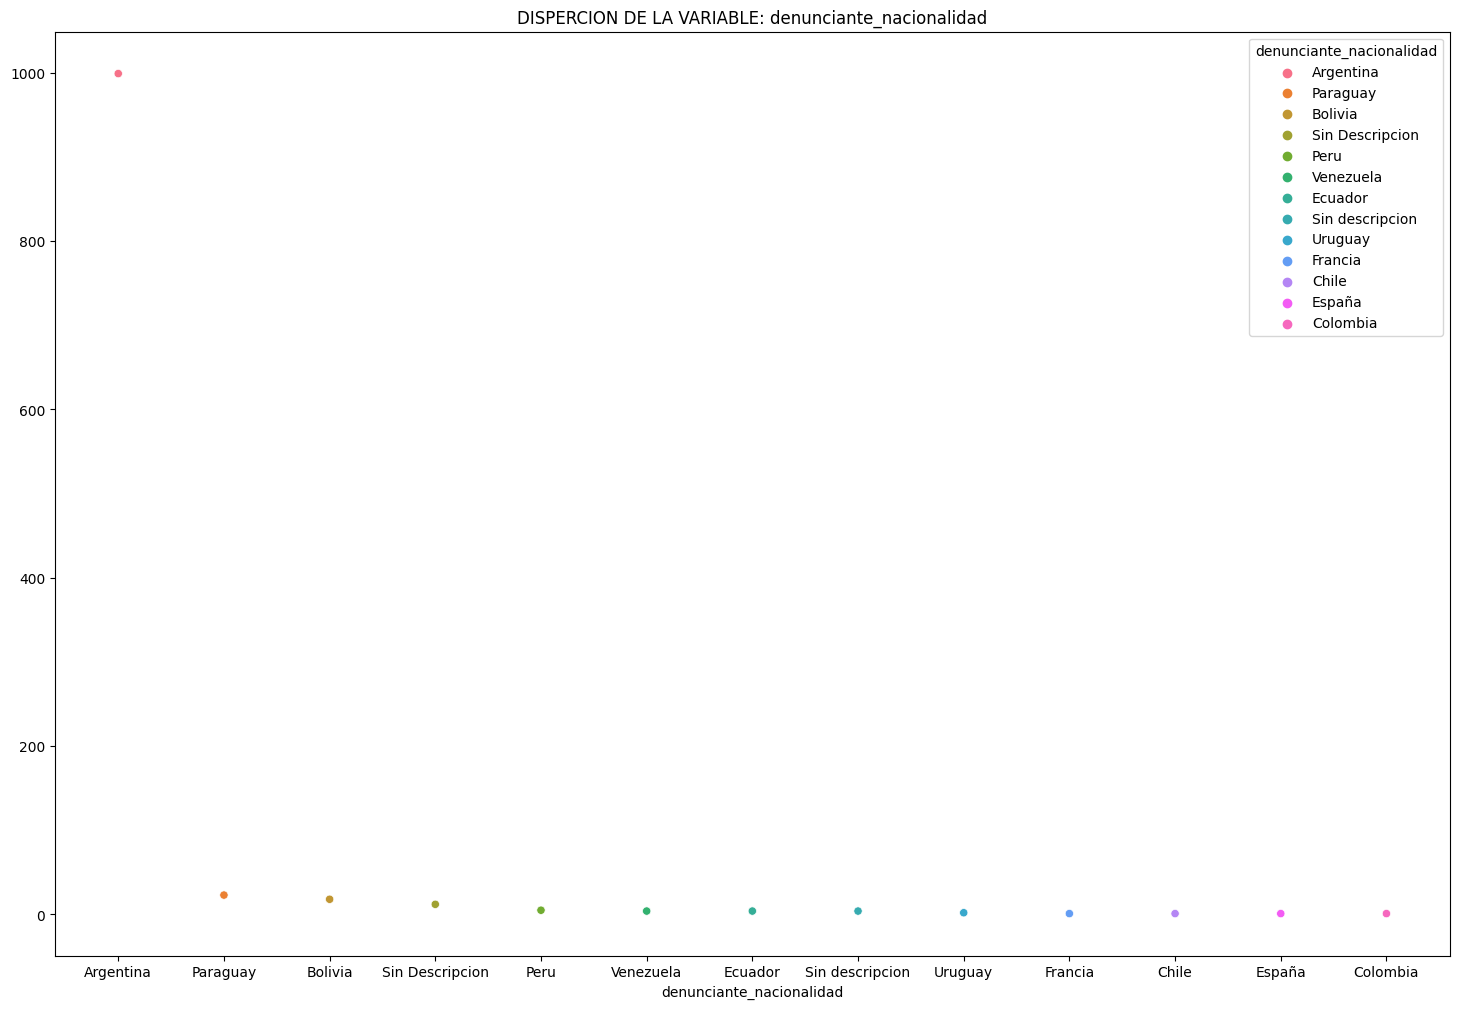

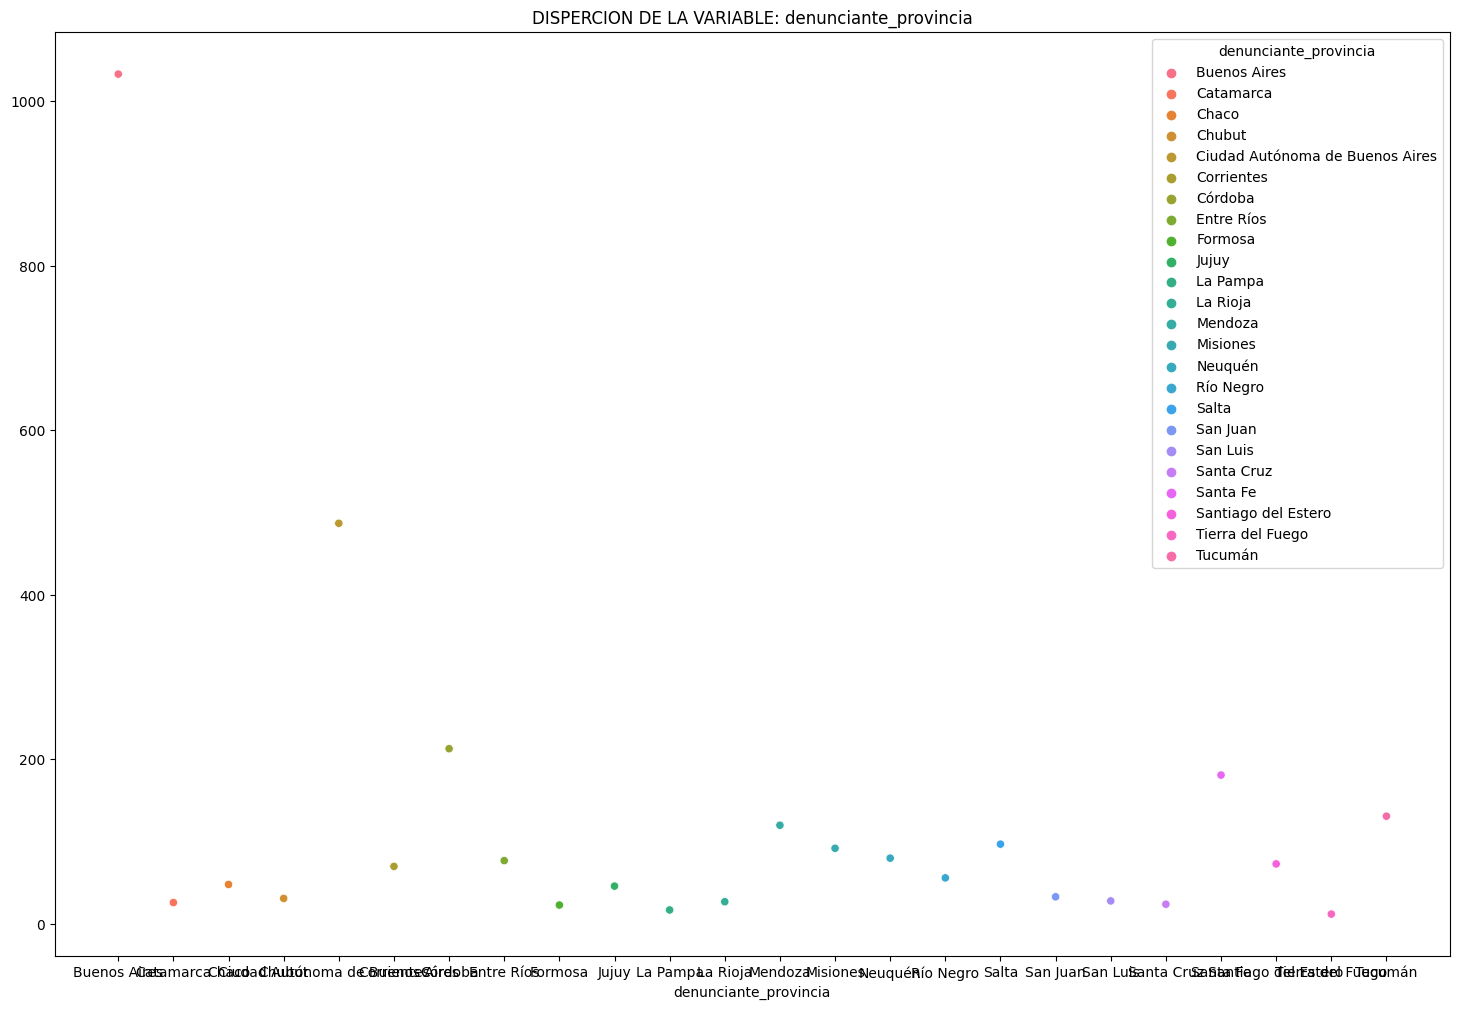

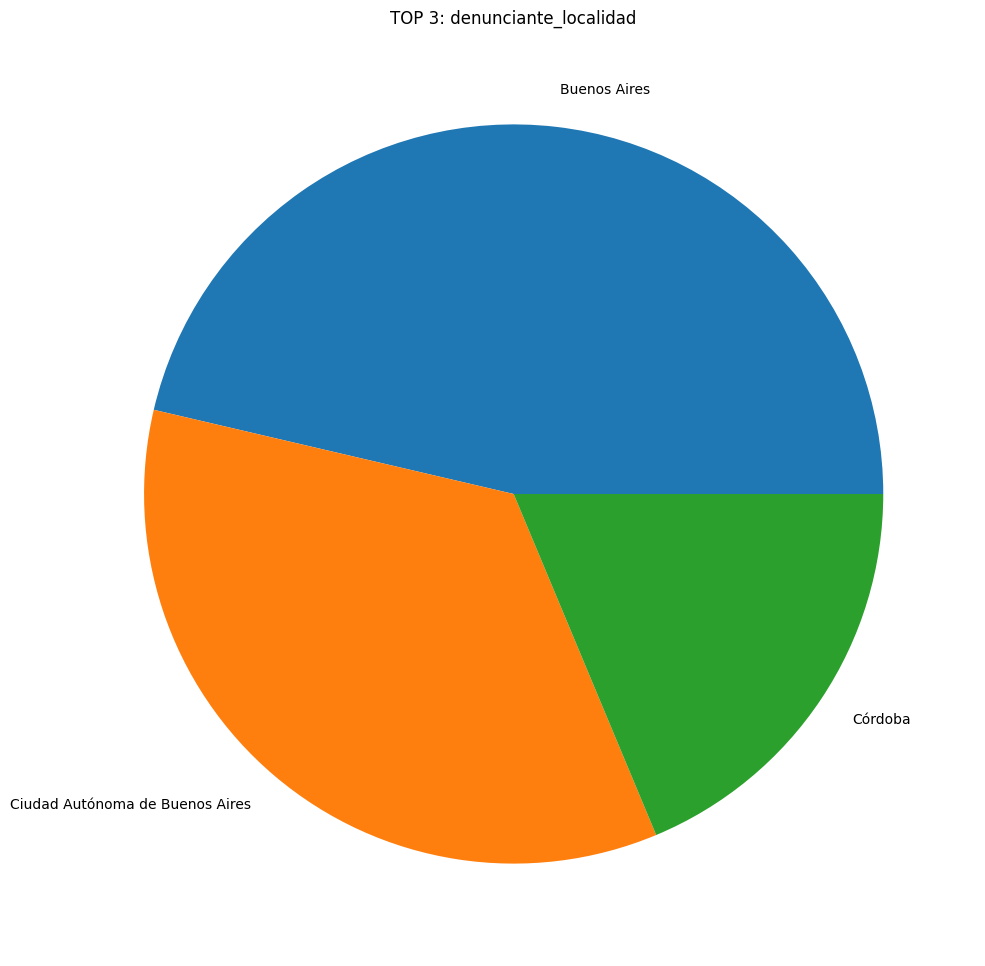

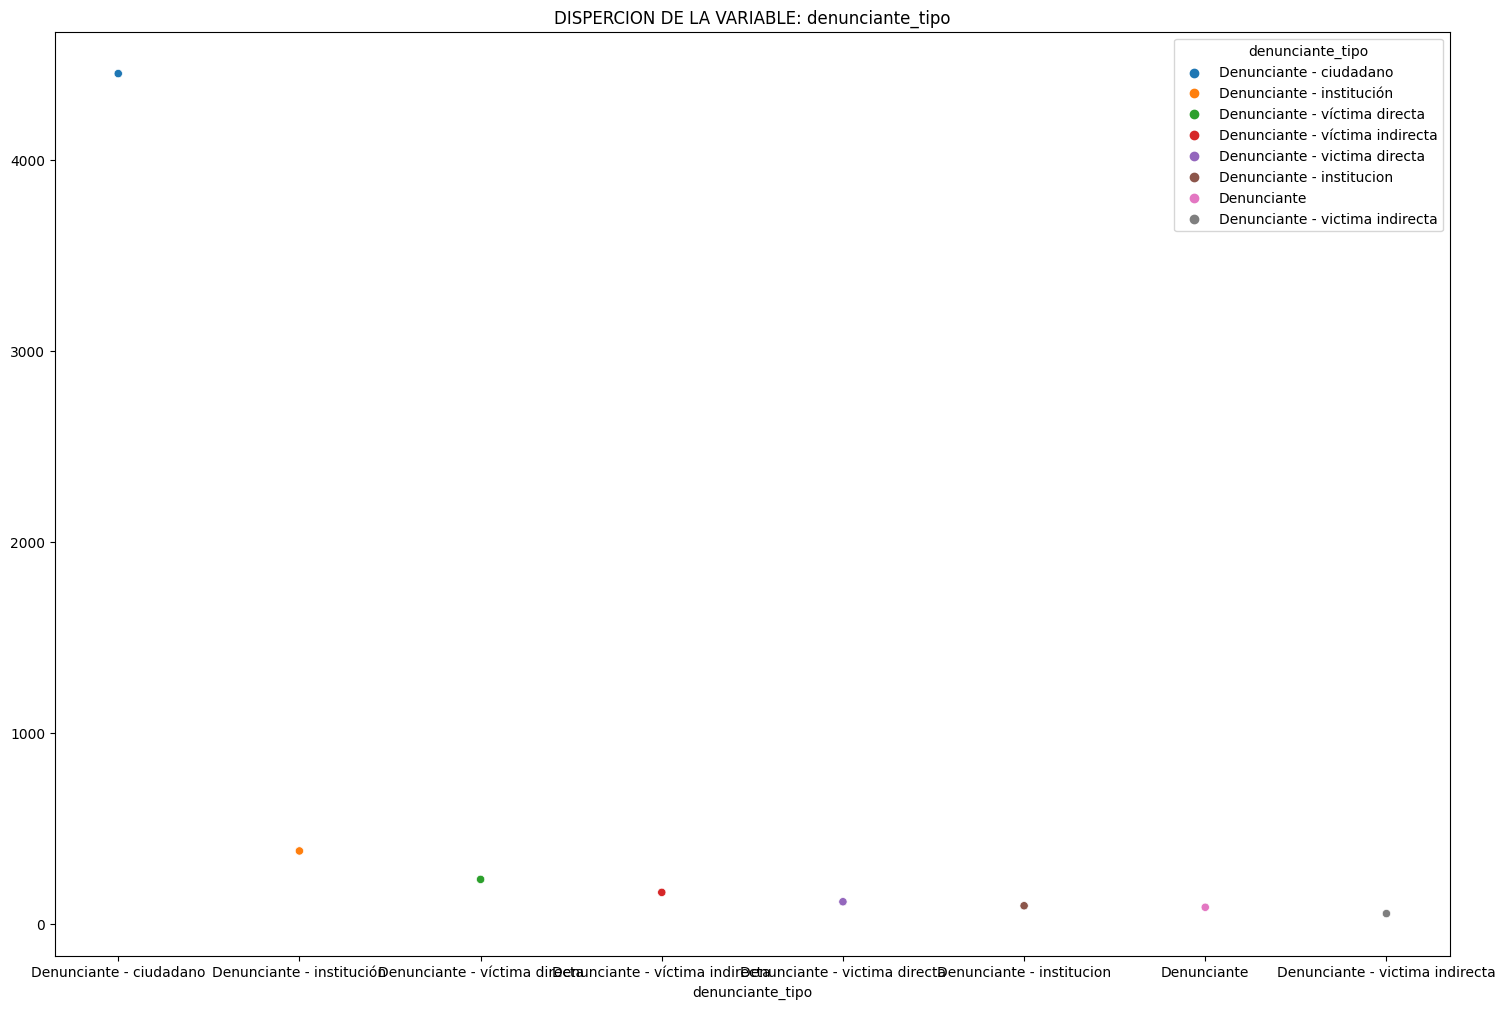

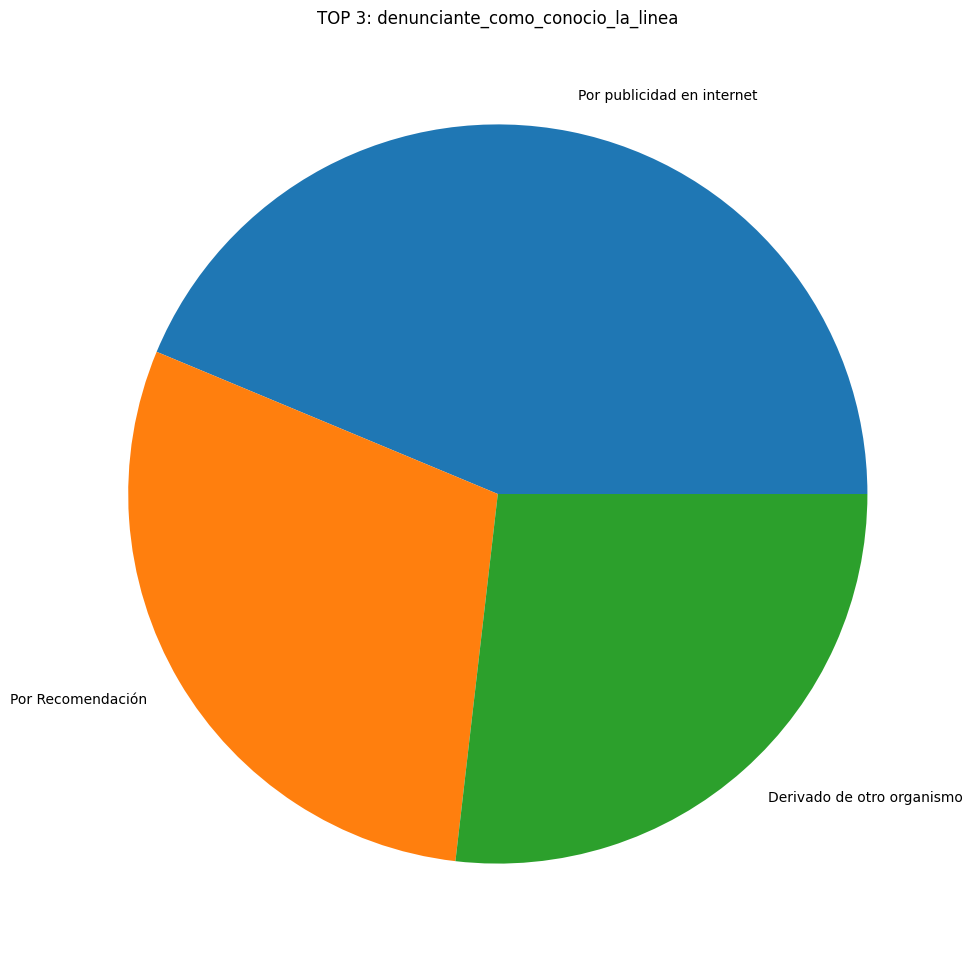

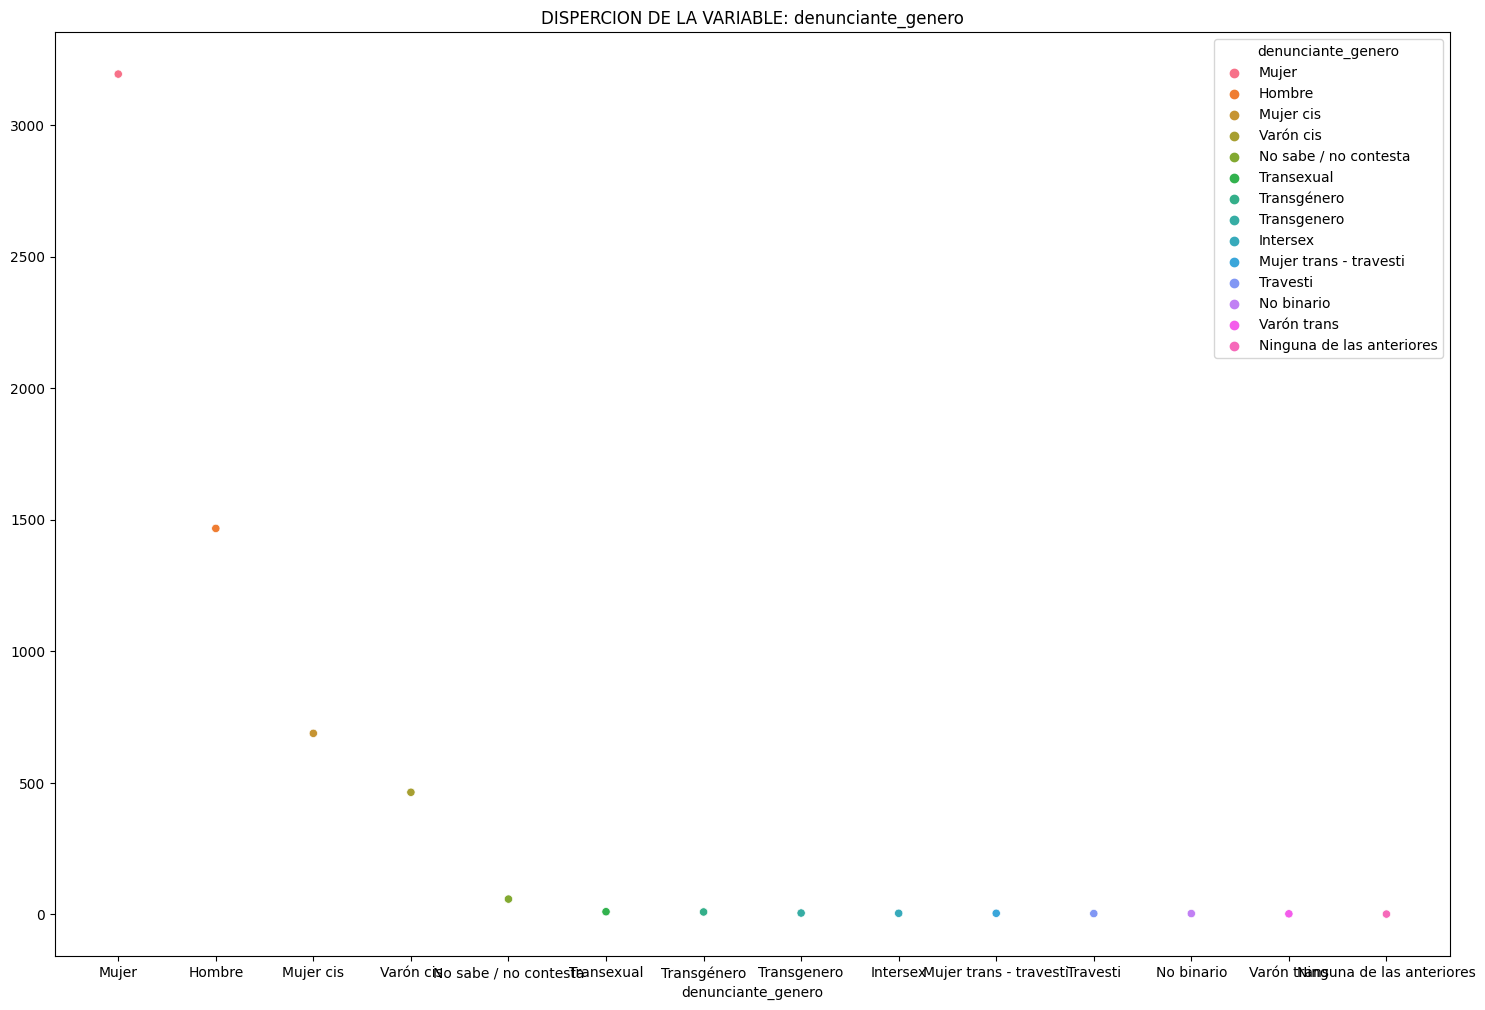

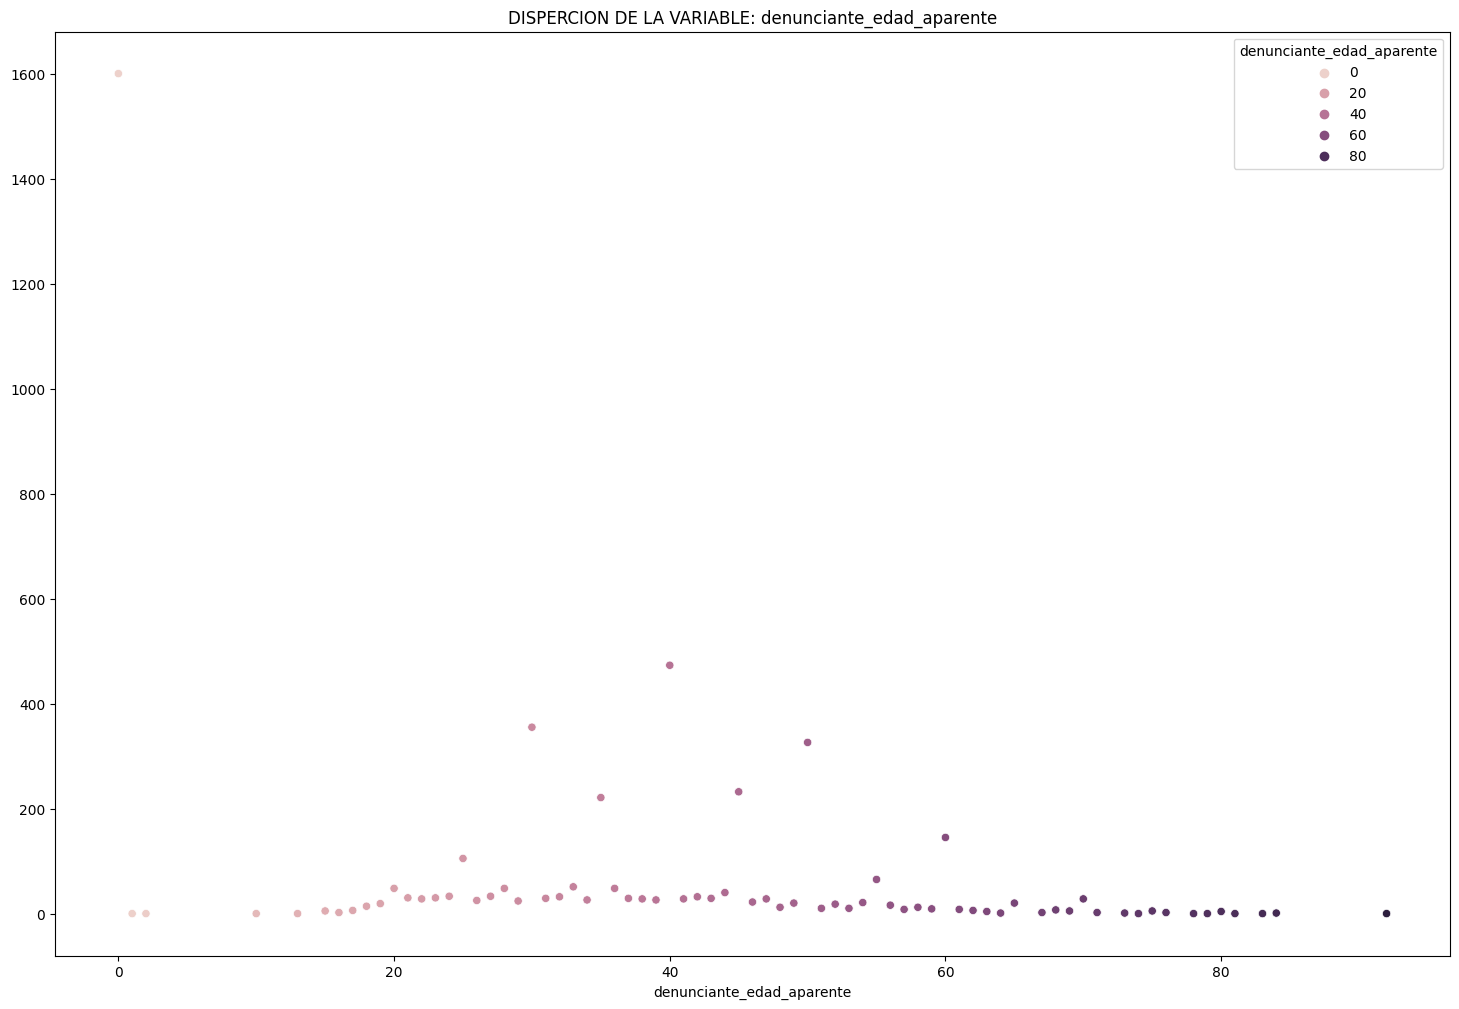

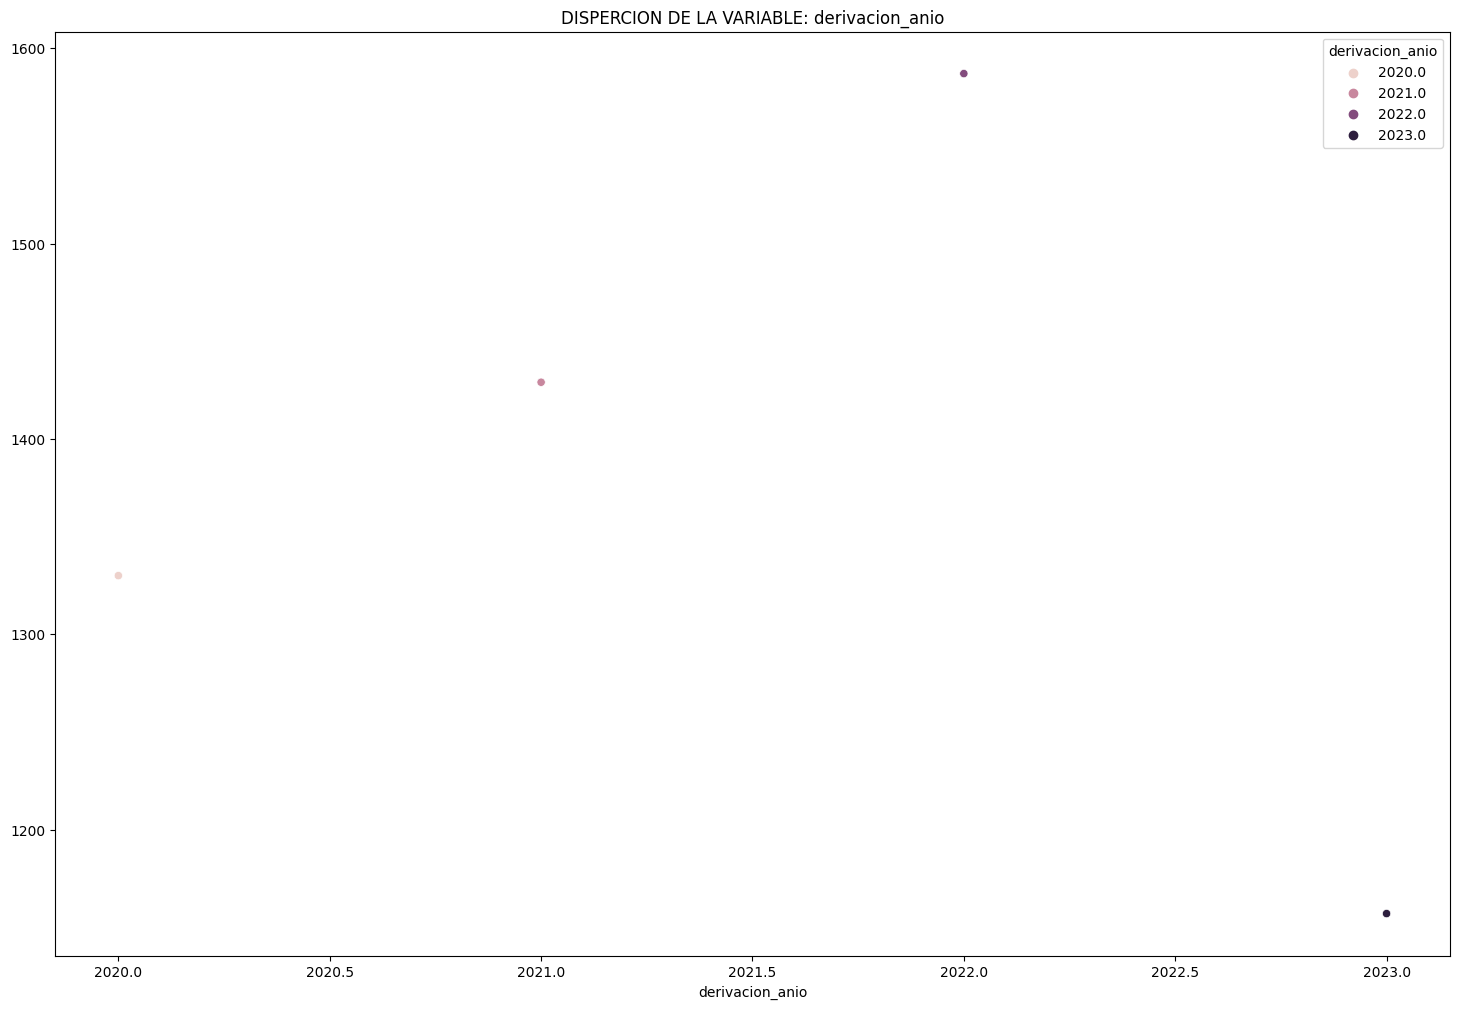

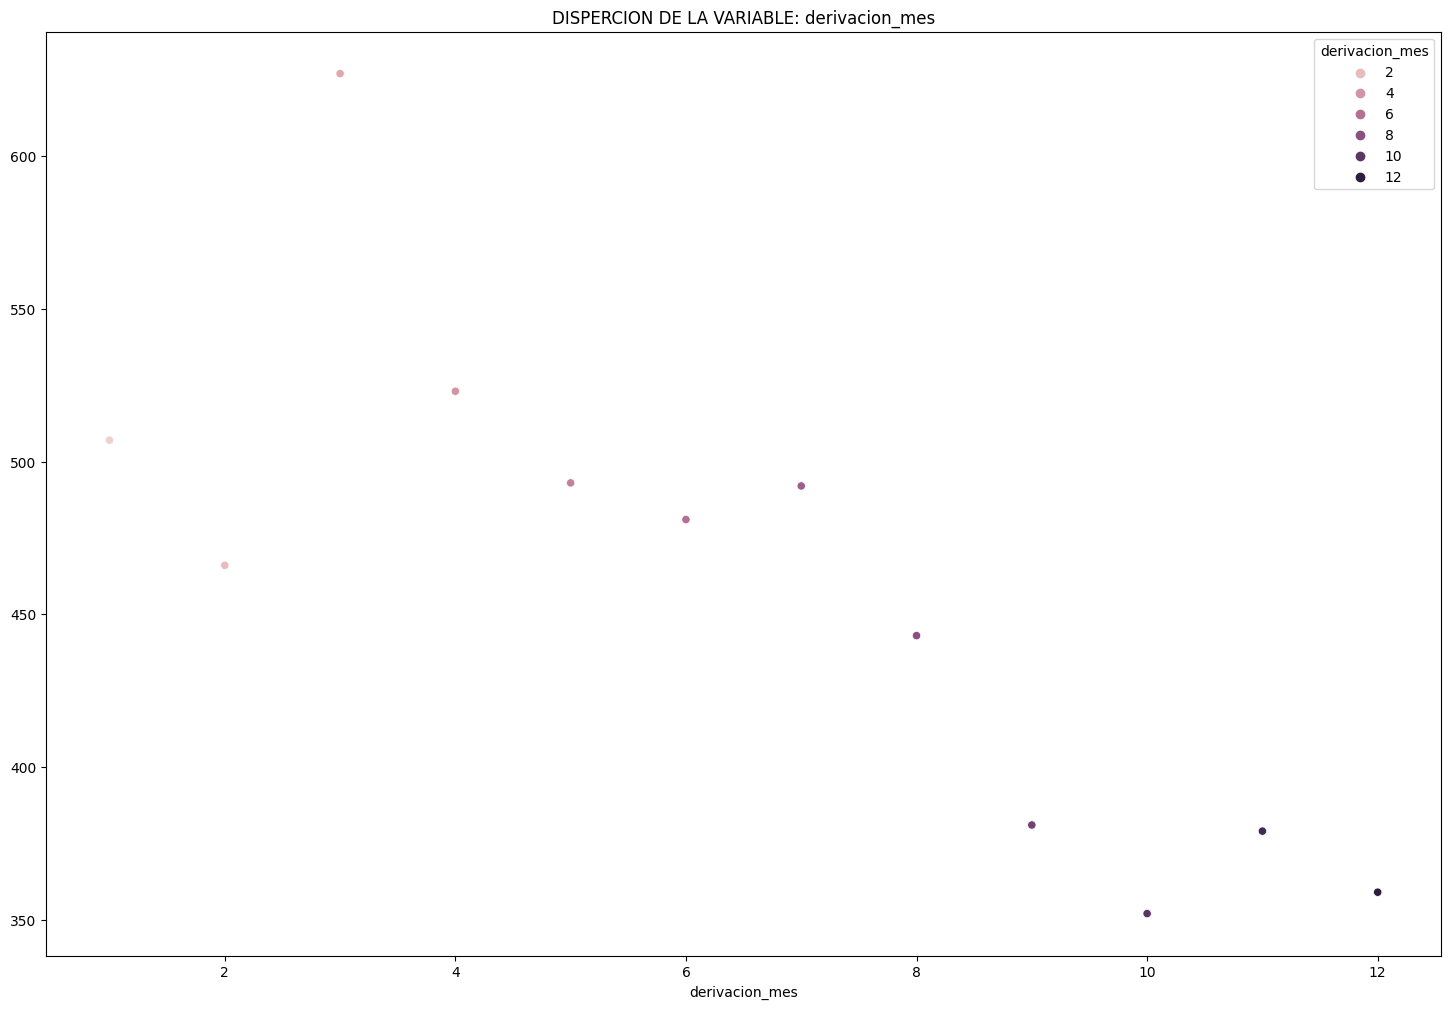

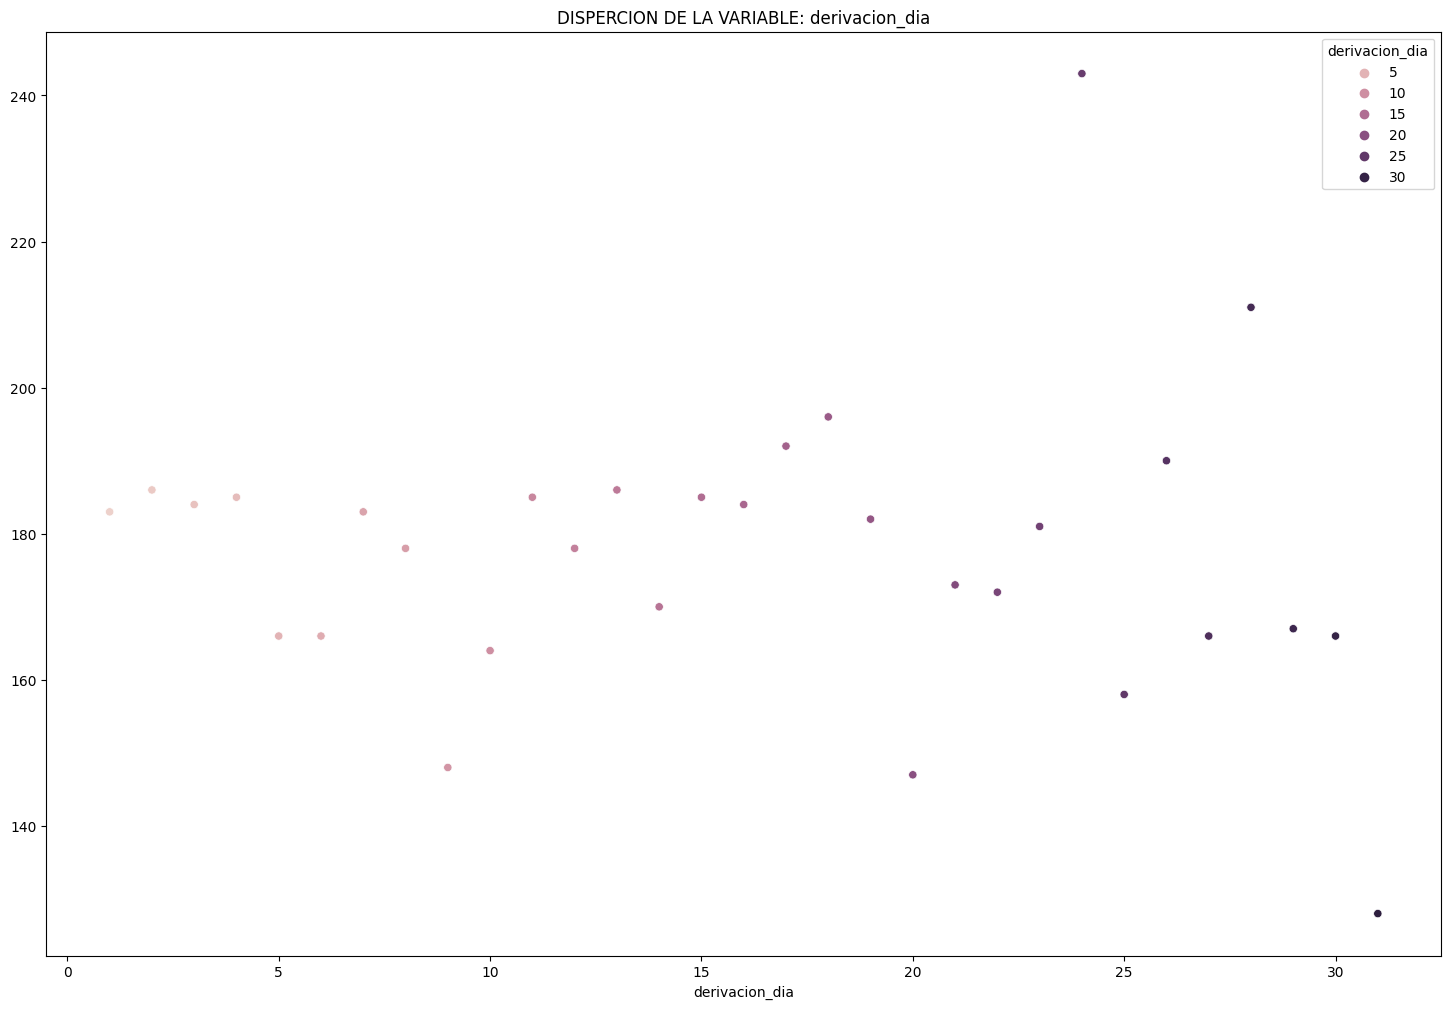

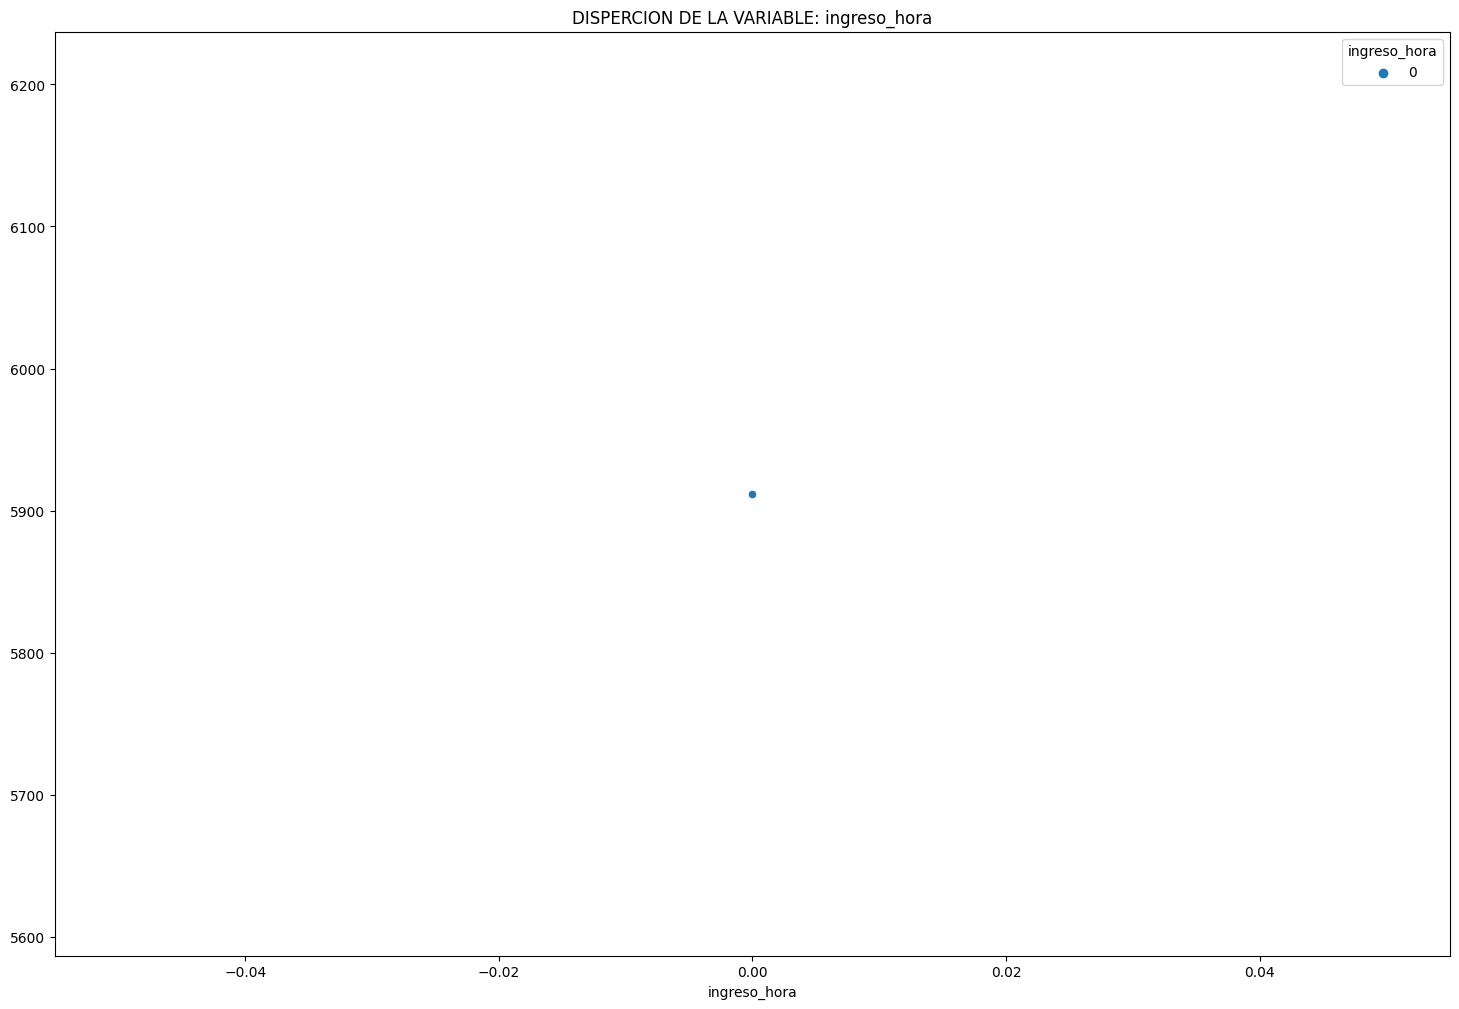

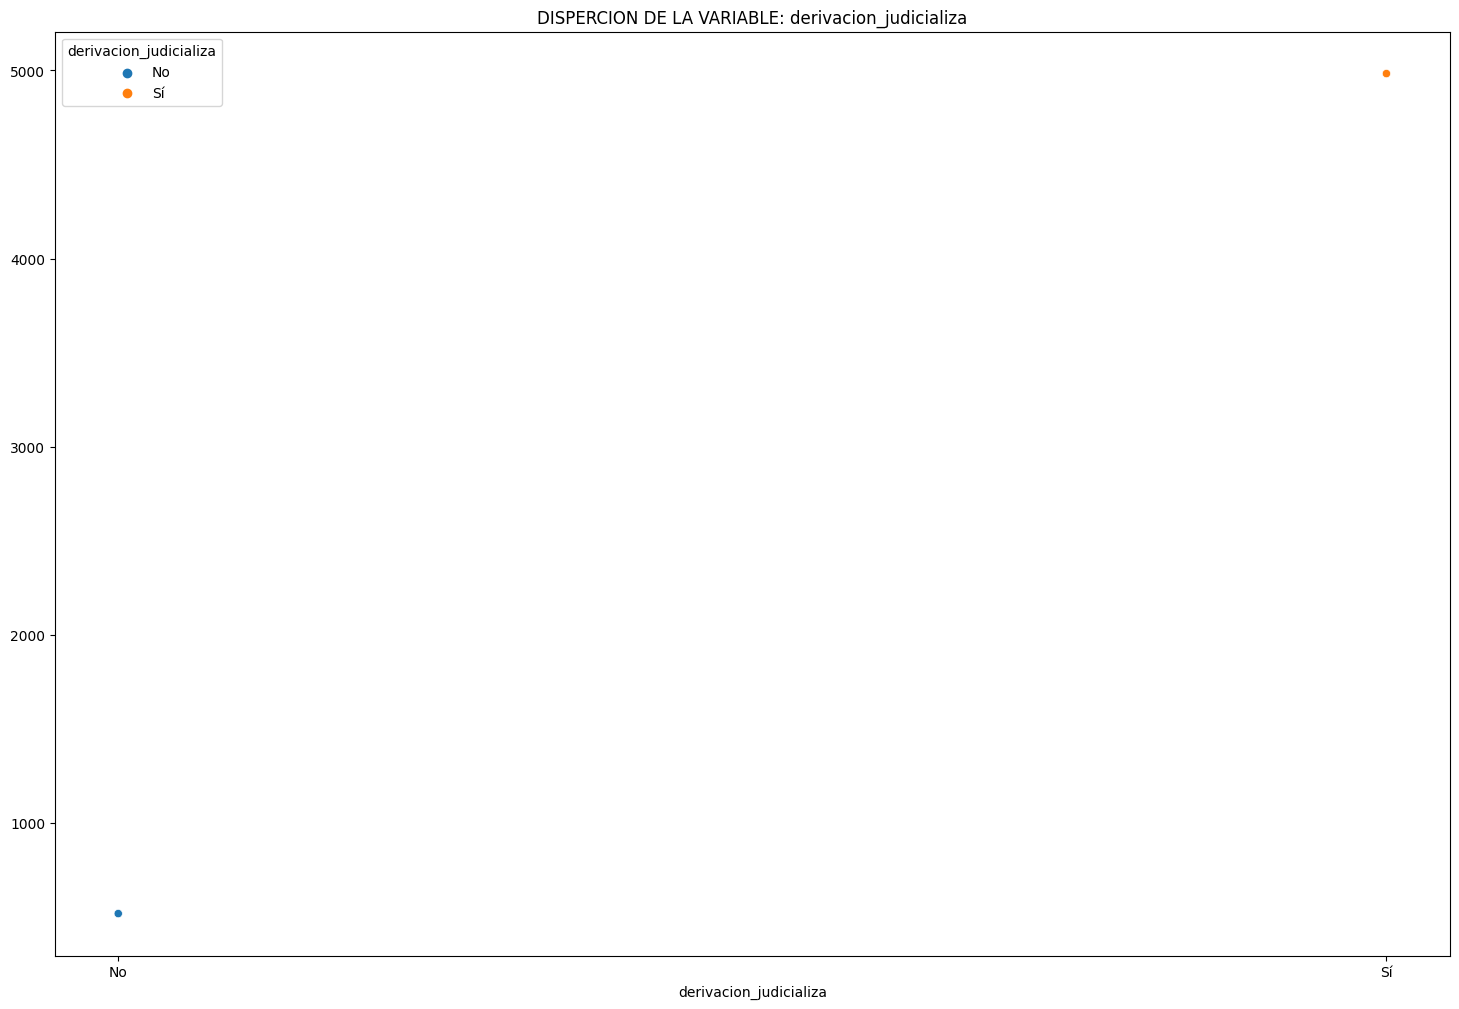

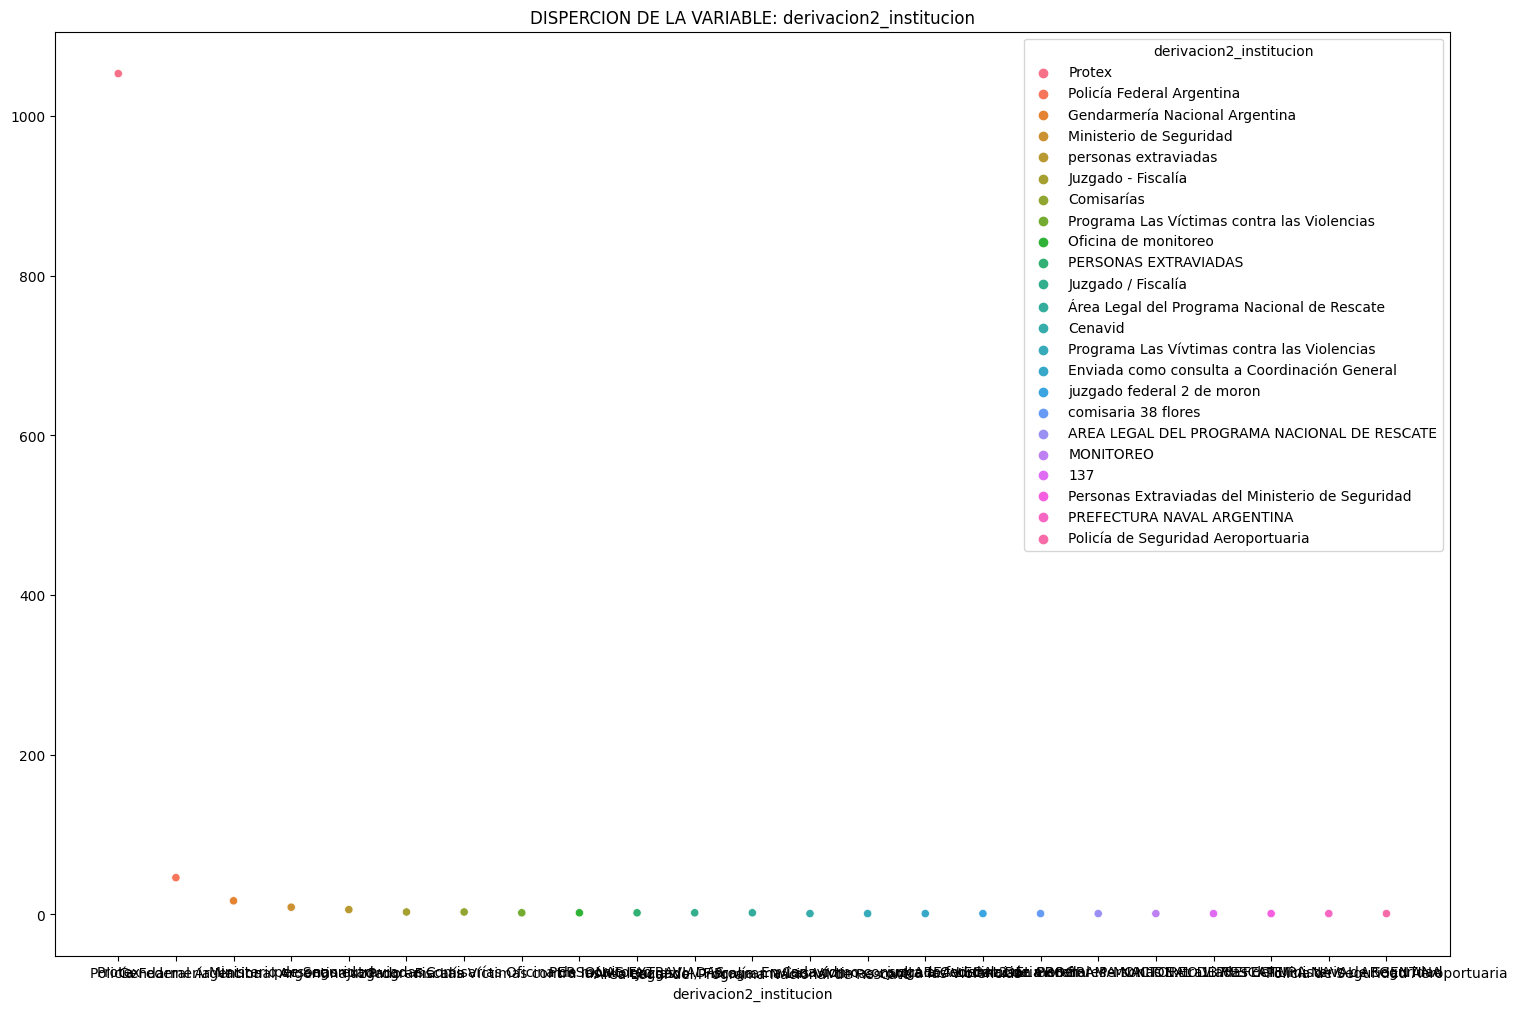

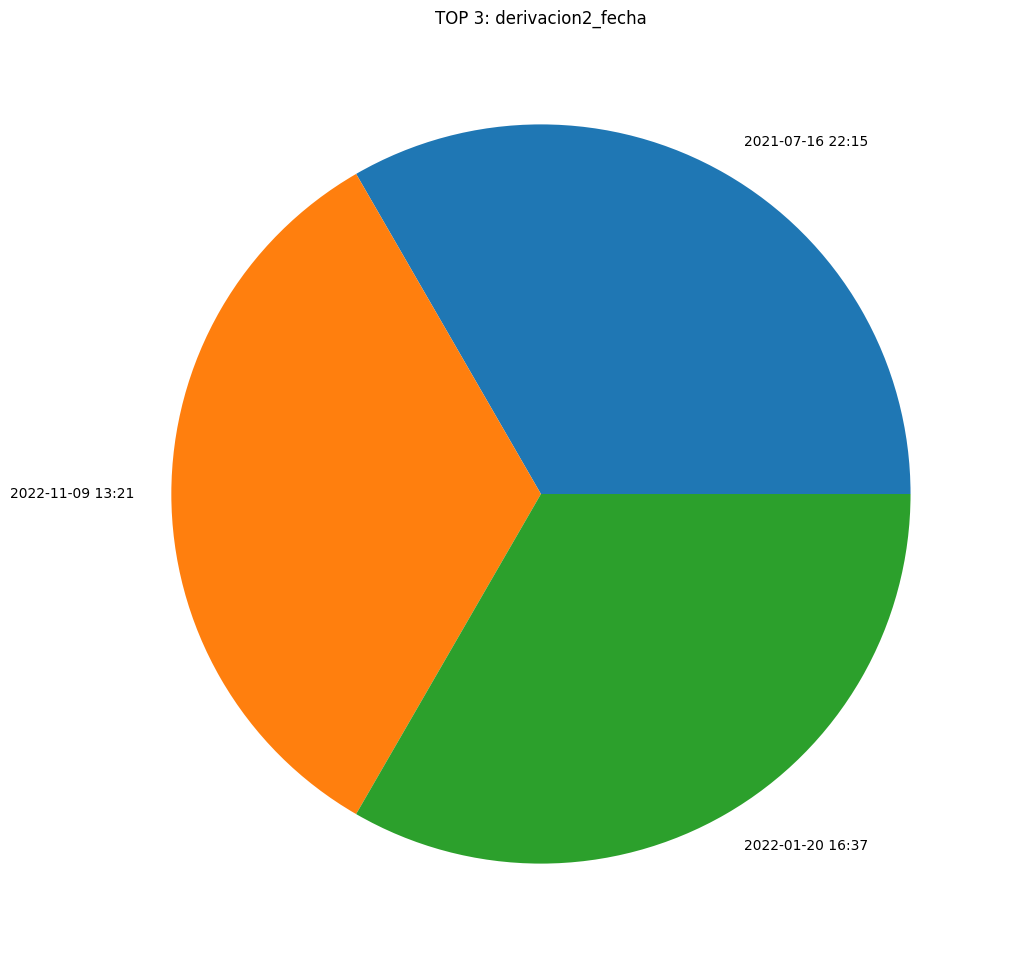

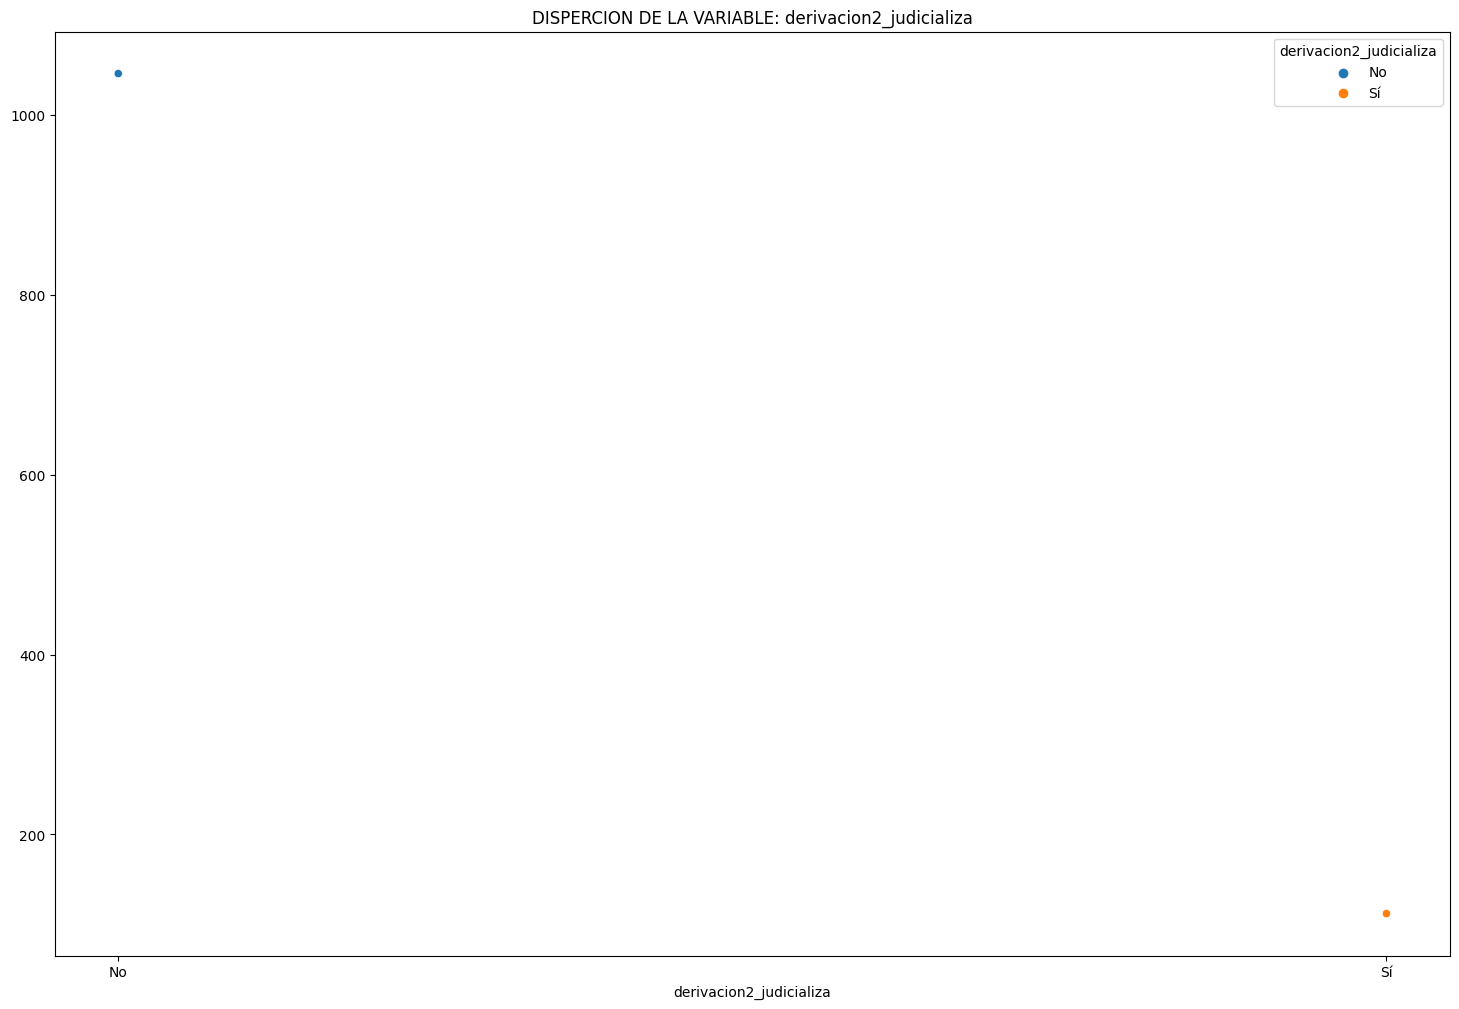

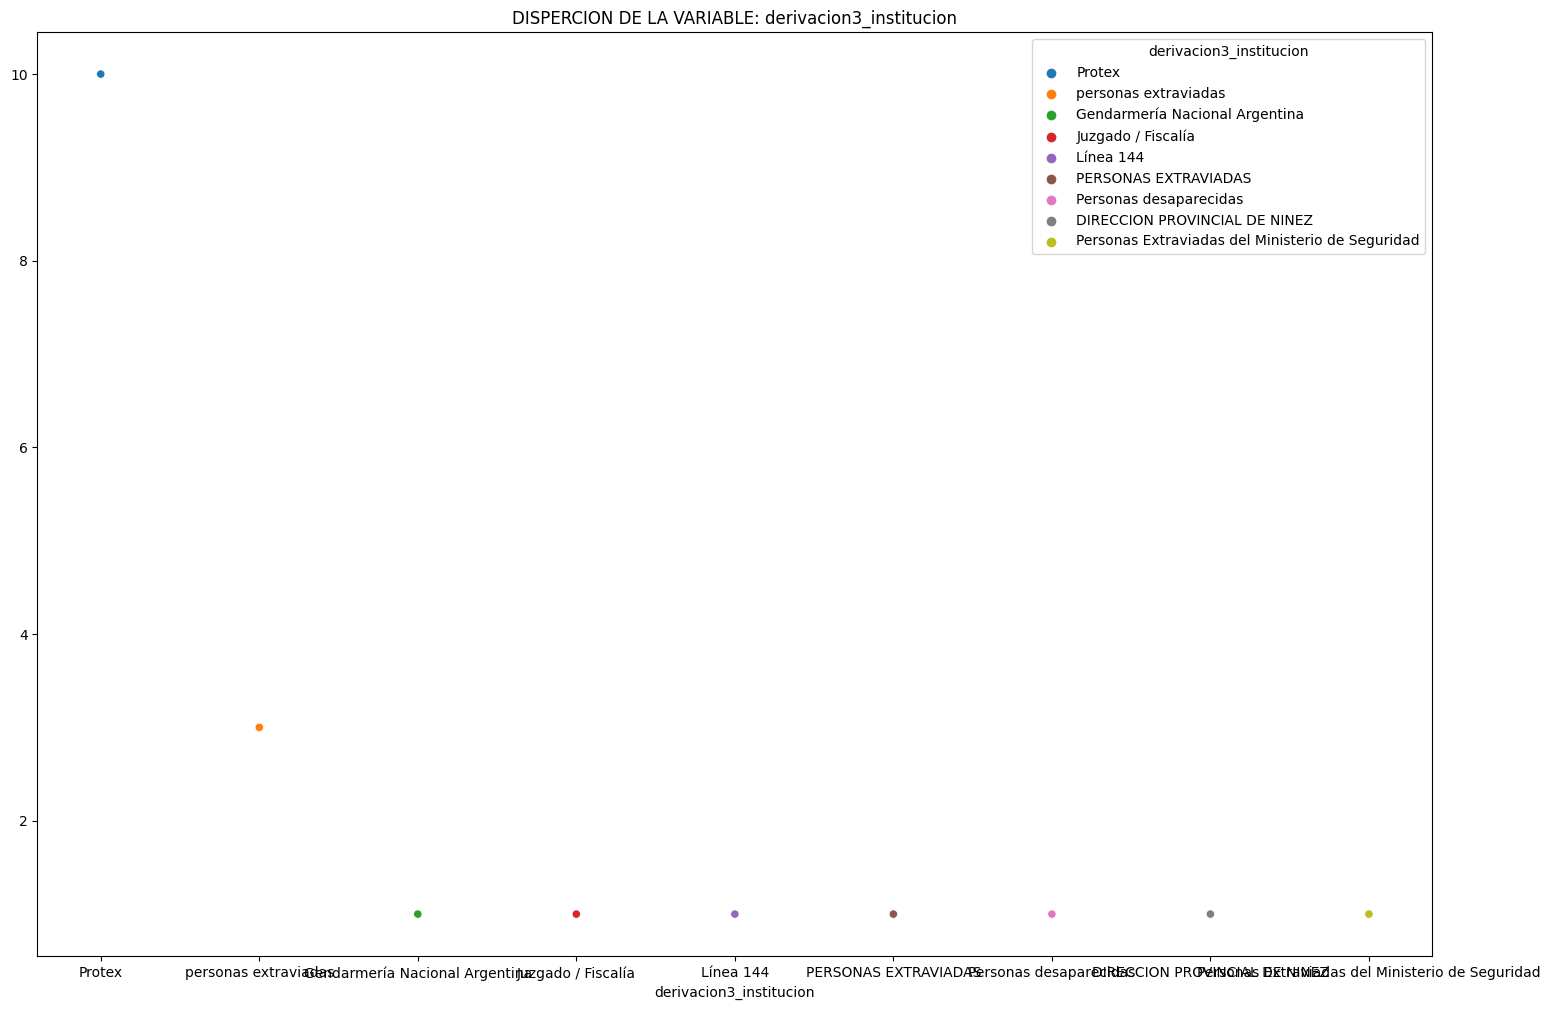

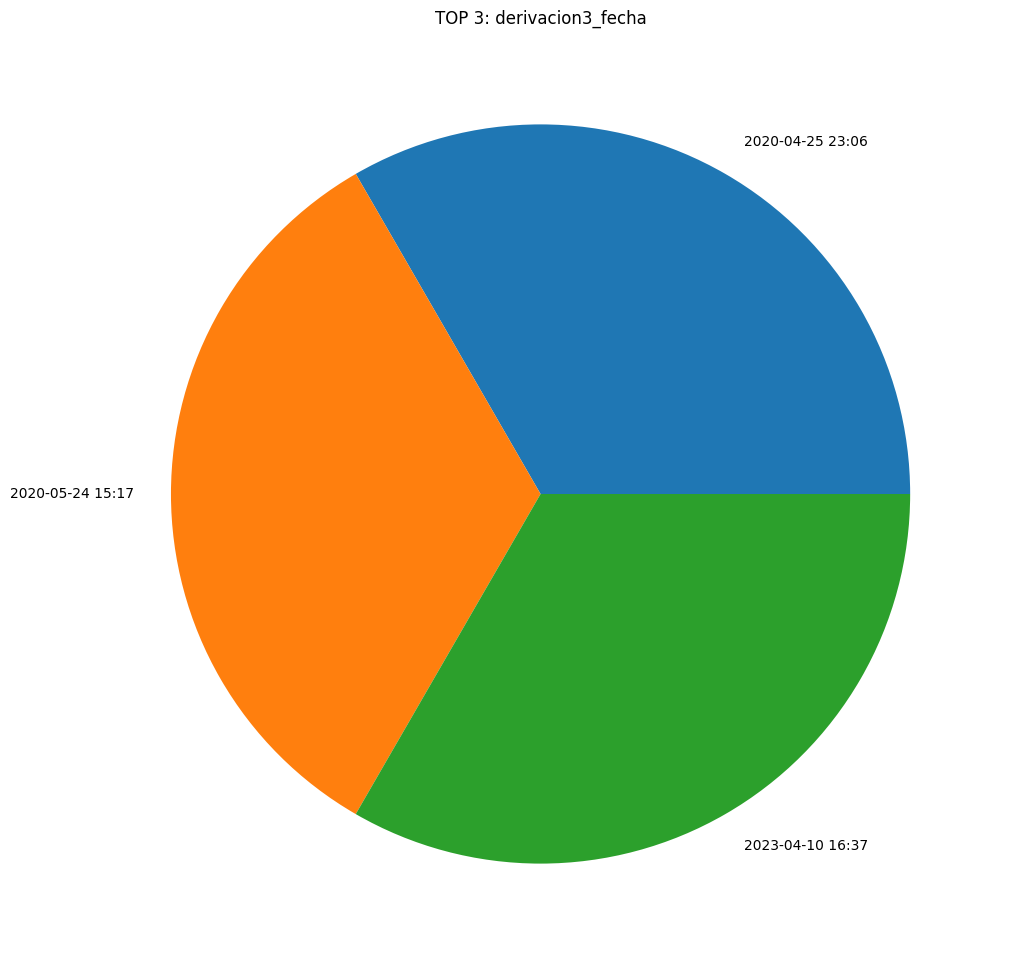

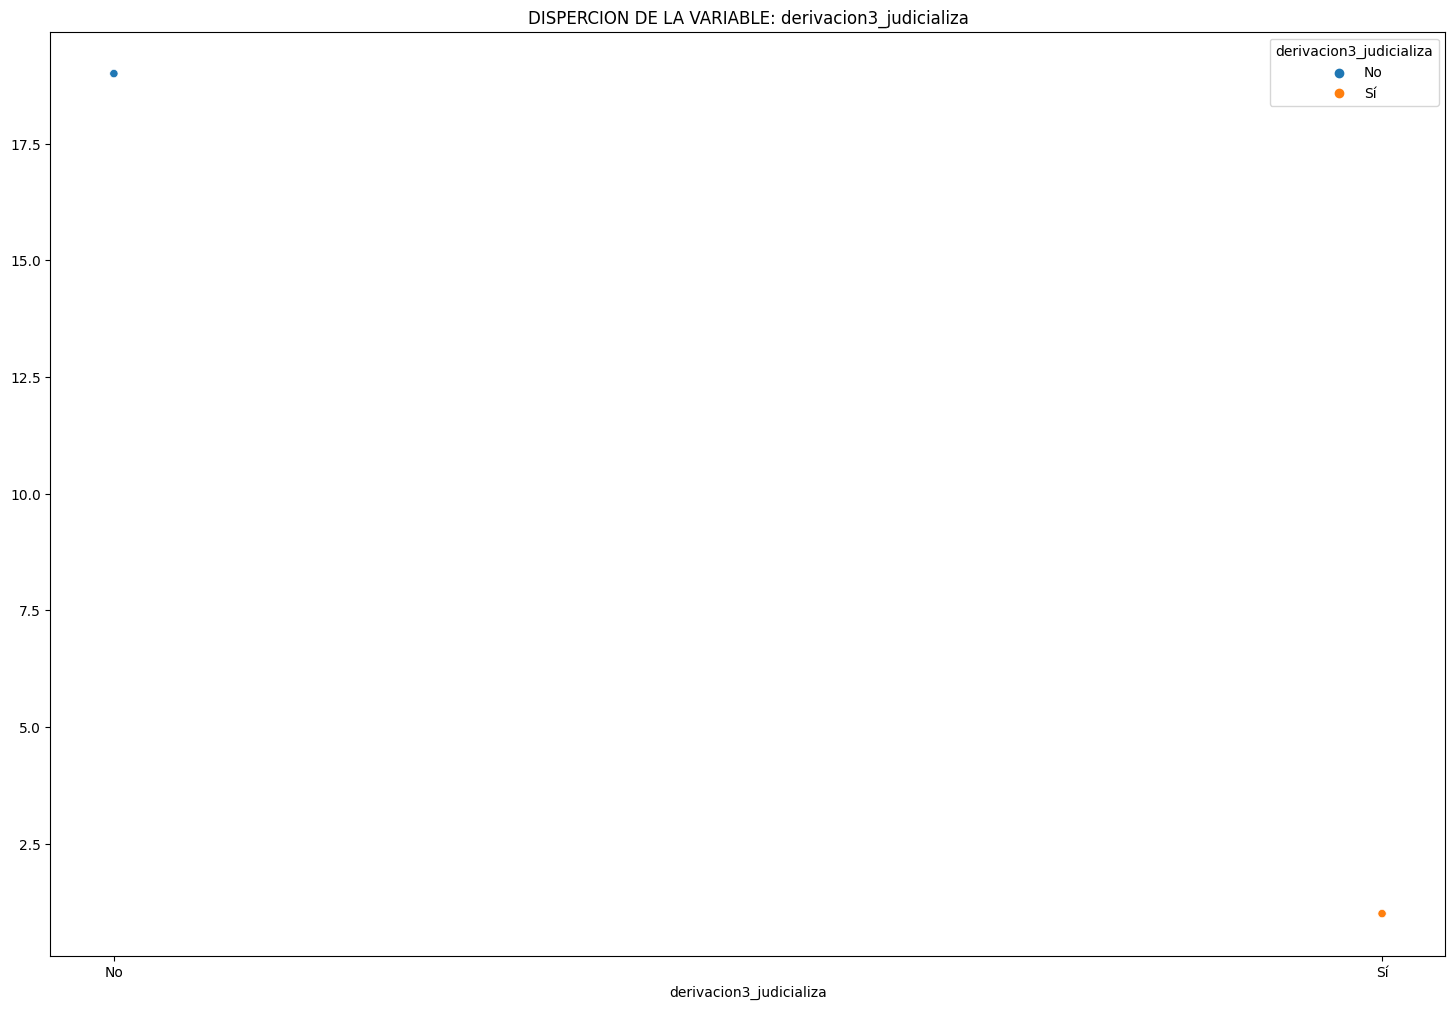

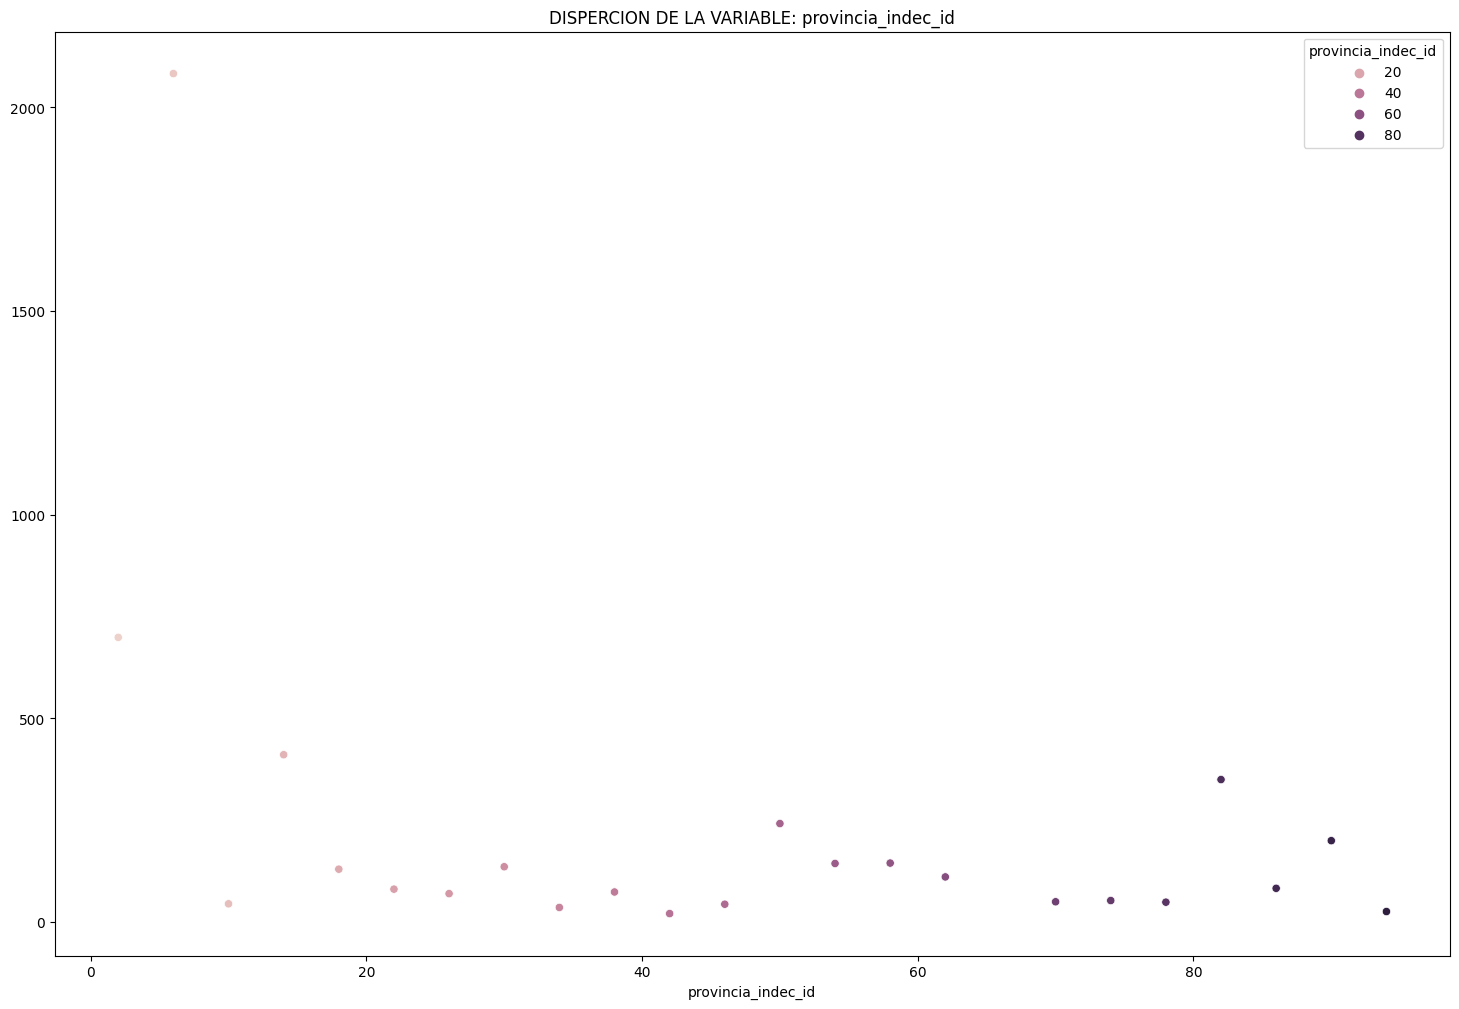

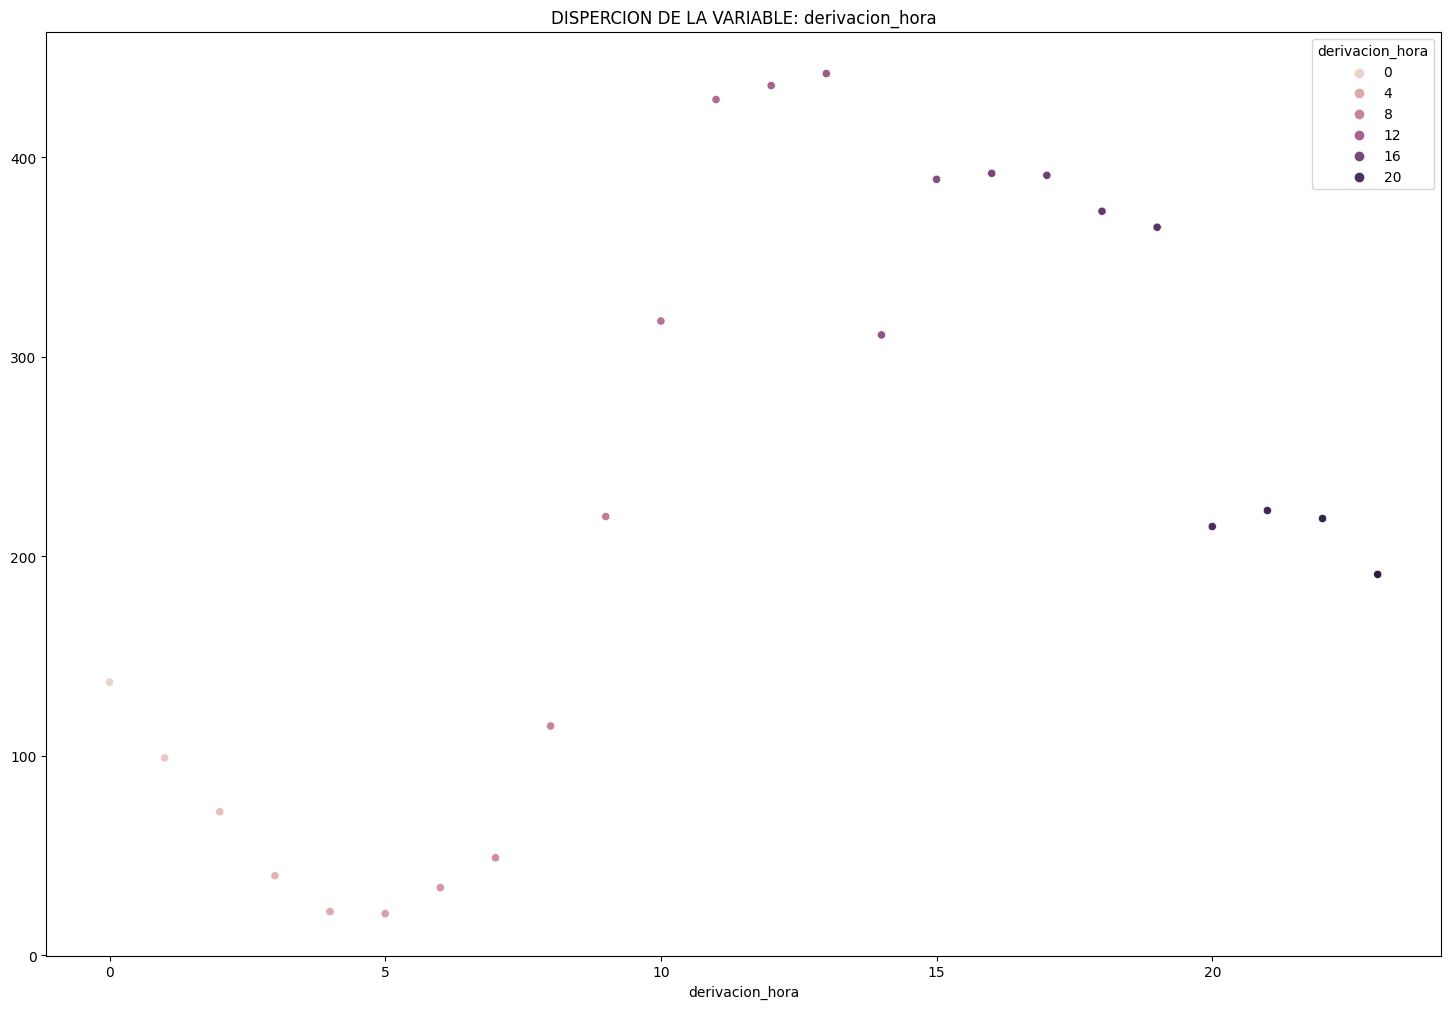

In [147]:
for column in df_denuncias.columns:
    serie = df_denuncias[column].value_counts()
    plt.figure(figsize=(18, 12))
    if column not in columnas_g_torta:
        sns.scatterplot(x=serie.index, y=serie.values, hue=serie.index)
        plt.title(f'DISPERCION DE LA VARIABLE: {column}')
    else:
        #Se crea grafico de torta, para aquellas columnas con etiquetas demaciado extensas o en demacia
        top_columnas = serie.nlargest(3)
        plt.pie(top_columnas, labels = top_columnas.index)
        plt.title(f'TOP 3: {column}')

#### 2.3.0.0 - CORRELACION

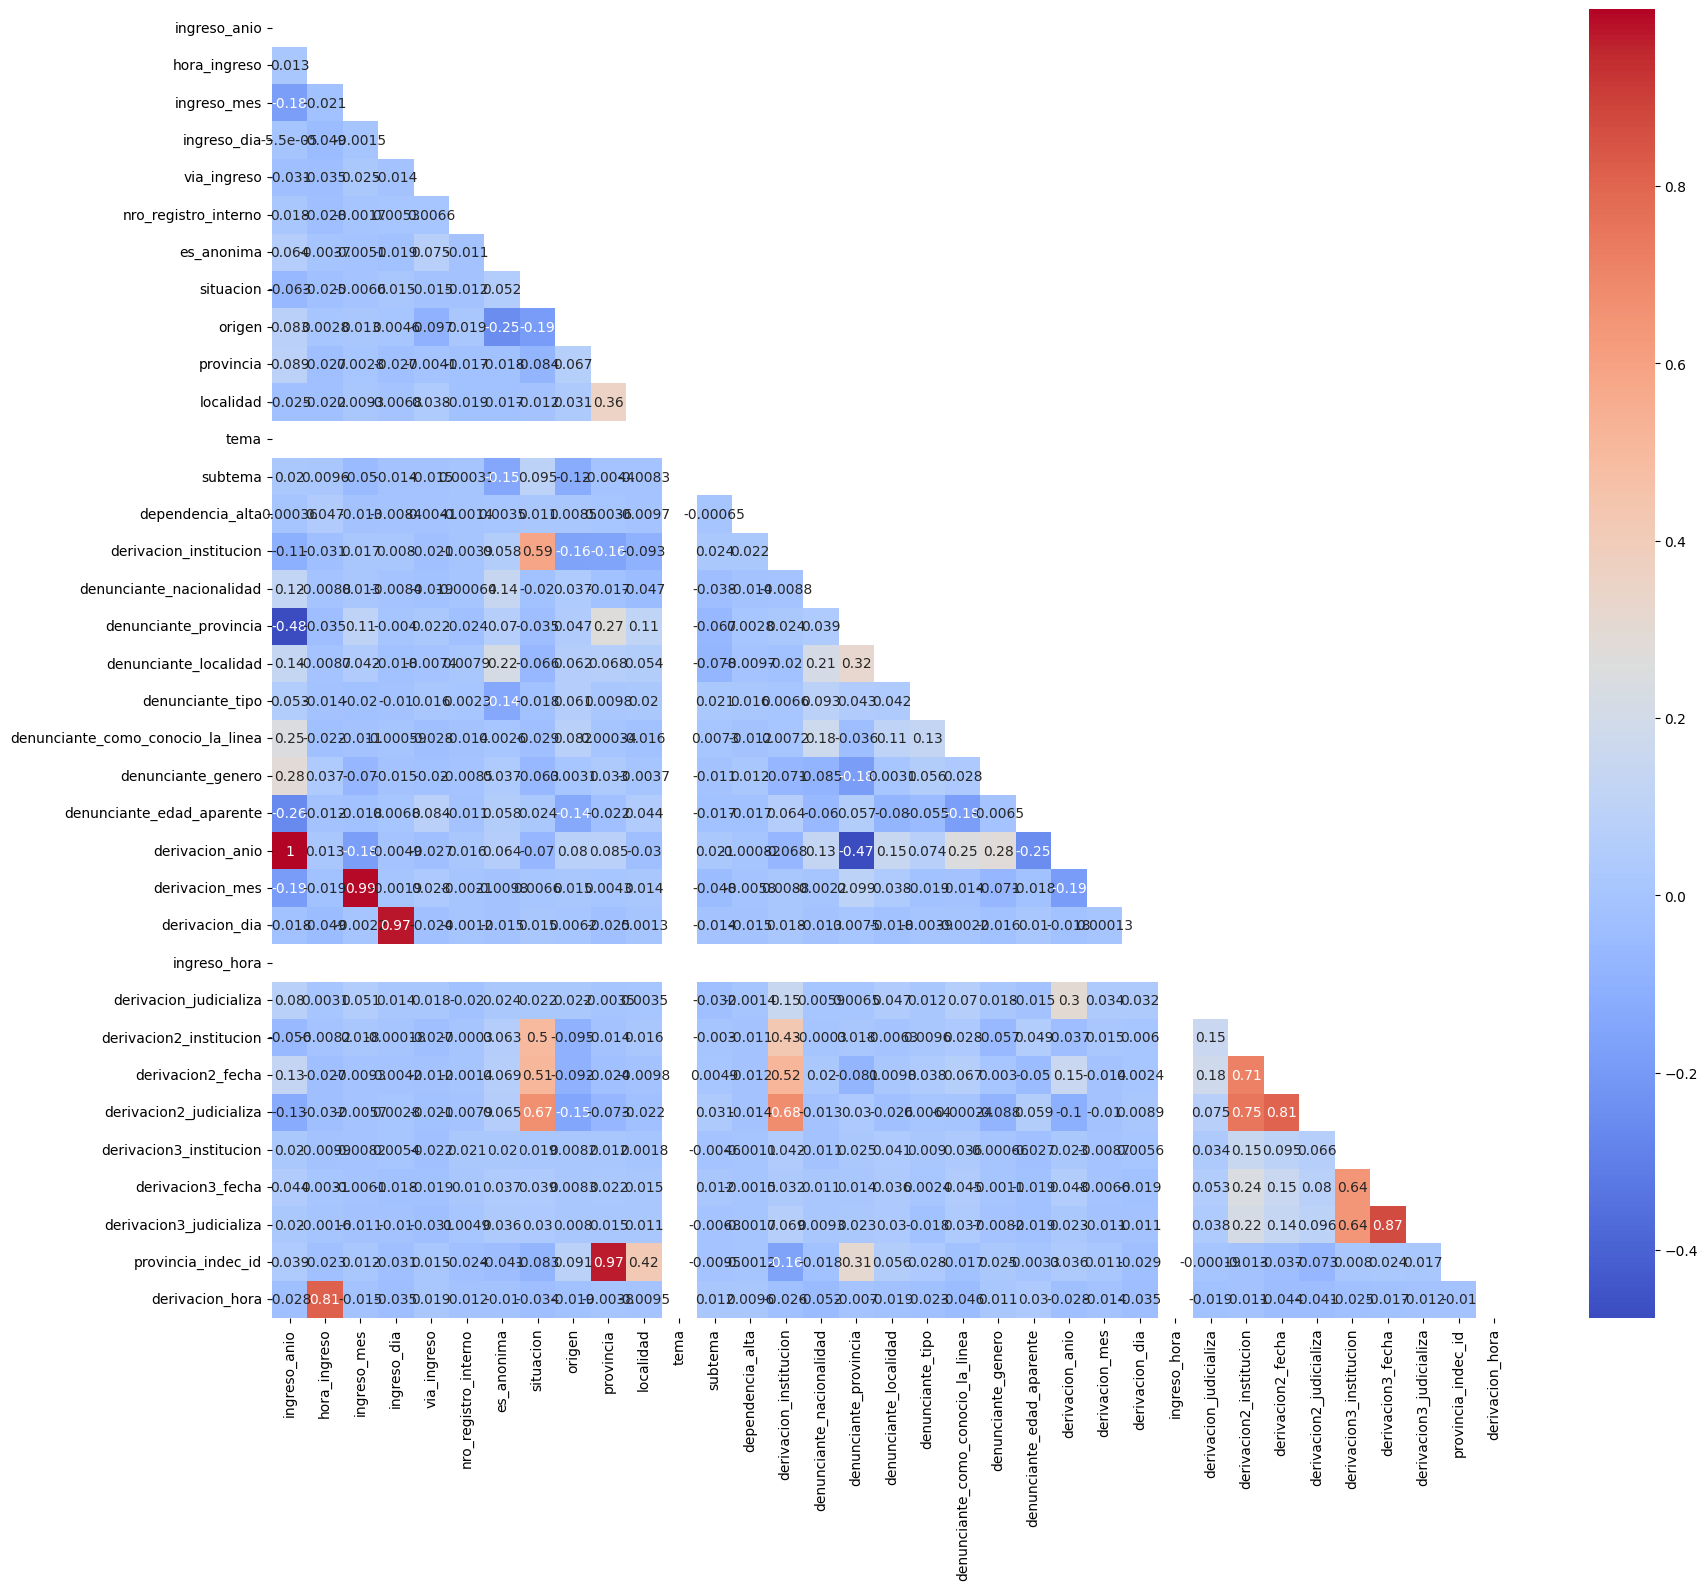

In [117]:
matriz_correlacion = df_denuncias_escalados.corr()
mascara_espejo = np.triu(np.ones_like(matriz_correlacion, dtype=bool))
# Crear el mapa de calor con la mitad de la matriz
plt.figure(figsize=(20, 17))  # Ajusta los valores según tus necesidades
sns.heatmap(matriz_correlacion, mask=mascara_espejo, annot=True, cmap='coolwarm')
plt.show()

### 2.4.0 - ALMACENAMIENTO CSV

In [118]:
df_denuncias_codificados.to_csv('../datos/csv procesados/denuncias_codificados.csv', index=False)
df_denuncias_escalados.to_csv('../datos/csv procesados/denuncias_escalados.csv', index=False)
df_denuncias.to_csv('../datos/csv procesados/denuncias.csv', index=False)

# 2.O - CSV ORIENTACIONES


### 2.1 - IMPORTACION DE CSV

In [119]:
path_orientaciones = ('../datos/csv procesados/limpios_orientaciones.csv')
df_orientaciones = pd.read_csv(path_orientaciones)

In [120]:
df_orientaciones.sample(3, random_state=4)

fecha_ingreso hora_ingreso  nro_registro_interno situacion     origen  \
3080    2022-01-30        19:38            2594759425  Urgencia  Ciudadano   
2539    2021-11-16          NaN            3545657515  Urgencia  Ciudadano   
4073    2022-11-02        15:05             505456525  Urgencia  Ciudadano   

     es_anonima                 tema       subtema  \
3080         Sí                Covid         Covid   
2539         No                Salud  Salud mental   
4073         Sí  Violencia de género   Psicológica   

                            provincia      localidad dependencia_alta  \
3080  Ciudad Autónoma de Buenos Aires   Buenos Aires  PNR - Línea 145   
2539                              NaN            NaN  PNR - Línea 145   
4073                            Jujuy  Ciudad Perico  PNR - Línea 145   

     via_ingreso consultante_nacionalidad consultante_provincia  \
3080   Línea 145                      NaN          Buenos Aires   
2539   Línea 145                      NaN                   NaN   
4073   Línea 145                      NaN                 Jujuy   

     consultante_localidad consultante_como_conocio_la_linea  \
3080                   NaN                               NaN   
2539                   NaN                               NaN   
4073                   NaN                               NaN   

     consultante_genero  consultante_edad_aparente  
3080              Mujer                       50.0  
2539              Mujer                        0.0  
4073              Mujer                       50.0

### 2.2 - COLUMNAS

#### 2.2.1 - TIPOS DE DATOS

In [121]:
# Convertir derivacion_fecha_hora a hora del día
df_orientaciones['fecha_ingreso'] = pd.to_datetime(df_orientaciones['fecha_ingreso'])

# Obtener año, mes y día de derivacion_fecha en una sola línea
df_orientaciones['ingreso_anio'] = df_orientaciones['fecha_ingreso'].dt.year
df_orientaciones['ingreso_mes'] = df_orientaciones['fecha_ingreso'].dt.month
df_orientaciones['ingreso_dia'] = df_orientaciones['fecha_ingreso'].dt.day

df_orientaciones['hora_ingreso'] = pd.to_datetime(df_orientaciones['hora_ingreso']).dt.hour

df_orientaciones  = df_orientaciones.drop('fecha_ingreso', axis=1)

/var/folders/sf/zv8w99hn1570688_wf9y1h280000gn/T/ipykernel_2119/1916780226.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_orientaciones['hora_ingreso'] = pd.to_datetime(df_orientaciones['hora_ingreso']).dt.hour


#### 2.2.2 - VALORES

In [122]:
# Sin simbolos extranios a remplazar o extraer

In [123]:
df_orientaciones.isnull().sum()

hora_ingreso                         2920
nro_registro_interno                    0
situacion                              10
origen                                  0
es_anonima                              0
tema                                    5
subtema                                 5
provincia                            1928
localidad                            2176
dependencia_alta                        0
via_ingreso                           639
consultante_nacionalidad             4355
consultante_provincia                3080
consultante_localidad                4595
consultante_como_conocio_la_linea    4449
consultante_genero                   1080
consultante_edad_aparente            1306
ingreso_anio                            0
ingreso_mes                             0
ingreso_dia                             0
dtype: int64

##### 2.2.2.0 - IMPUTACION GENERAL

In [124]:
#Interpolaciones realizadas por metodo interpolate 'hora_ingreso'
moda_situacion = df_orientaciones['situacion'].mode()[0]


df_denuncias.fillna(value = {'situacion': moda_situacion,
                            'consultante_localidad': df_orientaciones.provincia.bfill(),
                            'consultante_localidad': df_orientaciones.localidad.bfill(),
                            'localidad': df_orientaciones['via_ingreso'].bfill(),
                            'consultante_nacionalidad': 'atencion',
                            'consultante_provincia': 'atencion',
                            'consultante_localidad': 'atencion',
                            'consultante_tipo': 'atencion',
                            'consultante_como_conocio_la_linea': 'atencion',
                            'consultante_genero': 'atencion',
                            'consultante_edad_aparente': 'atencion'
                            },inplace=True)

In [125]:
# Lista con el orden deseado de las columnas
column_order = [
    'ingreso_anio', 'hora_ingreso', 'ingreso_mes', 'ingreso_dia', 'nro_registro_interno',
    'situacion', 'origen', 'provincia', 'localidad', 'tema', 'subtema', 'es_anonima',
    'via_ingreso', 'consultante_nacionalidad', 'consultante_provincia', 'consultante_localidad',
    'consultante_como_conocio_la_linea', 'consultante_genero', 'consultante_edad_aparente'
]

# Reordenar las columnas del DataFrame df_orientaciones
df_orientaciones = df_orientaciones[column_order]


##### 2.2.2.1 - IMPUTACION AVANZADA

In [126]:
df_orientaciones['hora_ingreso'].interpolate(method='linear', inplace=True)

#### 2.2.3 - CODIFICACION

##### 2.2.3.0 - CATEGORICOS NOMINALES

In [127]:
columnas_categoricas = df_orientaciones.select_dtypes(include=['category', 'object']).copy()
columnas_categoricas_nombres =  columnas_categoricas.columns

In [128]:
# Columnas categoricas nominales
df_orientaciones_codificados = df_orientaciones.copy()
for column in columnas_categoricas_nombres:
    encoder = LabelEncoder()
    df_orientaciones_codificados[column] = encoder.fit_transform(df_orientaciones_codificados[column].astype(str))

In [129]:
df_orientaciones.head(3)

ingreso_anio  hora_ingreso  ingreso_mes  ingreso_dia  nro_registro_interno  \
0          2020           NaN            1            1            1584554505   
1          2020           NaN            1            2            4584554505   
2          2020           NaN            1            2            5584554505   

  situacion     origen                        provincia  \
0  Urgencia  Ciudadano  Ciudad Autónoma de Buenos Aires   
1  Urgencia  Ciudadano                            Jujuy   
2  Urgencia  Ciudadano                     Buenos Aires   

                         localidad                   tema  \
0  Ciudad Autónoma de Buenos Aires                  Trata   
1                              NaN  Relaciones de familia   
2                     Buenos Aires                  Trata   

                                          subtema es_anonima via_ingreso  \
0                            Persona desaparecida         No   Línea 145   
1  Deberes de responsabilidad parental o familiar         No   Línea 145   
2                              Explotación sexual         Si   Línea 145   

  consultante_nacionalidad            consultante_provincia  \
0                Argentina  Ciudad Autónoma de Buenos Aires   
1                  Bolivia                              NaN   
2                      NaN                              NaN   

             consultante_localidad consultante_como_conocio_la_linea  \
0  Ciudad Autónoma de Buenos Aires                               NaN   
1                              NaN                               NaN   
2                              NaN                               NaN   

  consultante_genero  consultante_edad_aparente  
0              Mujer                       25.0  
1              Mujer                        NaN  
2              Mujer                        NaN

##### 2.2.3.1 - CATEGORICOS ORDINALES

In [130]:
#Columnas categoricas ordinales
# No hay

#### 2.2.4 - ESCALAMIENTO

In [131]:
scaler = MinMaxScaler()
df_orientaciones_escalados = scaler.fit_transform(df_orientaciones_codificados.copy())
df_orientaciones_escalados = pd.DataFrame(df_orientaciones_escalados, columns = df_orientaciones.columns)

#### 2.2.5 - PORCENTAJE DE VALORES

In [132]:
df_orientaciones_escalados.isnull().sum()

ingreso_anio                            0
hora_ingreso                         2920
ingreso_mes                             0
ingreso_dia                             0
nro_registro_interno                    0
situacion                               0
origen                                  0
provincia                               0
localidad                               0
tema                                    0
subtema                                 0
es_anonima                              0
via_ingreso                             0
consultante_nacionalidad                0
consultante_provincia                   0
consultante_localidad                   0
consultante_como_conocio_la_linea       0
consultante_genero                      0
consultante_edad_aparente            1306
dtype: int64

#### 2.2.6 - MEDIDAS DE TENDENCIA CENTRAL

In [133]:
df_orientaciones.describe(include='all')

ingreso_anio  hora_ingreso  ingreso_mes  ingreso_dia  \
count    5278.000000   2358.000000  5278.000000  5278.000000   
unique           NaN           NaN          NaN          NaN   
top              NaN           NaN          NaN          NaN   
freq             NaN           NaN          NaN          NaN   
mean     2021.370216     13.461408     5.943729    15.751989   
std         1.068667      5.284040     3.389398     8.849941   
min      2020.000000      0.000000     1.000000     1.000000   
25%      2020.000000     10.000000     3.000000     8.000000   
50%      2021.000000     13.000000     6.000000    16.000000   
75%      2022.000000     17.000000     9.000000    23.000000   
max      2023.000000     23.000000    12.000000    31.000000   

        nro_registro_interno situacion     origen     provincia     localidad  \
count           5.278000e+03      5268       5278          3350          3102   
unique                   NaN         2        230            25           540   
top                      NaN  Urgencia  Ciudadano  Buenos Aires  Buenos Aires   
freq                     NaN      5225       4956          1177           779   
mean            5.052416e+09       NaN        NaN           NaN           NaN   
std             2.841749e+09       NaN        NaN           NaN           NaN   
min             5.050505e+08       NaN        NaN           NaN           NaN   
25%             2.555659e+09       NaN        NaN           NaN           NaN   
50%             5.505156e+09       NaN        NaN           NaN           NaN   
75%             7.555158e+09       NaN        NaN           NaN           NaN   
max             9.494949e+09       NaN        NaN           NaN           NaN   

         tema       subtema es_anonima via_ingreso consultante_nacionalidad  \
count    5273          5273       5278        4639                      923   
unique     41           745          3          29                       15   
top     Trata  Salud mental         No   Línea 145                Argentina   
freq     2897           783       2849        4470                      790   
mean      NaN           NaN        NaN         NaN                      NaN   
std       NaN           NaN        NaN         NaN                      NaN   
min       NaN           NaN        NaN         NaN                      NaN   
25%       NaN           NaN        NaN         NaN                      NaN   
50%       NaN           NaN        NaN         NaN                      NaN   
75%       NaN           NaN        NaN         NaN                      NaN   
max       NaN           NaN        NaN         NaN                      NaN   

       consultante_provincia            consultante_localidad  \
count                   2198                              683   
unique                    24                              222   
top             Buenos Aires  Ciudad Autónoma de Buenos Aires   
freq                     775                              122   
mean                     NaN                              NaN   
std                      NaN                              NaN   
min                      NaN                              NaN   
25%                      NaN                              NaN   
50%                      NaN                              NaN   
75%                      NaN                              NaN   
max                      NaN                              NaN   

       consultante_como_conocio_la_linea consultante_genero  \
count                                829               4198   
unique                                44                 12   
top                 No sabe, no recuerda              Mujer   
freq                                 327               2109   
mean                                 NaN                NaN   
std                                  NaN                NaN   
min                                  NaN                NaN   
25%                             

### 2.3.0 - RELACION ENTRE COLUMNAS

In [150]:
#Columnas a graficar por separado, debido a su tamanio en texto o su cantidad habida
columnas_g_torta = ['localidad',  'consultante_como_conocio_la_linea', 'consultante_localidad', 'derivacion_institucion', 'subtema', 'origen']

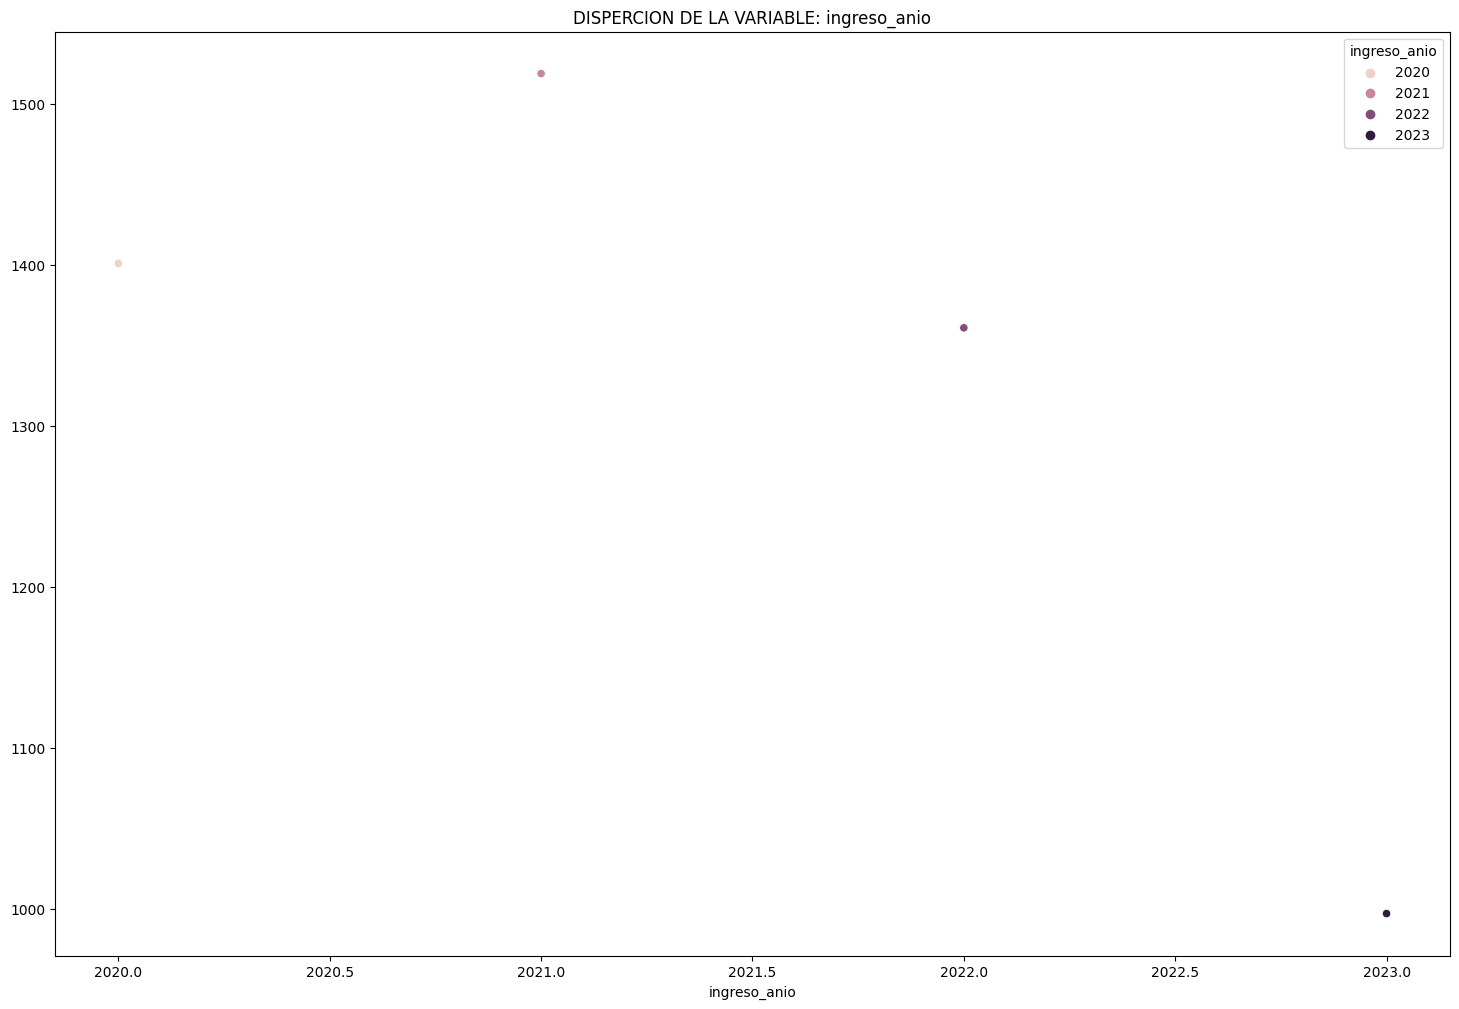

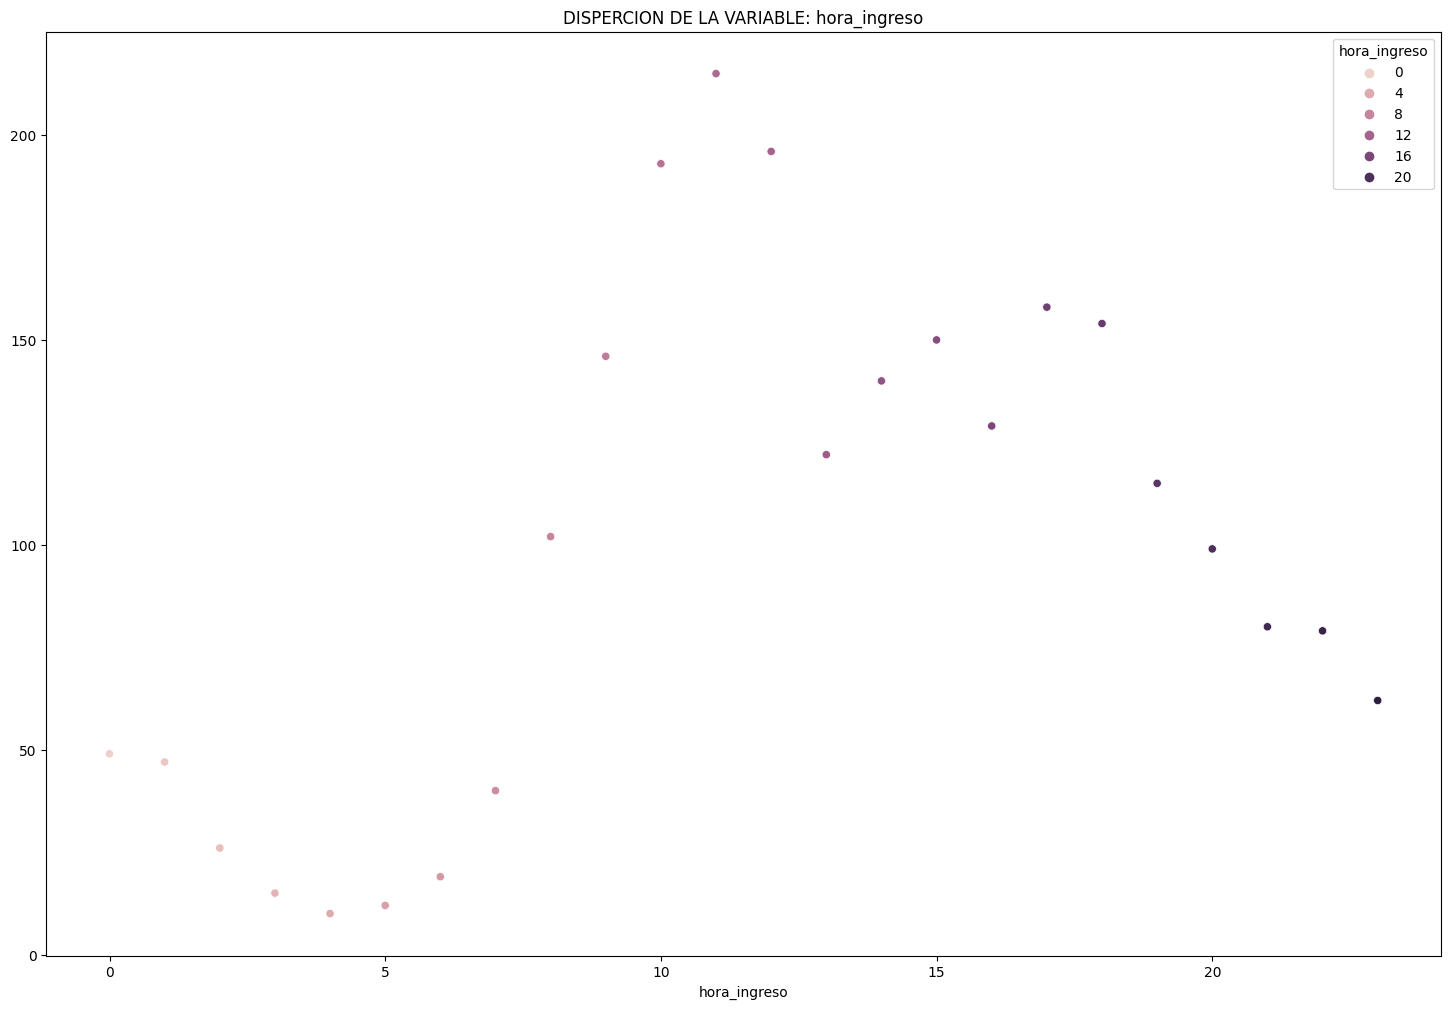

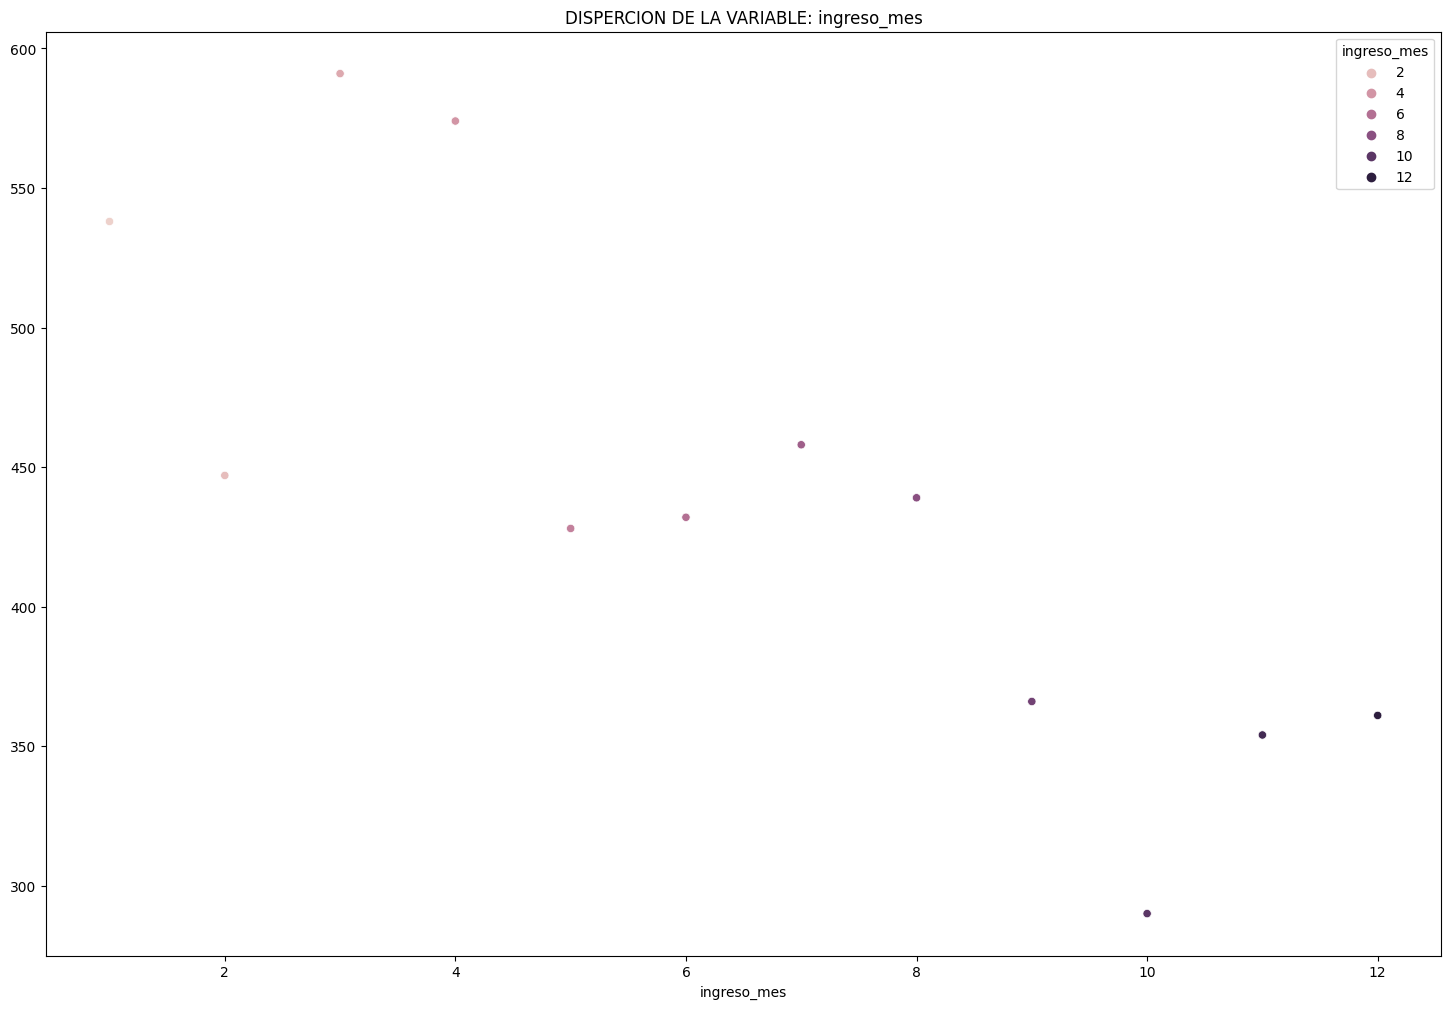

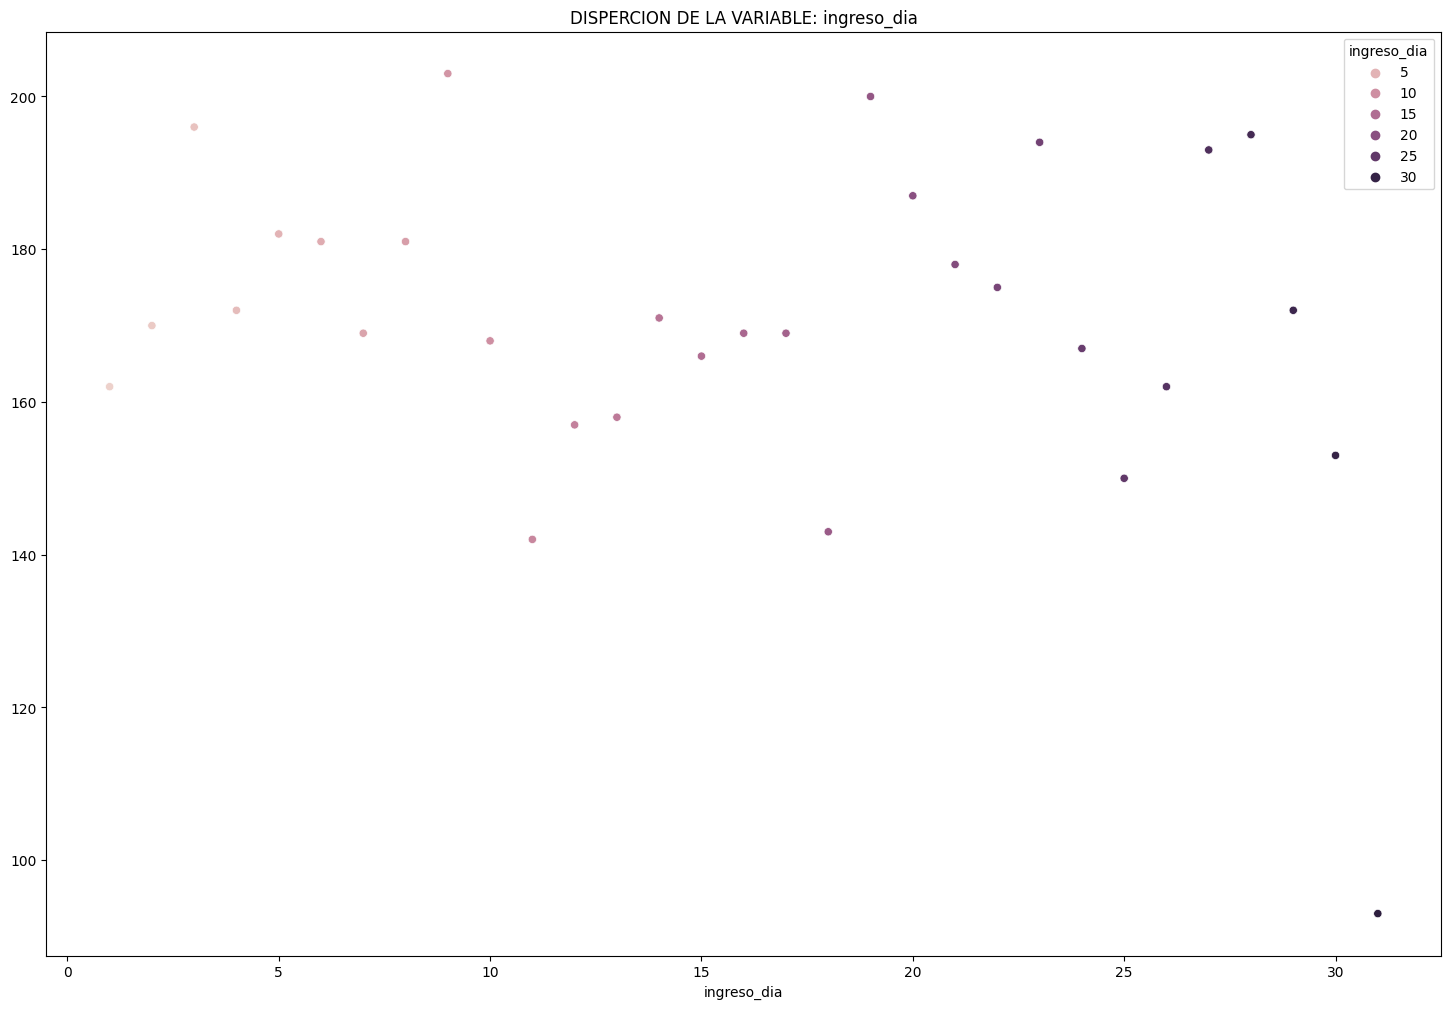

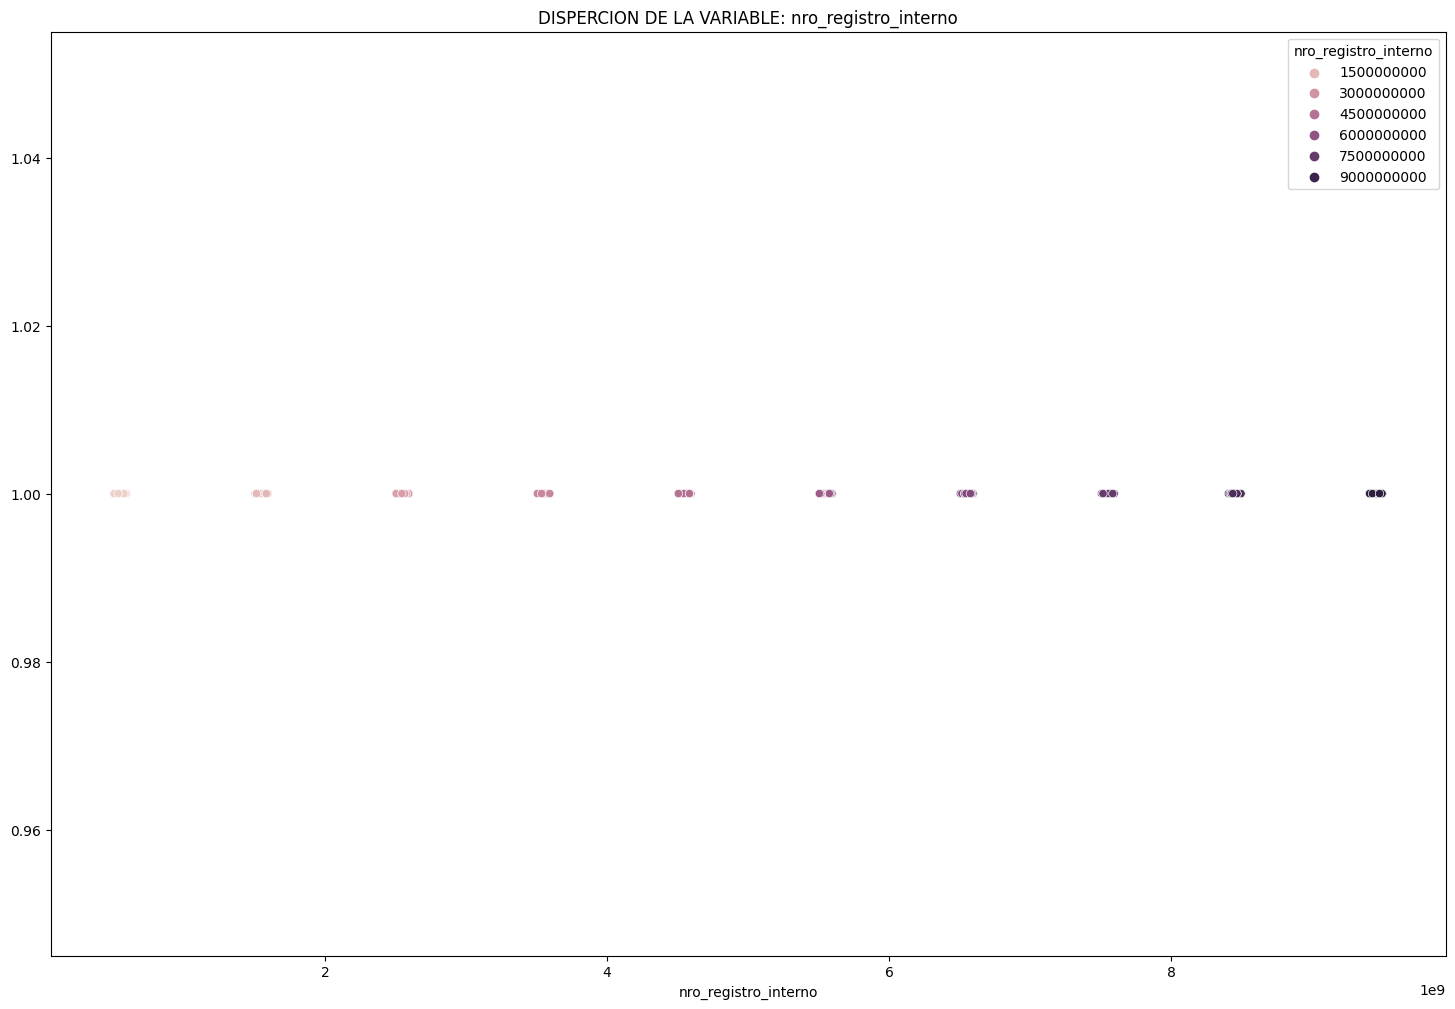

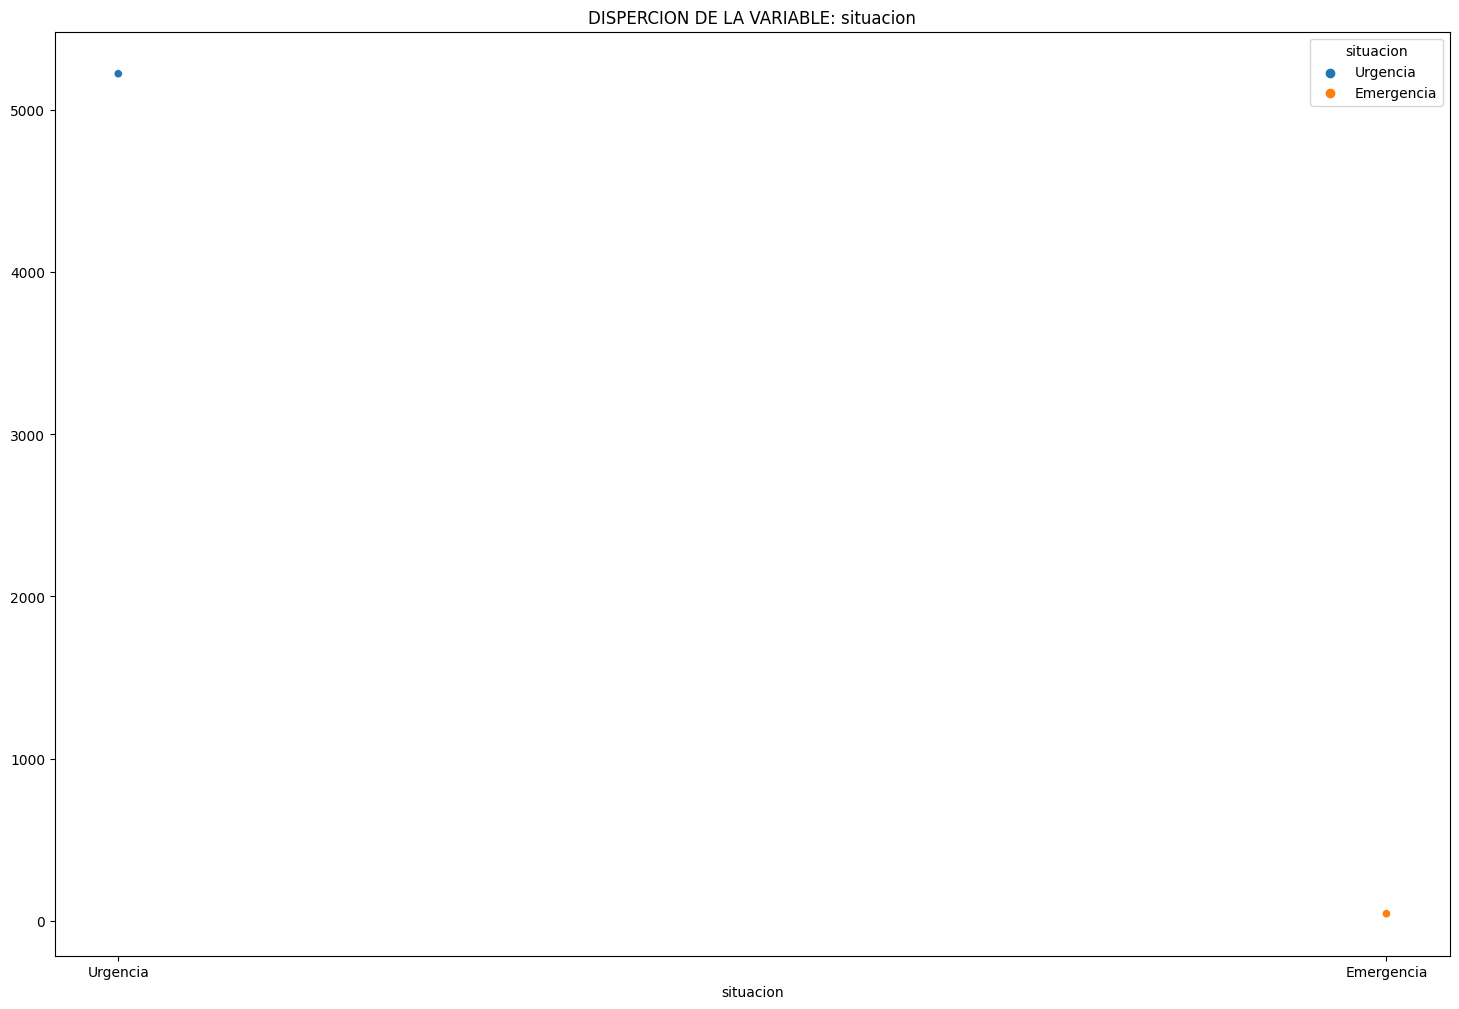

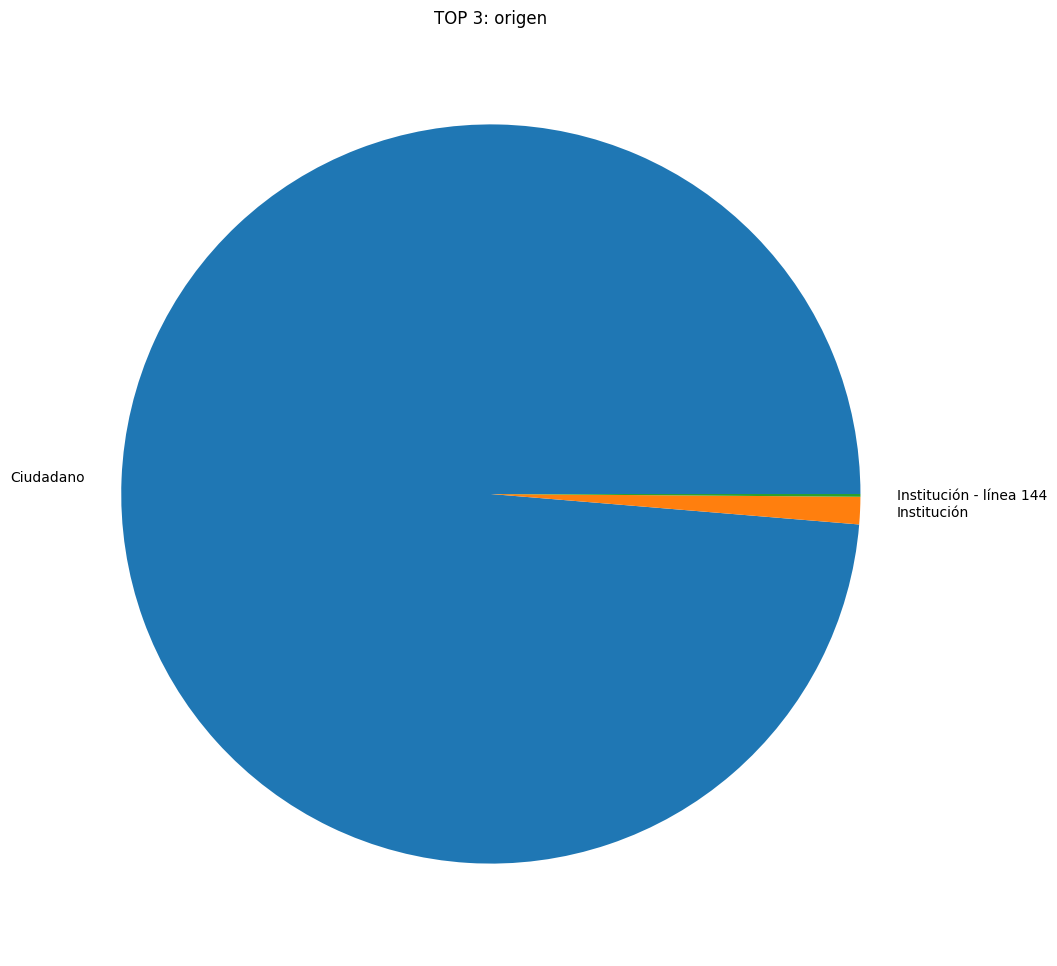

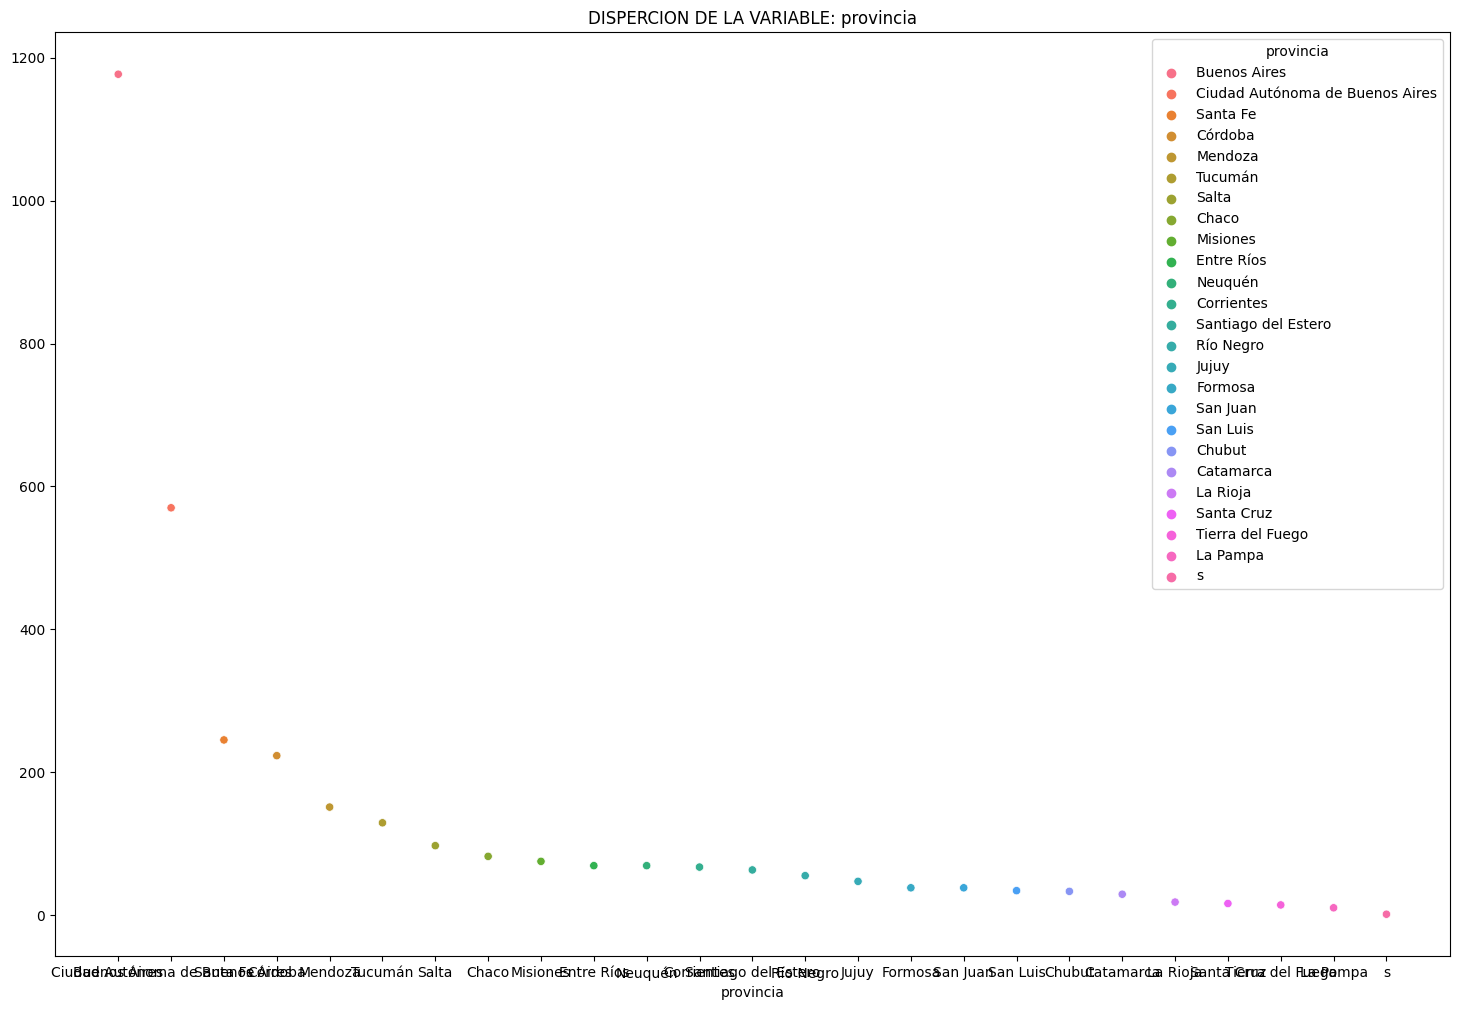

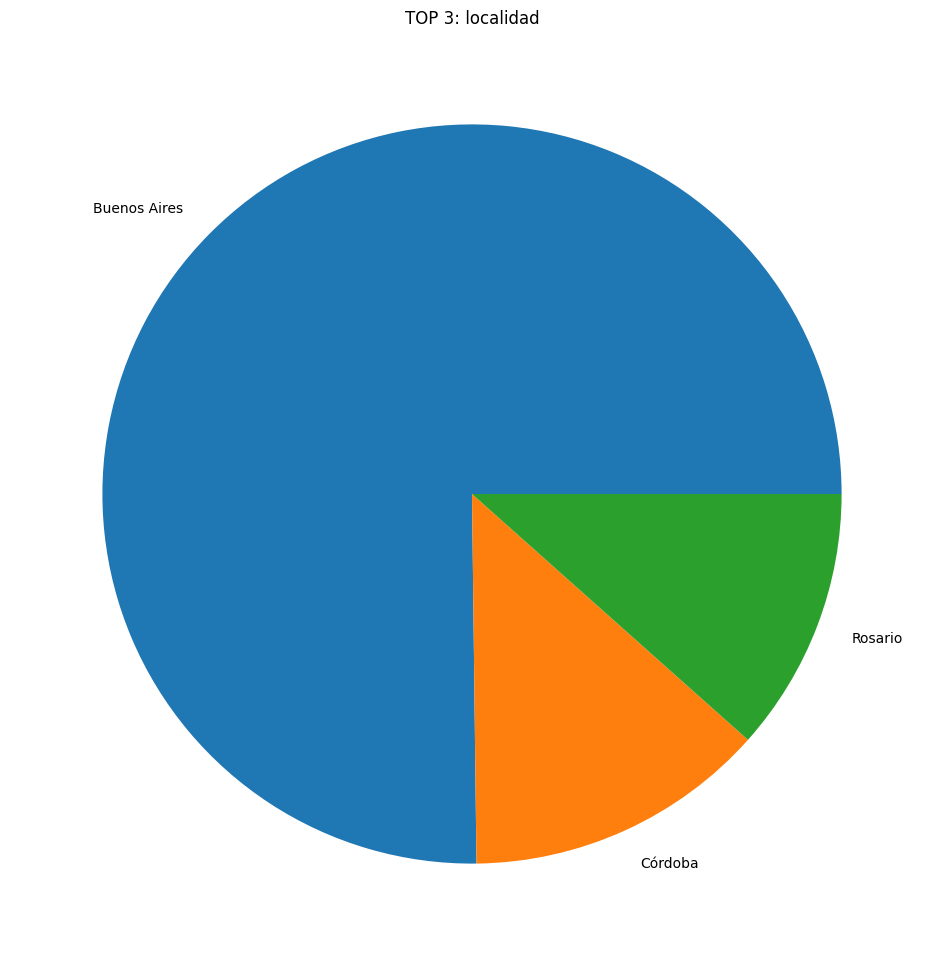

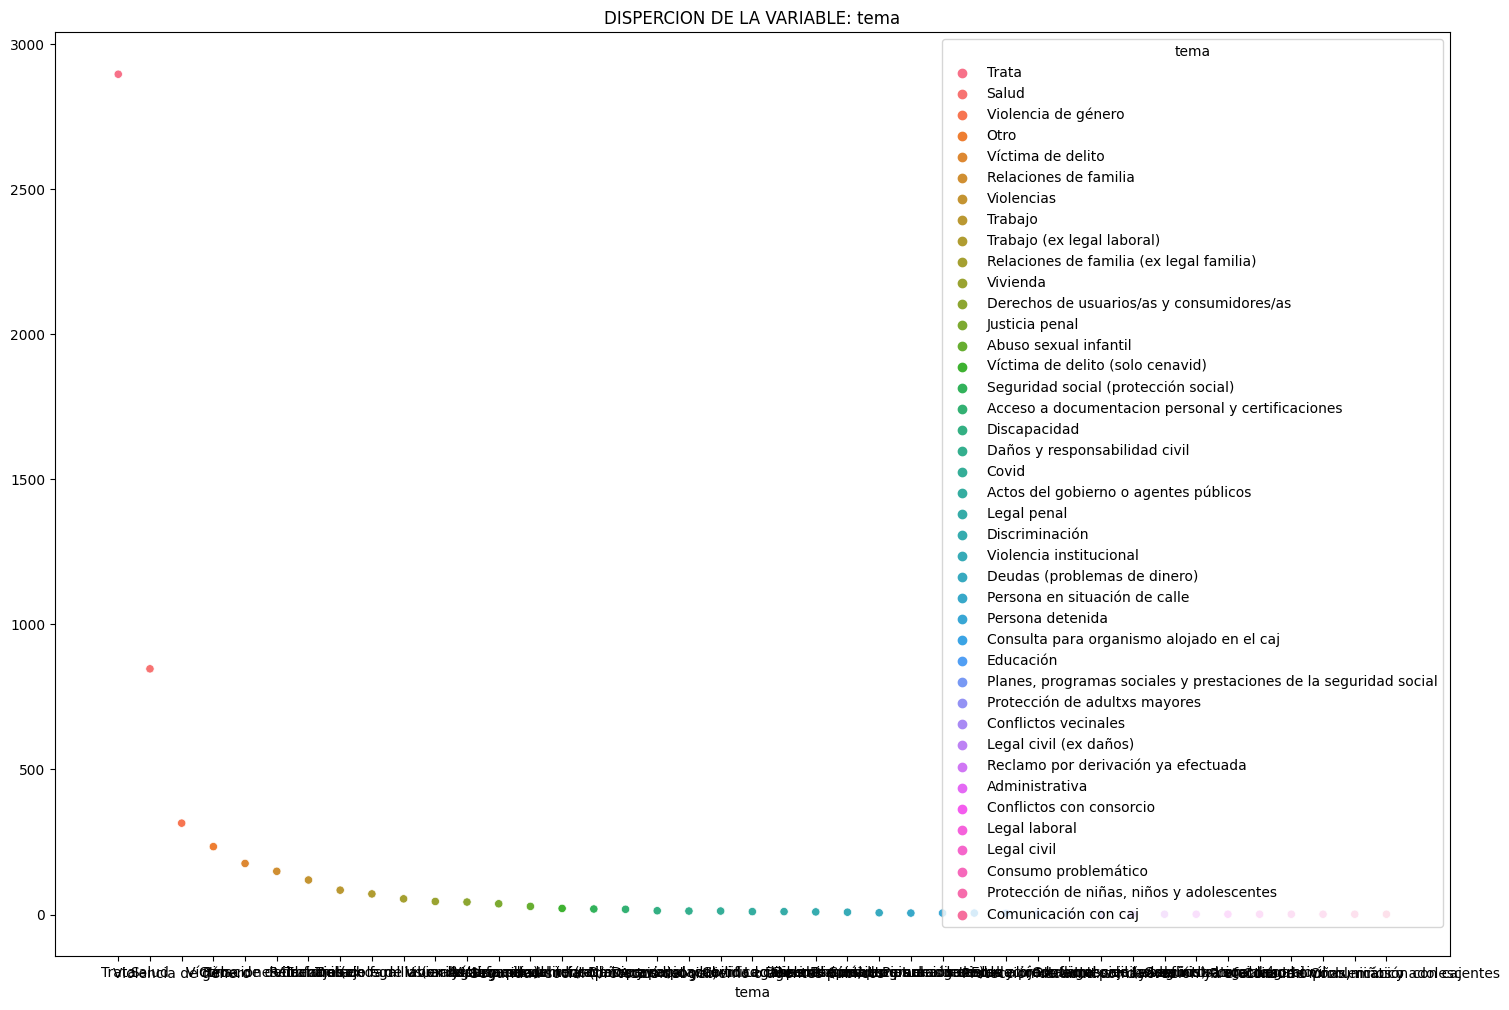

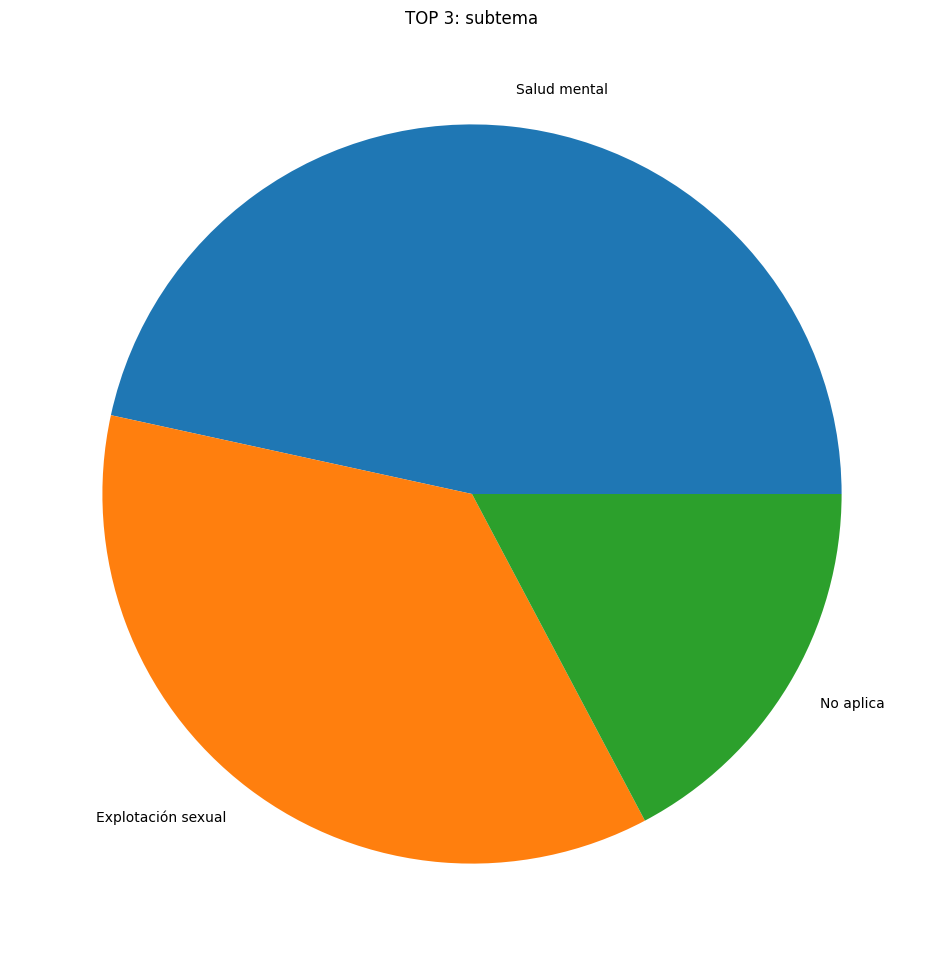

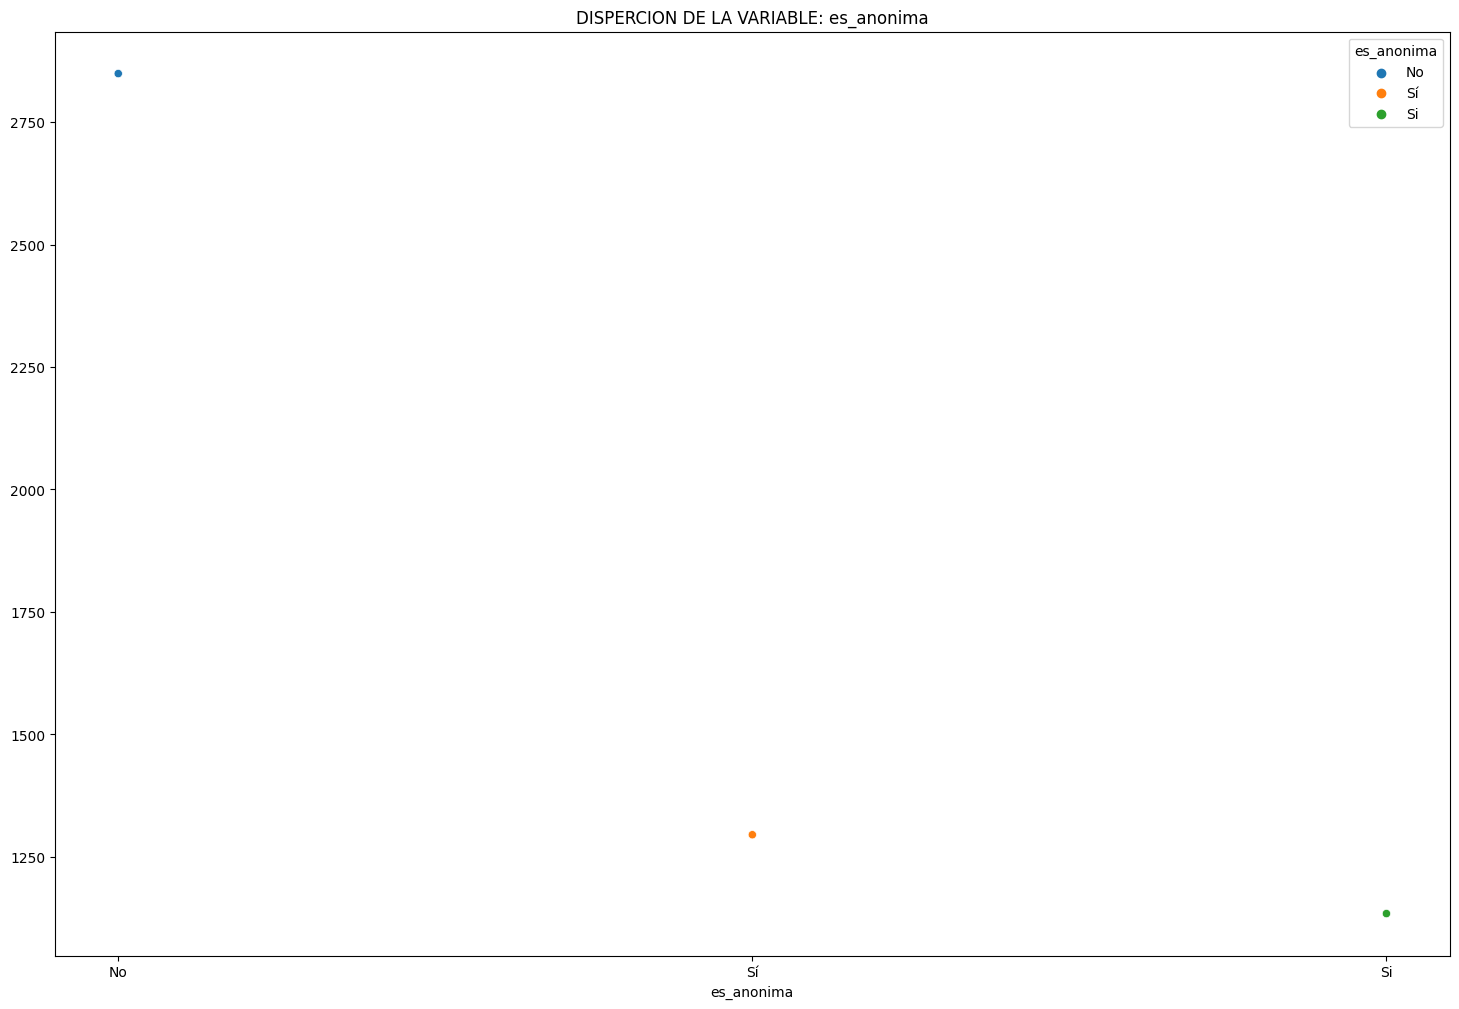

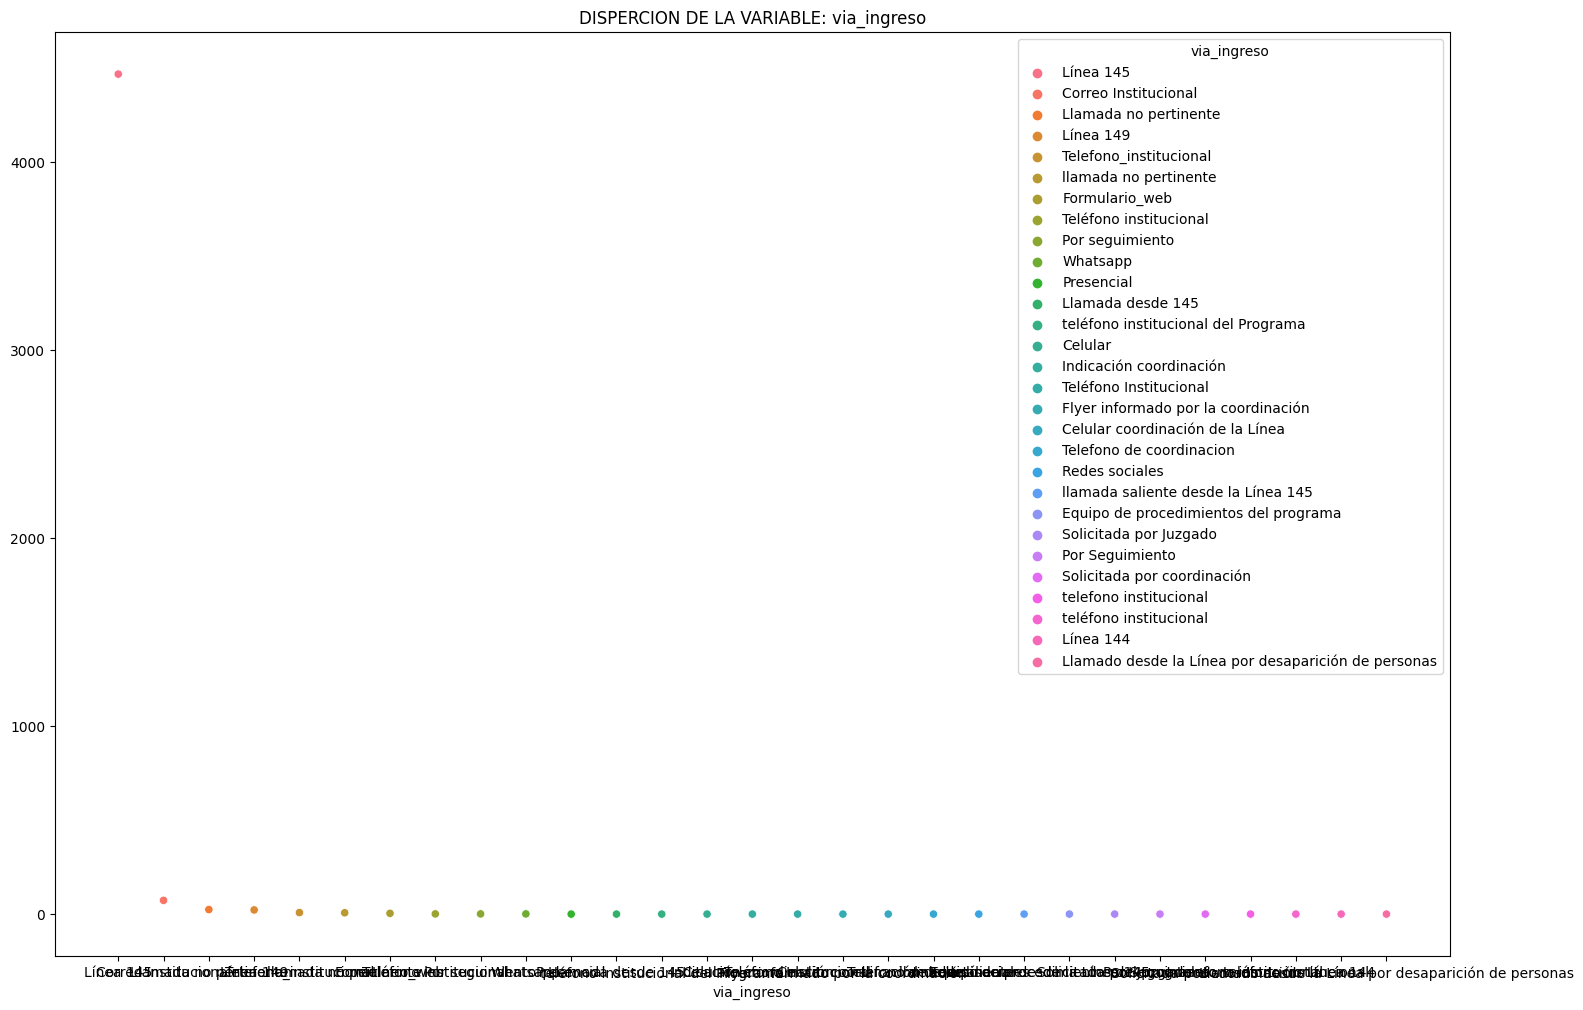

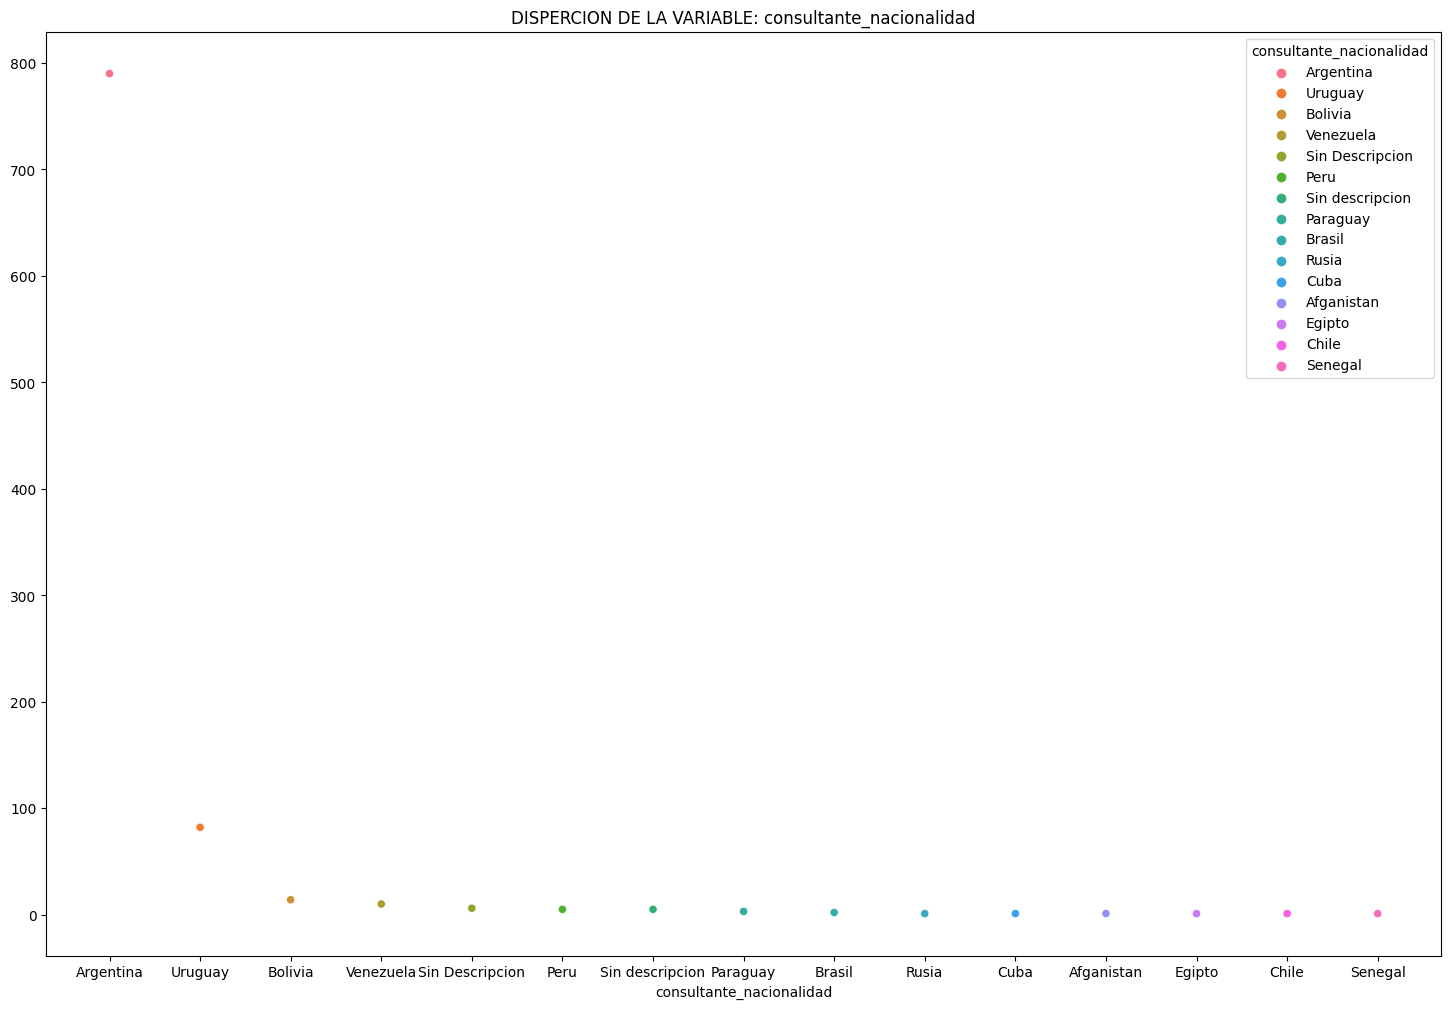

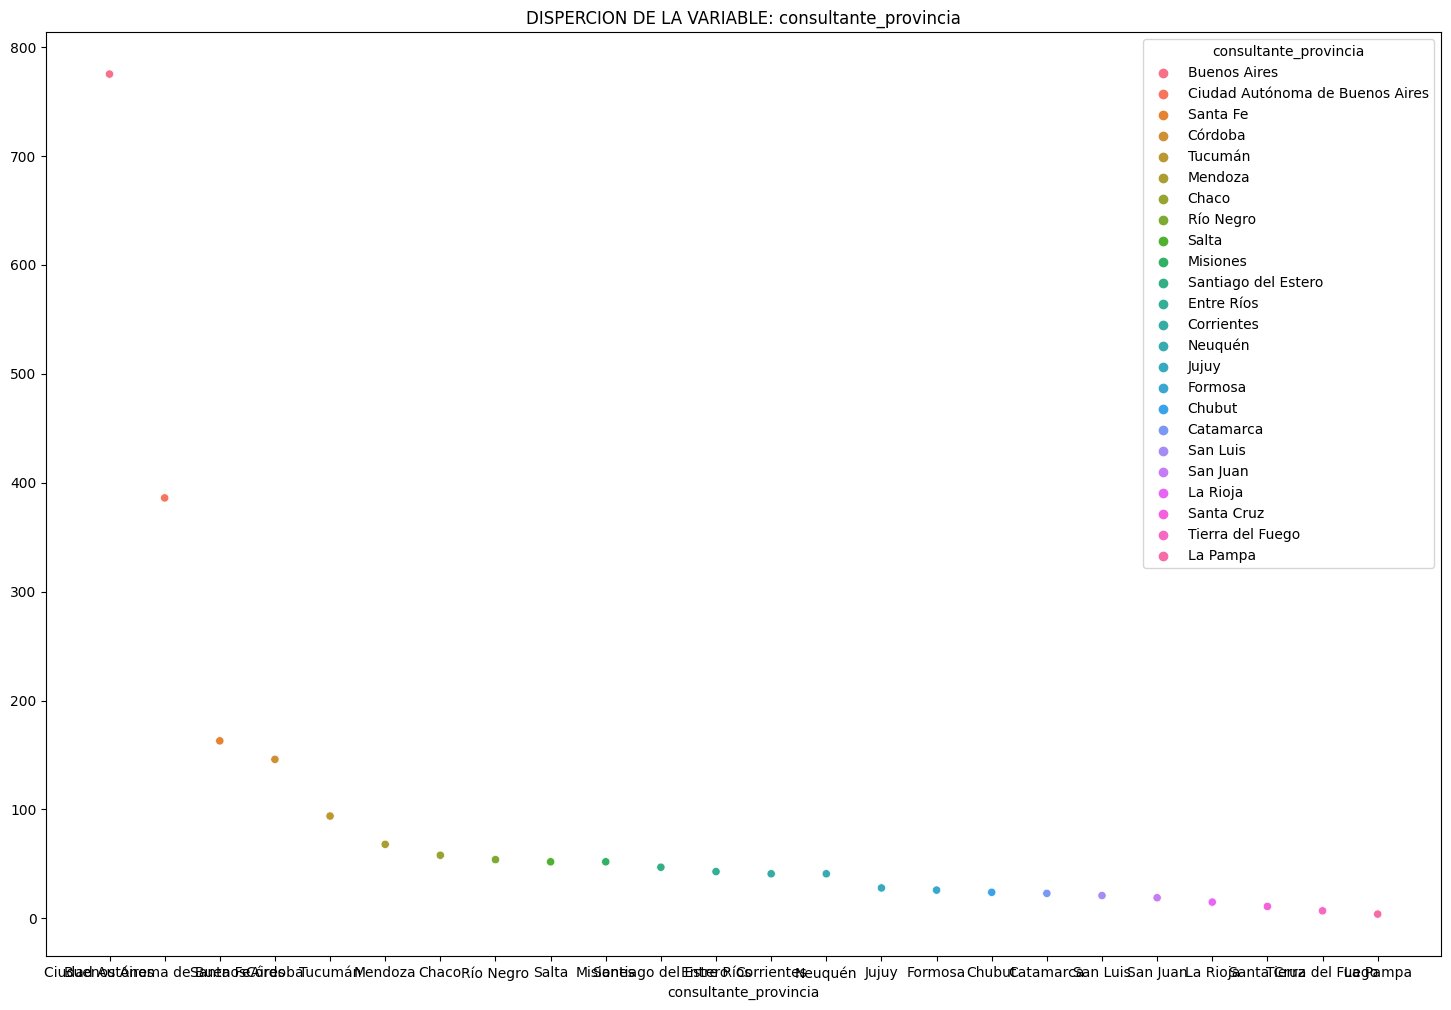

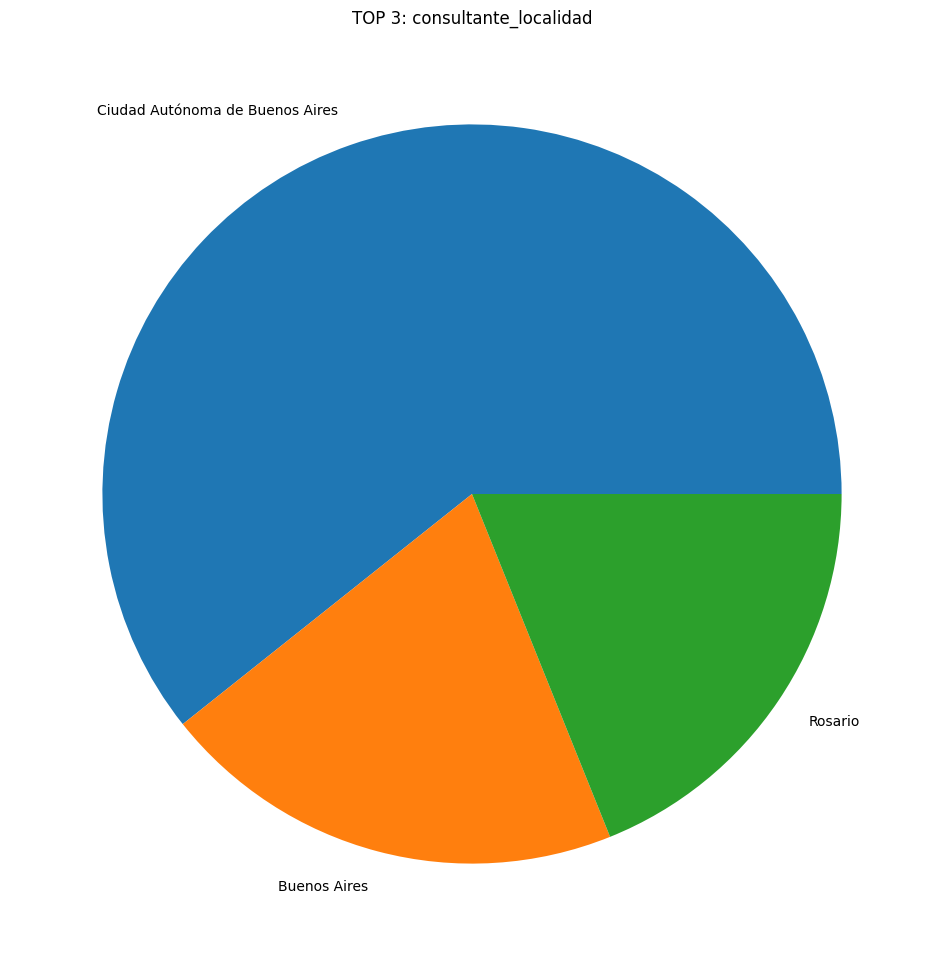

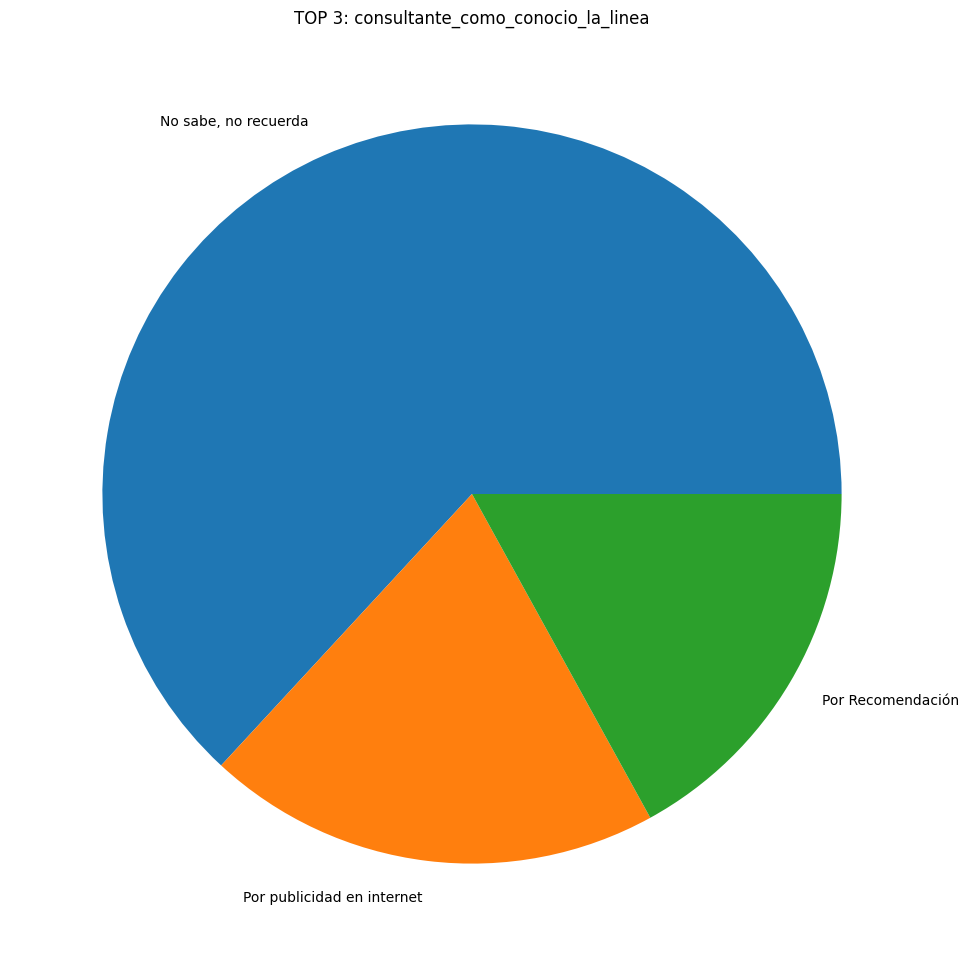

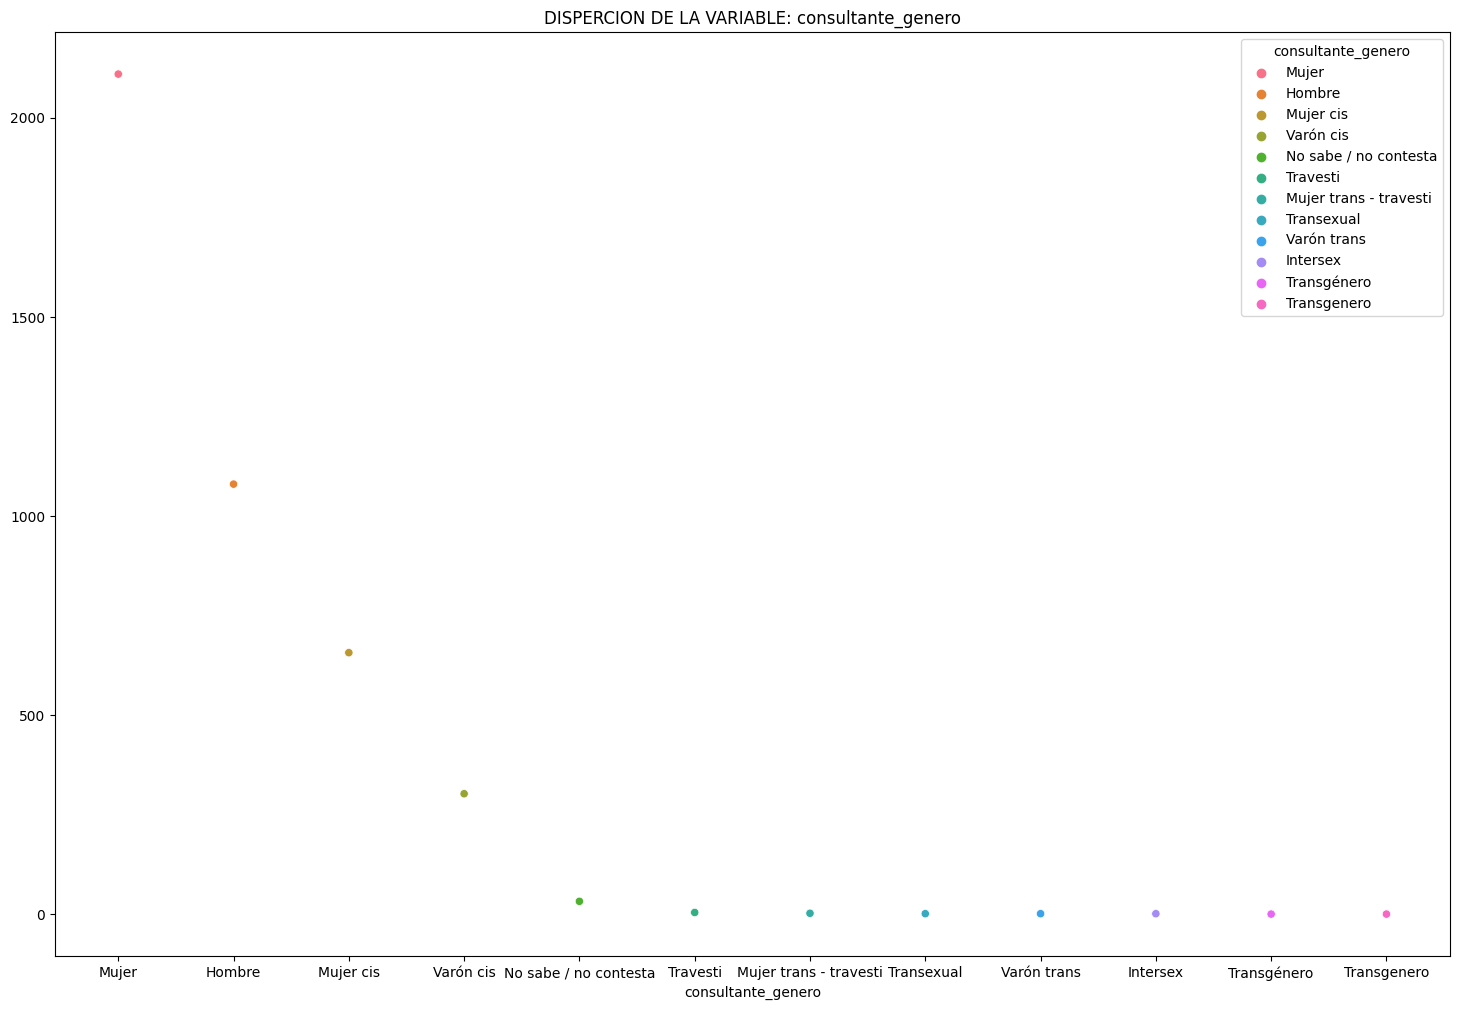

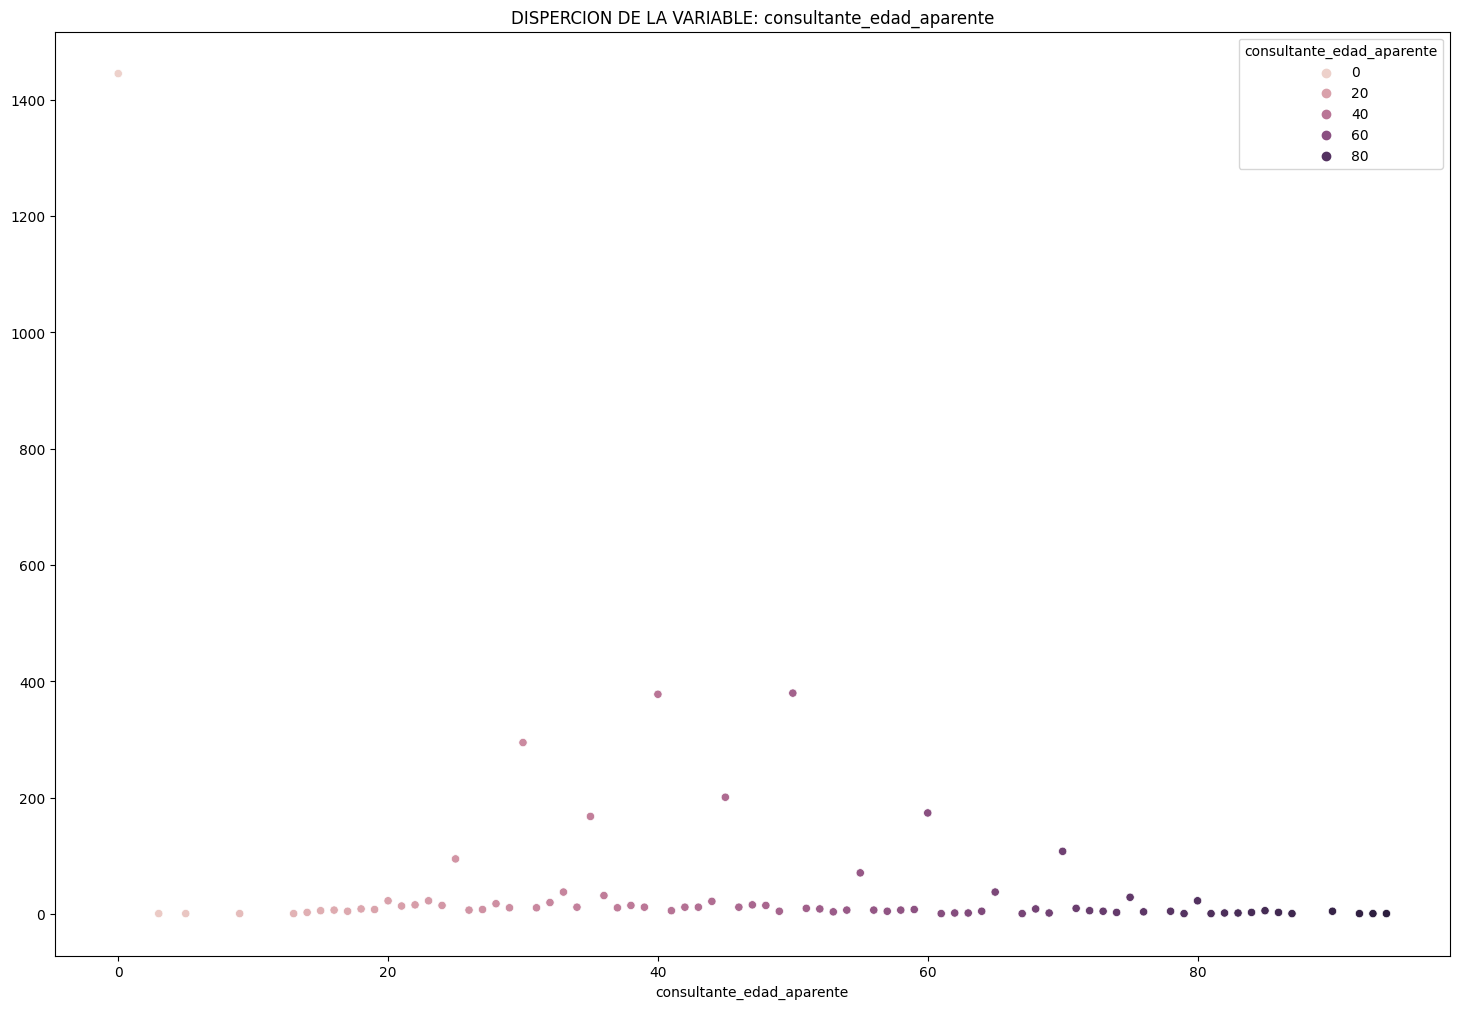

In [152]:
for column in df_orientaciones.columns:
    serie = df_orientaciones[column].value_counts()
    plt.figure(figsize=(18, 12))
    if column not in columnas_g_torta:
        sns.scatterplot(x=serie.index, y=serie.values, hue=serie.index)
        plt.title(f'DISPERCION DE LA VARIABLE: {column}')
    else:
        #Se crea grafico de torta, para aquellas columnas con etiquetas demaciado extensas o en demacia
        top_columnas = serie.nlargest(3)
        plt.pie(top_columnas, labels = top_columnas.index)
        plt.title(f'TOP 3: {column}')

#### 2.3.0.0 - CORRELACION

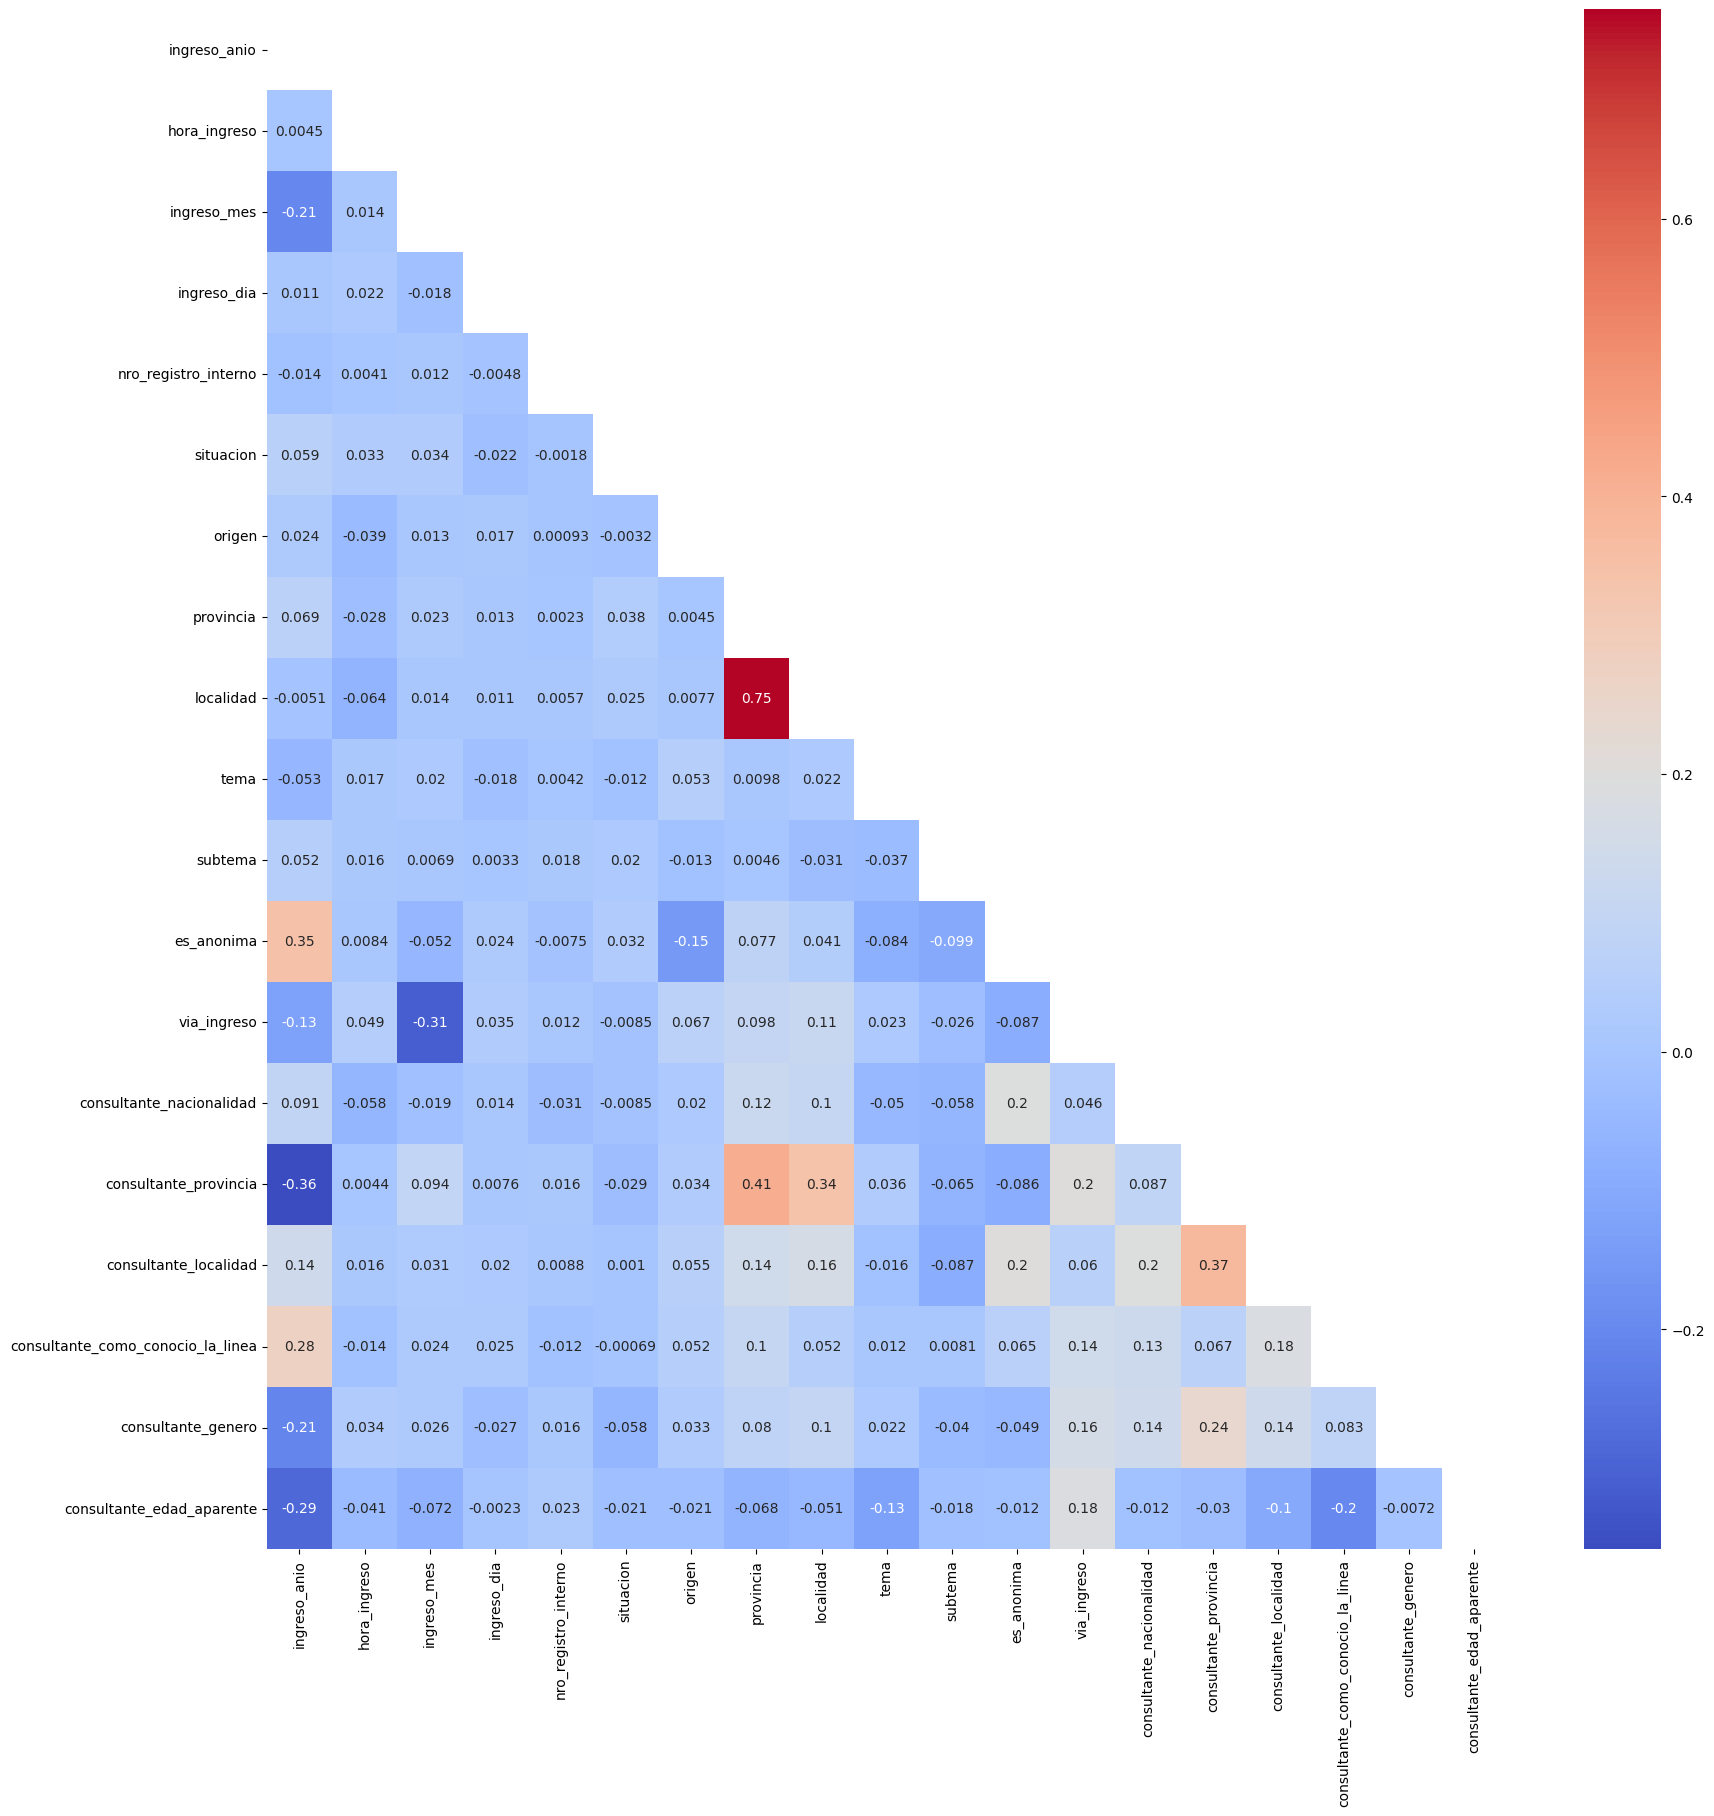

In [135]:
matriz_correlacion = df_orientaciones_escalados.corr()
mascara_espejo = np.triu(np.ones_like(matriz_correlacion, dtype=bool))
plt.figure(figsize=(20, 20))
sns.heatmap(matriz_correlacion, mask = mascara_espejo, annot=True, cmap = 'coolwarm')
plt.show()

### 2.4.0 - ALMACENAMIENTO CSV

In [136]:
df_orientaciones_codificados.to_csv('../datos/csv procesados/orientacion_codificados.csv', index=False)
df_orientaciones_escalados.to_csv('../datos/csv procesados/orientacion_escalados.csv', index=False)
df_orientaciones.to_csv('../datos/csv procesados/orientacion.csv', index=False)